In [91]:
# -----------------------------------------------------------------------------
# 0. 임포트 라이브러리
# -----------------------------------------------------------------------------

import os
import glob
import random
import time
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import models, transforms
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde

import warnings
warnings.filterwarnings('ignore')

In [92]:
# -----------------------------------------------------------------------------
# 1. 환경 설정 (Configuration)
# -----------------------------------------------------------------------------
CONFIG = {
    'ROOT_DIR': os.getcwd(),
    'SOURCE_DATA_DIR': os.path.join(os.getcwd(), 'Data'),
    'NEW_DATASET_DIR': os.path.join(os.getcwd(), 'Data_split_full'),
    
    # [저장 경로] Result_final 폴더로 통일
    'RESULT_DIR': os.path.join(os.getcwd(), 'Result_final'),
    'RESULT_W_DIR': os.path.join(os.getcwd(), 'Result_final', 'weights'),
    
    'MODEL_NAME': 'EfficientNet-B0',
    'CLASSES': ['G1', 'G2', 'G3', 'G4'],
    
    # [설정 유지] 7~8시간 학습을 위해 Epoch 150, Patience 20
    'EPOCHS': 150,
    'PATIENCE': 20,
    'BATCH_SIZE': 32,
    
    'IMG_SIZE': 256,
    'LEARNING_RATE': 5e-5,
    'SEED': 42
}

# [모델 선택] 1: 활성, 0: 비활성
MODEL_SELECTION = {
    'EfficientNet-B0': 1,
    'DenseNet-121': 1,
    'MobileNetV2': 1,
    'MobileNetV3-Small': 1
}

# 각 모델별 시작 가중치 경로 (Result_w)
PRETRAINED_WEIGHTS = {
    'EfficientNet-B0': os.path.join(os.getcwd(), 'Result_w', 'EfficientNet-B0_best.pth'),
    'DenseNet-121': os.path.join(os.getcwd(), 'Result_w', 'DenseNet-121_best.pth'),
    'MobileNetV2': os.path.join(os.getcwd(), 'Result_w', 'MobileNetV2_best.pth'),
    'MobileNetV3-Small': os.path.join(os.getcwd(), 'Result_w', 'MobileNetV3-Small_best.pth')
}

os.makedirs(CONFIG['RESULT_DIR'], exist_ok=True)
os.makedirs(CONFIG['RESULT_W_DIR'], exist_ok=True)

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CONFIG['SEED'])

if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f">> GPU Activated: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("!! GPU not found.")

print(f">> Save Results To: {CONFIG['RESULT_DIR']}")

>> GPU Activated: NVIDIA GeForce RTX 4070 Laptop GPU
>> Save Results To: c:\yssong\Mid_project\Mold-Pang_final\Result_final


In [93]:
# -----------------------------------------------------------------------------
# 2. 데이터셋 구축: 배경 포함(Unmasked) BBox Crop
# -----------------------------------------------------------------------------
def create_unmasked_dataset(source_dir, target_dir):
    if os.path.exists(target_dir):
        print(f">> '{target_dir}' already exists. Using existing dataset.")
        return

    print(f">> Generating Unmasked Dataset in '{target_dir}'...")
    
    class_map = {0: 'G1', 1: 'G2', 2: 'G3', 3: 'G4'}

    for split in ['train', 'valid', 'test']:
        img_path_base = os.path.join(source_dir, split, 'images')
        lbl_path_base = os.path.join(source_dir, split, 'labels')
        
        for cls_name in class_map.values():
            os.makedirs(os.path.join(target_dir, split, cls_name), exist_ok=True)
            
        img_files = glob.glob(os.path.join(img_path_base, '*.jpg')) + glob.glob(os.path.join(img_path_base, '*.png'))
        
        for file in tqdm(img_files, desc=f"Processing {split}"):
            filename = os.path.basename(file)
            txt_name = os.path.splitext(filename)[0] + '.txt'
            txt_full_path = os.path.join(lbl_path_base, txt_name)
            
            if not os.path.exists(txt_full_path): continue
            
            img = cv2.imread(file)
            if img is None: continue
            h, w = img.shape[:2]
            
            with open(txt_full_path, 'r') as f:
                lines = f.readlines()
                
            for idx, line in enumerate(lines):
                parts = list(map(float, line.strip().split()))
                cls_id = int(parts[0])
                if cls_id not in class_map: continue
                
                # YOLO 좌표 복원
                if len(parts) > 5: 
                    coords = np.array(parts[1:]).reshape(-1, 2)
                    coords[:, 0] *= w
                    coords[:, 1] *= h
                    pts = coords.astype(np.int32)
                    x, y, bw, bh = cv2.boundingRect(pts)
                else: 
                    cx, cy, bw_n, bh_n = parts[1], parts[2], parts[3], parts[4]
                    bw, bh = int(bw_n * w), int(bh_n * h)
                    x = int((cx * w) - (bw / 2))
                    y = int((cy * h) - (bh / 2))
                
                x = max(0, x); y = max(0, y)
                x2 = min(w, x + bw); y2 = min(h, y + bh)
                
                crop_img = img[y:y2, x:x2]
                
                if crop_img.size == 0: continue
                
                save_name = f"{os.path.splitext(filename)[0]}_{idx}.jpg"
                save_path = os.path.join(target_dir, split, class_map[cls_id], save_name)
                cv2.imwrite(save_path, crop_img)

create_unmasked_dataset(CONFIG['SOURCE_DATA_DIR'], CONFIG['NEW_DATASET_DIR'])

>> 'c:\yssong\Mid_project\Mold-Pang_final\Data_split_full' already exists. Using existing dataset.


In [94]:
# -----------------------------------------------------------------------------
# 3. 데이터 로더 정의 (Stronger Augmentation + Random Erasing)
# -----------------------------------------------------------------------------
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2), 
    transforms.RandomRotation(30),        
    
    # 형태 왜곡
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.8, 1.2), shear=10),
    
    # 색상 왜곡
    transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, hue=0.1),
    
    # 흐림 효과
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    
    # [추가] Random Erasing (Cutout): 이미지 일부를 랜덤하게 지움 (p=0.2)
    # 반드시 ToTensor/Normalize 뒤에 와야 함
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=0, inplace=False)
])

test_transforms = transforms.Compose([
    transforms.Resize((CONFIG['IMG_SIZE'], CONFIG['IMG_SIZE'])),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

from torchvision.datasets import ImageFolder

def get_dataloaders(root_dir, batch_size):
    if not os.path.exists(os.path.join(root_dir, 'train')):
        print("Dataset not ready.")
        return None, None, None, None

    train_ds = ImageFolder(os.path.join(root_dir, 'train'), transform=train_transforms)
    valid_ds = ImageFolder(os.path.join(root_dir, 'valid'), transform=test_transforms)
    test_ds = ImageFolder(os.path.join(root_dir, 'test'), transform=test_transforms)
    
    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
    valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
    
    return train_dl, valid_dl, test_dl, train_ds.classes

train_loader, valid_loader, test_loader, class_names = get_dataloaders(CONFIG['NEW_DATASET_DIR'], CONFIG['BATCH_SIZE'])
print(f">> Classes: {class_names}")

>> Classes: ['G1', 'G2', 'G3', 'G4']


In [95]:
# -----------------------------------------------------------------------------
# 4. 모델 초기화 및 Pre-trained Weights 로드 (Dropout 강화)
# -----------------------------------------------------------------------------
def get_model(model_name, num_classes, pretrained_path):
    name = model_name.lower()
    print(f">> Initializing {model_name}...")
    
    if 'efficientnet' in name:
        model = models.efficientnet_b0(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier = nn.Sequential(
            nn.Dropout(p=0.5, inplace=True),
            nn.Linear(in_features, num_classes)
        )
    elif 'densenet' in name:
        model = models.densenet121(weights=None)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)
    elif 'mobilenetv3' in name:
        model = models.mobilenet_v3_small(weights=None)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    elif 'mobilenetv2' in name:
        model = models.mobilenet_v2(weights=None)
        model.classifier[-1] = nn.Linear(model.classifier[-1].in_features, num_classes)
    else:
        raise ValueError(f"Unsupported model: {model_name}")
    
    if pretrained_path and os.path.exists(pretrained_path):
        print(f">> Loading weights from: {pretrained_path}")
        try:
            state_dict = torch.load(pretrained_path, map_location=device)
            model.load_state_dict(state_dict, strict=False)
            print(">> Weights Loaded Successfully (strict=False). Starting Generalization Training...")
        except Exception as e:
            print(f"!! Error loading weights: {e}")
            print("!! Starting from scratch (Random Init).")
    else:
        print(f"!! Pretrained weights not found at {pretrained_path}")
        print("!! Starting from scratch.")
        
    return model.to(device)

In [96]:
# -----------------------------------------------------------------------------
# 5. 학습 엔진 (Trainer & Early Stopping) - T_0=10 수정 완료
# -----------------------------------------------------------------------------

class EarlyStopping:
    def __init__(self, patience=10, verbose=True, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta

    def __call__(self, val_loss, model, save_path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, save_path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'   -> EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, save_path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, save_path):
        if self.verbose:
            print(f'   -> Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), save_path)
        self.val_loss_min = val_loss

class Trainer:
    def __init__(self, model, device):
        self.model = model
        self.device = device
        # [수정 핵심] Label Smoothing 적용 (과적합 방지)
        # label_smoothing=0.1: 정답에 대한 확신을 10% 낮추어 일반화 성능 향상
        self.criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
        
        # Weight Decay 1e-1 (유지)
        self.optimizer = optim.AdamW(self.model.parameters(), 
                                     lr=CONFIG['LEARNING_RATE'], 
                                     weight_decay=1e-1) 
        
        self.scaler = torch.amp.GradScaler('cuda') 
        self.history = []
        
        self.early_stopping = EarlyStopping(patience=CONFIG['PATIENCE'], verbose=True)
    
    def run(self, train_loader, valid_loader, epochs):
        # [수정] T_0 = 10 (더 자주 Restart)
        scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
            self.optimizer, T_0=10, T_mult=2, eta_min=1e-7
        )
        
        print(f">> Start Training for {epochs} Epochs with Warm Restarts (T_0=10)...")
        print(f"   Initial LR: {CONFIG['LEARNING_RATE']}")
        print(f"   Weight Decay: 1e-1 (Strong Regularization)")
        print(f"   Dropout: 0.5 (Applied)")
        print("-" * 100)
        
        best_model_path = os.path.join(CONFIG['RESULT_W_DIR'], f"{CONFIG['MODEL_NAME']}_final_best.pth")
        
        for epoch in range(epochs):
            start_time = time.time()
            self.model.train()
            train_loss = 0
            train_preds, train_targets = [], []
            
            # --- Training Loop ---
            for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}", leave=False):
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                
                self.optimizer.zero_grad()
                
                with torch.amp.autocast('cuda'):
                    outputs = self.model(imgs)
                    loss = self.criterion(outputs, labels)
                    
                self.scaler.scale(loss).backward()
                self.scaler.step(self.optimizer)
                self.scaler.update()
                
                train_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_targets.extend(labels.cpu().numpy())
            
            # Scheduler Step
            scheduler.step()
            current_lr = scheduler.get_last_lr()[0]
            
            # --- Validation Loop ---
            val_metrics = self.evaluate(valid_loader)
            train_loss_avg = train_loss / len(train_loader)
            train_acc = accuracy_score(train_targets, train_preds)
            
            vram_gb = torch.cuda.memory_allocated(self.device) / 1024**3
            epoch_time = time.time() - start_time
            
            log = {
                'Epoch': epoch + 1,
                'Train Loss': train_loss_avg, 'Train Acc': train_acc,
                'Valid Loss': val_metrics['loss'], 'Valid Acc': val_metrics['acc'],
                'Valid F1': val_metrics['f1'],
                'LR': current_lr, 'VRAM(GB)': vram_gb,
                'Time(s)': epoch_time
            }
            self.history.append(log)
            
            print(f"Epoch [{epoch+1:02d}/{epochs}] "
                  f"LR: {current_lr:.2e} | "
                  f"Tr_Loss: {train_loss_avg:.4f} | "
                  f"Val_Loss: {val_metrics['loss']:.4f} | "
                  f"Val_Acc: {val_metrics['acc']*100:.2f}% | "
                  f"Time: {epoch_time:.1f}s")
            
            self.early_stopping(val_metrics['loss'], self.model, best_model_path)
            
            if self.early_stopping.early_stop:
                print(f"!! Early stopping triggered at Epoch {epoch+1}")
                break
        
        print("-" * 100)
        if not os.path.exists(best_model_path):
             torch.save(self.model.state_dict(), best_model_path)
             
        print(f">> Final Best Model Saved: {best_model_path}")
        
        df = pd.DataFrame(self.history)
        df.to_csv(os.path.join(CONFIG['RESULT_DIR'], f"{CONFIG['MODEL_NAME']}_toward_log.csv"), index=False)
        return df

    def evaluate(self, loader):
        self.model.eval()
        loss_sum, all_preds, all_targets = 0, [], []
        with torch.no_grad():
            for imgs, labels in loader:
                imgs, labels = imgs.to(self.device), labels.to(self.device)
                with torch.amp.autocast('cuda'):
                    outputs = self.model(imgs)
                    loss = self.criterion(outputs, labels)
                loss_sum += loss.item()
                _, preds = torch.max(outputs, 1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(labels.cpu().numpy())
        return {
            'loss': loss_sum / len(loader),
            'acc': accuracy_score(all_targets, all_preds),
            'f1': f1_score(all_targets, all_preds, average='weighted')
        }


>> Training Model: EfficientNet-B0
>> Initializing EfficientNet-B0...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_w\EfficientNet-B0_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...
>> Start Training for 150 Epochs with Warm Restarts (T_0=10)...
   Initial LR: 5e-05
   Weight Decay: 1e-1 (Strong Regularization)
   Dropout: 0.5 (Applied)
----------------------------------------------------------------------------------------------------


Epoch [01/150] LR: 4.88e-05 | Tr_Loss: 0.7603 | Val_Loss: 0.6348 | Val_Acc: 87.02% | Time: 40.7s
   -> Validation loss decreased (inf --> 0.634850). Saving model...


Epoch [02/150] LR: 4.52e-05 | Tr_Loss: 0.6412 | Val_Loss: 0.5794 | Val_Acc: 90.27% | Time: 41.1s
   -> Validation loss decreased (0.634850 --> 0.579449). Saving model...


Epoch [03/150] LR: 3.97e-05 | Tr_Loss: 0.6003 | Val_Loss: 0.5765 | Val_Acc: 90.83% | Time: 42.9s
   -> Validation loss decreased (0.579449 --> 0.576521). Saving model...


Epoch [04/150] LR: 3.28e-05 | Tr_Loss: 0.5727 | Val_Loss: 0.5708 | Val_Acc: 90.27% | Time: 54.0s
   -> Validation loss decreased (0.576521 --> 0.570768). Saving model...


Epoch [05/150] LR: 2.50e-05 | Tr_Loss: 0.5531 | Val_Loss: 0.5704 | Val_Acc: 89.56% | Time: 53.9s
   -> Validation loss decreased (0.570768 --> 0.570402). Saving model...


Epoch [06/150] LR: 1.73e-05 | Tr_Loss: 0.5446 | Val_Loss: 0.5632 | Val_Acc: 90.27% | Time: 47.8s
   -> Validation loss decreased (0.570402 --> 0.563230). Saving model...


Epoch [07/150] LR: 1.04e-05 | Tr_Loss: 0.5383 | Val_Loss: 0.5566 | Val_Acc: 90.83% | Time: 45.4s
   -> Validation loss decreased (0.563230 --> 0.556560). Saving model...


Epoch [08/150] LR: 4.87e-06 | Tr_Loss: 0.5343 | Val_Loss: 0.5456 | Val_Acc: 90.55% | Time: 51.3s
   -> Validation loss decreased (0.556560 --> 0.545571). Saving model...


Epoch [09/150] LR: 1.32e-06 | Tr_Loss: 0.5217 | Val_Loss: 0.5619 | Val_Acc: 90.55% | Time: 53.2s
   -> EarlyStopping counter: 1 out of 20


Epoch [10/150] LR: 5.00e-05 | Tr_Loss: 0.5288 | Val_Loss: 0.5621 | Val_Acc: 90.27% | Time: 53.5s
   -> EarlyStopping counter: 2 out of 20


Epoch [11/150] LR: 4.97e-05 | Tr_Loss: 0.5257 | Val_Loss: 0.5523 | Val_Acc: 90.69% | Time: 54.1s
   -> EarlyStopping counter: 3 out of 20


Epoch [12/150] LR: 4.88e-05 | Tr_Loss: 0.5113 | Val_Loss: 0.5444 | Val_Acc: 91.54% | Time: 47.1s
   -> Validation loss decreased (0.545571 --> 0.544409). Saving model...


Epoch [13/150] LR: 4.73e-05 | Tr_Loss: 0.5058 | Val_Loss: 0.5349 | Val_Acc: 91.40% | Time: 47.8s
   -> Validation loss decreased (0.544409 --> 0.534937). Saving model...


Epoch [14/150] LR: 4.52e-05 | Tr_Loss: 0.4949 | Val_Loss: 0.5363 | Val_Acc: 90.97% | Time: 54.2s
   -> EarlyStopping counter: 1 out of 20


Epoch [15/150] LR: 4.27e-05 | Tr_Loss: 0.4867 | Val_Loss: 0.5319 | Val_Acc: 91.68% | Time: 54.2s
   -> Validation loss decreased (0.534937 --> 0.531915). Saving model...


Epoch [16/150] LR: 3.97e-05 | Tr_Loss: 0.4679 | Val_Loss: 0.5288 | Val_Acc: 91.40% | Time: 53.9s
   -> Validation loss decreased (0.531915 --> 0.528794). Saving model...


Epoch [17/150] LR: 3.64e-05 | Tr_Loss: 0.4697 | Val_Loss: 0.5291 | Val_Acc: 92.10% | Time: 47.8s
   -> EarlyStopping counter: 1 out of 20


Epoch [18/150] LR: 3.28e-05 | Tr_Loss: 0.4623 | Val_Loss: 0.5246 | Val_Acc: 91.68% | Time: 47.4s
   -> Validation loss decreased (0.528794 --> 0.524578). Saving model...


Epoch [19/150] LR: 2.90e-05 | Tr_Loss: 0.4527 | Val_Loss: 0.5176 | Val_Acc: 92.10% | Time: 53.9s
   -> Validation loss decreased (0.524578 --> 0.517607). Saving model...


Epoch [20/150] LR: 2.50e-05 | Tr_Loss: 0.4474 | Val_Loss: 0.5175 | Val_Acc: 92.38% | Time: 54.2s
   -> Validation loss decreased (0.517607 --> 0.517538). Saving model...


Epoch [21/150] LR: 2.11e-05 | Tr_Loss: 0.4534 | Val_Loss: 0.5290 | Val_Acc: 91.68% | Time: 54.2s
   -> EarlyStopping counter: 1 out of 20


Epoch [22/150] LR: 1.73e-05 | Tr_Loss: 0.4382 | Val_Loss: 0.5216 | Val_Acc: 91.96% | Time: 47.6s
   -> EarlyStopping counter: 2 out of 20


Epoch [23/150] LR: 1.37e-05 | Tr_Loss: 0.4401 | Val_Loss: 0.5227 | Val_Acc: 91.68% | Time: 47.6s
   -> EarlyStopping counter: 3 out of 20


Epoch [24/150] LR: 1.04e-05 | Tr_Loss: 0.4375 | Val_Loss: 0.5229 | Val_Acc: 91.68% | Time: 54.2s
   -> EarlyStopping counter: 4 out of 20


Epoch [25/150] LR: 7.41e-06 | Tr_Loss: 0.4399 | Val_Loss: 0.5207 | Val_Acc: 91.26% | Time: 54.2s
   -> EarlyStopping counter: 5 out of 20


Epoch [26/150] LR: 4.87e-06 | Tr_Loss: 0.4342 | Val_Loss: 0.5229 | Val_Acc: 92.10% | Time: 54.4s
   -> EarlyStopping counter: 6 out of 20


Epoch [27/150] LR: 2.82e-06 | Tr_Loss: 0.4317 | Val_Loss: 0.5168 | Val_Acc: 92.52% | Time: 47.1s
   -> Validation loss decreased (0.517538 --> 0.516826). Saving model...


Epoch [28/150] LR: 1.32e-06 | Tr_Loss: 0.4296 | Val_Loss: 0.5268 | Val_Acc: 90.83% | Time: 47.4s
   -> EarlyStopping counter: 1 out of 20


Epoch [29/150] LR: 4.07e-07 | Tr_Loss: 0.4299 | Val_Loss: 0.5141 | Val_Acc: 92.52% | Time: 54.8s
   -> Validation loss decreased (0.516826 --> 0.514141). Saving model...


Epoch [30/150] LR: 5.00e-05 | Tr_Loss: 0.4369 | Val_Loss: 0.5138 | Val_Acc: 92.24% | Time: 54.6s
   -> Validation loss decreased (0.514141 --> 0.513809). Saving model...


Epoch [31/150] LR: 4.99e-05 | Tr_Loss: 0.4405 | Val_Loss: 0.5430 | Val_Acc: 91.54% | Time: 54.1s
   -> EarlyStopping counter: 1 out of 20


Epoch [32/150] LR: 4.97e-05 | Tr_Loss: 0.4328 | Val_Loss: 0.5258 | Val_Acc: 91.54% | Time: 53.9s
   -> EarlyStopping counter: 2 out of 20


Epoch [33/150] LR: 4.93e-05 | Tr_Loss: 0.4312 | Val_Loss: 0.5348 | Val_Acc: 91.40% | Time: 46.8s
   -> EarlyStopping counter: 3 out of 20


Epoch [34/150] LR: 4.88e-05 | Tr_Loss: 0.4252 | Val_Loss: 0.5249 | Val_Acc: 90.97% | Time: 47.1s
   -> EarlyStopping counter: 4 out of 20


Epoch [35/150] LR: 4.81e-05 | Tr_Loss: 0.4192 | Val_Loss: 0.5192 | Val_Acc: 91.82% | Time: 53.9s
   -> EarlyStopping counter: 5 out of 20


Epoch [36/150] LR: 4.73e-05 | Tr_Loss: 0.4202 | Val_Loss: 0.5309 | Val_Acc: 91.68% | Time: 54.0s
   -> EarlyStopping counter: 6 out of 20


Epoch [37/150] LR: 4.63e-05 | Tr_Loss: 0.4157 | Val_Loss: 0.5257 | Val_Acc: 92.24% | Time: 53.9s
   -> EarlyStopping counter: 7 out of 20


Epoch [38/150] LR: 4.52e-05 | Tr_Loss: 0.4166 | Val_Loss: 0.5221 | Val_Acc: 91.40% | Time: 54.5s
   -> EarlyStopping counter: 8 out of 20


Epoch [39/150] LR: 4.40e-05 | Tr_Loss: 0.4124 | Val_Loss: 0.5230 | Val_Acc: 92.10% | Time: 46.8s
   -> EarlyStopping counter: 9 out of 20


Epoch [40/150] LR: 4.27e-05 | Tr_Loss: 0.4093 | Val_Loss: 0.5195 | Val_Acc: 91.68% | Time: 47.6s
   -> EarlyStopping counter: 10 out of 20


Epoch [41/150] LR: 4.13e-05 | Tr_Loss: 0.4092 | Val_Loss: 0.5150 | Val_Acc: 91.96% | Time: 53.9s
   -> EarlyStopping counter: 11 out of 20


Epoch [42/150] LR: 3.97e-05 | Tr_Loss: 0.4063 | Val_Loss: 0.5167 | Val_Acc: 91.40% | Time: 53.9s
   -> EarlyStopping counter: 12 out of 20


Epoch [43/150] LR: 3.81e-05 | Tr_Loss: 0.4032 | Val_Loss: 0.5260 | Val_Acc: 91.11% | Time: 47.0s
   -> EarlyStopping counter: 13 out of 20


Epoch [44/150] LR: 3.64e-05 | Tr_Loss: 0.4000 | Val_Loss: 0.5260 | Val_Acc: 90.97% | Time: 47.9s
   -> EarlyStopping counter: 14 out of 20


Epoch [45/150] LR: 3.46e-05 | Tr_Loss: 0.4002 | Val_Loss: 0.5207 | Val_Acc: 91.82% | Time: 53.5s
   -> EarlyStopping counter: 15 out of 20


Epoch [46/150] LR: 3.28e-05 | Tr_Loss: 0.4005 | Val_Loss: 0.5286 | Val_Acc: 91.54% | Time: 53.9s
   -> EarlyStopping counter: 16 out of 20


Epoch [47/150] LR: 3.09e-05 | Tr_Loss: 0.4014 | Val_Loss: 0.5203 | Val_Acc: 91.40% | Time: 47.6s
   -> EarlyStopping counter: 17 out of 20


Epoch [48/150] LR: 2.90e-05 | Tr_Loss: 0.3911 | Val_Loss: 0.5307 | Val_Acc: 90.69% | Time: 47.6s
   -> EarlyStopping counter: 18 out of 20


Epoch [49/150] LR: 2.70e-05 | Tr_Loss: 0.3919 | Val_Loss: 0.5410 | Val_Acc: 90.41% | Time: 55.0s
   -> EarlyStopping counter: 19 out of 20


Epoch [50/150] LR: 2.50e-05 | Tr_Loss: 0.3911 | Val_Loss: 0.5247 | Val_Acc: 91.40% | Time: 54.4s
   -> EarlyStopping counter: 20 out of 20
!! Early stopping triggered at Epoch 50
----------------------------------------------------------------------------------------------------
>> Final Best Model Saved: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\EfficientNet-B0_final_best.pth


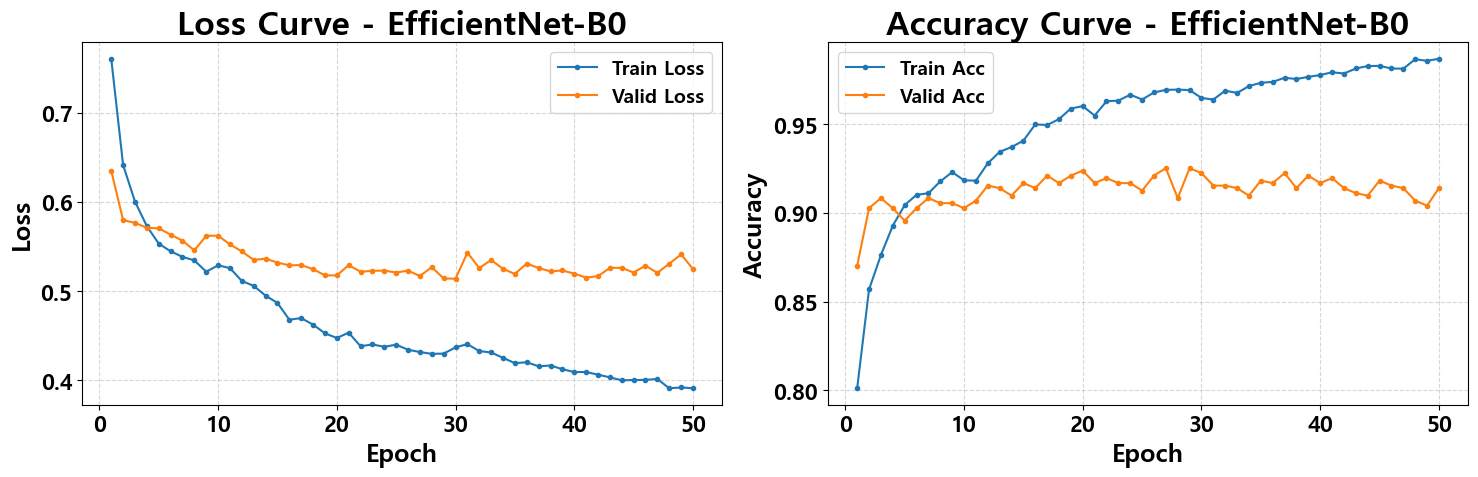


>> Training Model: DenseNet-121
>> Initializing DenseNet-121...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_w\DenseNet-121_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...
>> Start Training for 150 Epochs with Warm Restarts (T_0=10)...
   Initial LR: 5e-05
   Weight Decay: 1e-1 (Strong Regularization)
   Dropout: 0.5 (Applied)
----------------------------------------------------------------------------------------------------


Epoch [01/150] LR: 4.88e-05 | Tr_Loss: 0.6490 | Val_Loss: 0.5888 | Val_Acc: 89.84% | Time: 62.5s
   -> Validation loss decreased (inf --> 0.588835). Saving model...


Epoch [02/150] LR: 4.52e-05 | Tr_Loss: 0.5596 | Val_Loss: 0.5719 | Val_Acc: 90.83% | Time: 65.7s
   -> Validation loss decreased (0.588835 --> 0.571942). Saving model...


Epoch [03/150] LR: 3.97e-05 | Tr_Loss: 0.5248 | Val_Loss: 0.5837 | Val_Acc: 90.41% | Time: 67.8s
   -> EarlyStopping counter: 1 out of 20


Epoch [04/150] LR: 3.28e-05 | Tr_Loss: 0.5037 | Val_Loss: 0.5753 | Val_Acc: 91.11% | Time: 69.0s
   -> EarlyStopping counter: 2 out of 20


Epoch [05/150] LR: 2.50e-05 | Tr_Loss: 0.4889 | Val_Loss: 0.5696 | Val_Acc: 91.11% | Time: 64.1s
   -> Validation loss decreased (0.571942 --> 0.569581). Saving model...


Epoch [06/150] LR: 1.73e-05 | Tr_Loss: 0.4728 | Val_Loss: 0.5567 | Val_Acc: 91.11% | Time: 67.9s
   -> Validation loss decreased (0.569581 --> 0.556692). Saving model...


Epoch [07/150] LR: 1.04e-05 | Tr_Loss: 0.4617 | Val_Loss: 0.5511 | Val_Acc: 91.96% | Time: 68.7s
   -> Validation loss decreased (0.556692 --> 0.551058). Saving model...


Epoch [08/150] LR: 4.87e-06 | Tr_Loss: 0.4557 | Val_Loss: 0.5524 | Val_Acc: 91.68% | Time: 68.5s
   -> EarlyStopping counter: 1 out of 20


Epoch [09/150] LR: 1.32e-06 | Tr_Loss: 0.4541 | Val_Loss: 0.5605 | Val_Acc: 90.97% | Time: 64.5s
   -> EarlyStopping counter: 2 out of 20


Epoch [10/150] LR: 5.00e-05 | Tr_Loss: 0.4454 | Val_Loss: 0.5604 | Val_Acc: 91.11% | Time: 68.3s
   -> EarlyStopping counter: 3 out of 20


Epoch [11/150] LR: 4.97e-05 | Tr_Loss: 0.4702 | Val_Loss: 0.5642 | Val_Acc: 91.40% | Time: 68.2s
   -> EarlyStopping counter: 4 out of 20


Epoch [12/150] LR: 4.88e-05 | Tr_Loss: 0.4674 | Val_Loss: 0.5500 | Val_Acc: 91.26% | Time: 64.8s
   -> Validation loss decreased (0.551058 --> 0.549995). Saving model...


Epoch [13/150] LR: 4.73e-05 | Tr_Loss: 0.4553 | Val_Loss: 0.5699 | Val_Acc: 90.13% | Time: 68.0s
   -> EarlyStopping counter: 1 out of 20


Epoch [14/150] LR: 4.52e-05 | Tr_Loss: 0.4508 | Val_Loss: 0.5548 | Val_Acc: 90.97% | Time: 68.1s
   -> EarlyStopping counter: 2 out of 20


Epoch [15/150] LR: 4.27e-05 | Tr_Loss: 0.4438 | Val_Loss: 0.5583 | Val_Acc: 91.40% | Time: 68.1s
   -> EarlyStopping counter: 3 out of 20


Epoch [16/150] LR: 3.97e-05 | Tr_Loss: 0.4302 | Val_Loss: 0.5461 | Val_Acc: 90.83% | Time: 64.4s
   -> Validation loss decreased (0.549995 --> 0.546089). Saving model...


Epoch [17/150] LR: 3.64e-05 | Tr_Loss: 0.4254 | Val_Loss: 0.5585 | Val_Acc: 90.83% | Time: 67.6s
   -> EarlyStopping counter: 1 out of 20


Epoch [18/150] LR: 3.28e-05 | Tr_Loss: 0.4178 | Val_Loss: 0.5558 | Val_Acc: 91.40% | Time: 69.0s
   -> EarlyStopping counter: 2 out of 20


Epoch [19/150] LR: 2.90e-05 | Tr_Loss: 0.4161 | Val_Loss: 0.5569 | Val_Acc: 90.41% | Time: 62.5s
   -> EarlyStopping counter: 3 out of 20


Epoch [20/150] LR: 2.50e-05 | Tr_Loss: 0.4092 | Val_Loss: 0.5439 | Val_Acc: 91.96% | Time: 66.4s
   -> Validation loss decreased (0.546089 --> 0.543927). Saving model...


Epoch [21/150] LR: 2.11e-05 | Tr_Loss: 0.4109 | Val_Loss: 0.5426 | Val_Acc: 91.26% | Time: 68.6s
   -> Validation loss decreased (0.543927 --> 0.542561). Saving model...


Epoch [22/150] LR: 1.73e-05 | Tr_Loss: 0.4041 | Val_Loss: 0.5384 | Val_Acc: 91.68% | Time: 68.1s
   -> Validation loss decreased (0.542561 --> 0.538433). Saving model...


Epoch [23/150] LR: 1.37e-05 | Tr_Loss: 0.3985 | Val_Loss: 0.5402 | Val_Acc: 90.83% | Time: 64.5s
   -> EarlyStopping counter: 1 out of 20


Epoch [24/150] LR: 1.04e-05 | Tr_Loss: 0.3999 | Val_Loss: 0.5426 | Val_Acc: 90.83% | Time: 68.1s
   -> EarlyStopping counter: 2 out of 20


Epoch [25/150] LR: 7.41e-06 | Tr_Loss: 0.3944 | Val_Loss: 0.5357 | Val_Acc: 92.67% | Time: 68.7s
   -> Validation loss decreased (0.538433 --> 0.535715). Saving model...


Epoch [26/150] LR: 4.87e-06 | Tr_Loss: 0.3940 | Val_Loss: 0.5386 | Val_Acc: 91.68% | Time: 68.8s
   -> EarlyStopping counter: 1 out of 20


Epoch [27/150] LR: 2.82e-06 | Tr_Loss: 0.3915 | Val_Loss: 0.5393 | Val_Acc: 91.82% | Time: 62.6s
   -> EarlyStopping counter: 2 out of 20


Epoch [28/150] LR: 1.32e-06 | Tr_Loss: 0.3919 | Val_Loss: 0.5379 | Val_Acc: 91.96% | Time: 67.1s
   -> EarlyStopping counter: 3 out of 20


Epoch [29/150] LR: 4.07e-07 | Tr_Loss: 0.3922 | Val_Loss: 0.5345 | Val_Acc: 91.68% | Time: 69.7s
   -> Validation loss decreased (0.535715 --> 0.534475). Saving model...


Epoch [30/150] LR: 5.00e-05 | Tr_Loss: 0.3883 | Val_Loss: 0.5328 | Val_Acc: 91.96% | Time: 69.0s
   -> Validation loss decreased (0.534475 --> 0.532801). Saving model...


Epoch [31/150] LR: 4.99e-05 | Tr_Loss: 0.4164 | Val_Loss: 0.5483 | Val_Acc: 91.11% | Time: 65.0s
   -> EarlyStopping counter: 1 out of 20


Epoch [32/150] LR: 4.97e-05 | Tr_Loss: 0.4163 | Val_Loss: 0.5446 | Val_Acc: 91.11% | Time: 68.8s
   -> EarlyStopping counter: 2 out of 20


Epoch [33/150] LR: 4.93e-05 | Tr_Loss: 0.4180 | Val_Loss: 0.5507 | Val_Acc: 90.41% | Time: 68.8s
   -> EarlyStopping counter: 3 out of 20


Epoch [34/150] LR: 4.88e-05 | Tr_Loss: 0.4125 | Val_Loss: 0.5628 | Val_Acc: 90.69% | Time: 69.4s
   -> EarlyStopping counter: 4 out of 20


Epoch [35/150] LR: 4.81e-05 | Tr_Loss: 0.4082 | Val_Loss: 0.5195 | Val_Acc: 92.67% | Time: 62.8s
   -> Validation loss decreased (0.532801 --> 0.519493). Saving model...


Epoch [36/150] LR: 4.73e-05 | Tr_Loss: 0.4051 | Val_Loss: 0.5285 | Val_Acc: 92.67% | Time: 66.7s
   -> EarlyStopping counter: 1 out of 20


Epoch [37/150] LR: 4.63e-05 | Tr_Loss: 0.3966 | Val_Loss: 0.5324 | Val_Acc: 91.82% | Time: 69.5s
   -> EarlyStopping counter: 2 out of 20


Epoch [38/150] LR: 4.52e-05 | Tr_Loss: 0.3989 | Val_Loss: 0.5387 | Val_Acc: 90.83% | Time: 68.7s
   -> EarlyStopping counter: 3 out of 20


Epoch [39/150] LR: 4.40e-05 | Tr_Loss: 0.3994 | Val_Loss: 0.5386 | Val_Acc: 91.40% | Time: 65.5s
   -> EarlyStopping counter: 4 out of 20


Epoch [40/150] LR: 4.27e-05 | Tr_Loss: 0.3955 | Val_Loss: 0.5538 | Val_Acc: 90.69% | Time: 69.4s
   -> EarlyStopping counter: 5 out of 20


Epoch [41/150] LR: 4.13e-05 | Tr_Loss: 0.3895 | Val_Loss: 0.5567 | Val_Acc: 89.84% | Time: 69.3s
   -> EarlyStopping counter: 6 out of 20


Epoch [42/150] LR: 3.97e-05 | Tr_Loss: 0.3878 | Val_Loss: 0.5543 | Val_Acc: 89.56% | Time: 63.2s
   -> EarlyStopping counter: 7 out of 20


Epoch [43/150] LR: 3.81e-05 | Tr_Loss: 0.3870 | Val_Loss: 0.5475 | Val_Acc: 90.55% | Time: 66.0s
   -> EarlyStopping counter: 8 out of 20


Epoch [44/150] LR: 3.64e-05 | Tr_Loss: 0.3886 | Val_Loss: 0.5359 | Val_Acc: 91.26% | Time: 69.1s
   -> EarlyStopping counter: 9 out of 20


Epoch [45/150] LR: 3.46e-05 | Tr_Loss: 0.3838 | Val_Loss: 0.5347 | Val_Acc: 90.55% | Time: 68.7s
   -> EarlyStopping counter: 10 out of 20


Epoch [46/150] LR: 3.28e-05 | Tr_Loss: 0.3809 | Val_Loss: 0.5449 | Val_Acc: 91.40% | Time: 69.2s
   -> EarlyStopping counter: 11 out of 20


Epoch [47/150] LR: 3.09e-05 | Tr_Loss: 0.3819 | Val_Loss: 0.5376 | Val_Acc: 90.83% | Time: 62.7s
   -> EarlyStopping counter: 12 out of 20


Epoch [48/150] LR: 2.90e-05 | Tr_Loss: 0.3814 | Val_Loss: 0.5421 | Val_Acc: 90.13% | Time: 66.2s
   -> EarlyStopping counter: 13 out of 20


Epoch [49/150] LR: 2.70e-05 | Tr_Loss: 0.3819 | Val_Loss: 0.5256 | Val_Acc: 91.40% | Time: 69.1s
   -> EarlyStopping counter: 14 out of 20


Epoch [50/150] LR: 2.50e-05 | Tr_Loss: 0.3767 | Val_Loss: 0.5309 | Val_Acc: 91.68% | Time: 68.6s
   -> EarlyStopping counter: 15 out of 20


Epoch [51/150] LR: 2.31e-05 | Tr_Loss: 0.3753 | Val_Loss: 0.5243 | Val_Acc: 91.82% | Time: 69.1s
   -> EarlyStopping counter: 16 out of 20


Epoch [52/150] LR: 2.11e-05 | Tr_Loss: 0.3756 | Val_Loss: 0.5411 | Val_Acc: 91.26% | Time: 64.3s
   -> EarlyStopping counter: 17 out of 20


Epoch [53/150] LR: 1.92e-05 | Tr_Loss: 0.3703 | Val_Loss: 0.5299 | Val_Acc: 91.68% | Time: 69.8s
   -> EarlyStopping counter: 18 out of 20


Epoch [54/150] LR: 1.73e-05 | Tr_Loss: 0.3720 | Val_Loss: 0.5291 | Val_Acc: 92.24% | Time: 69.2s
   -> EarlyStopping counter: 19 out of 20


Epoch [55/150] LR: 1.55e-05 | Tr_Loss: 0.3713 | Val_Loss: 0.5489 | Val_Acc: 90.27% | Time: 63.4s
   -> EarlyStopping counter: 20 out of 20
!! Early stopping triggered at Epoch 55
----------------------------------------------------------------------------------------------------
>> Final Best Model Saved: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\DenseNet-121_final_best.pth


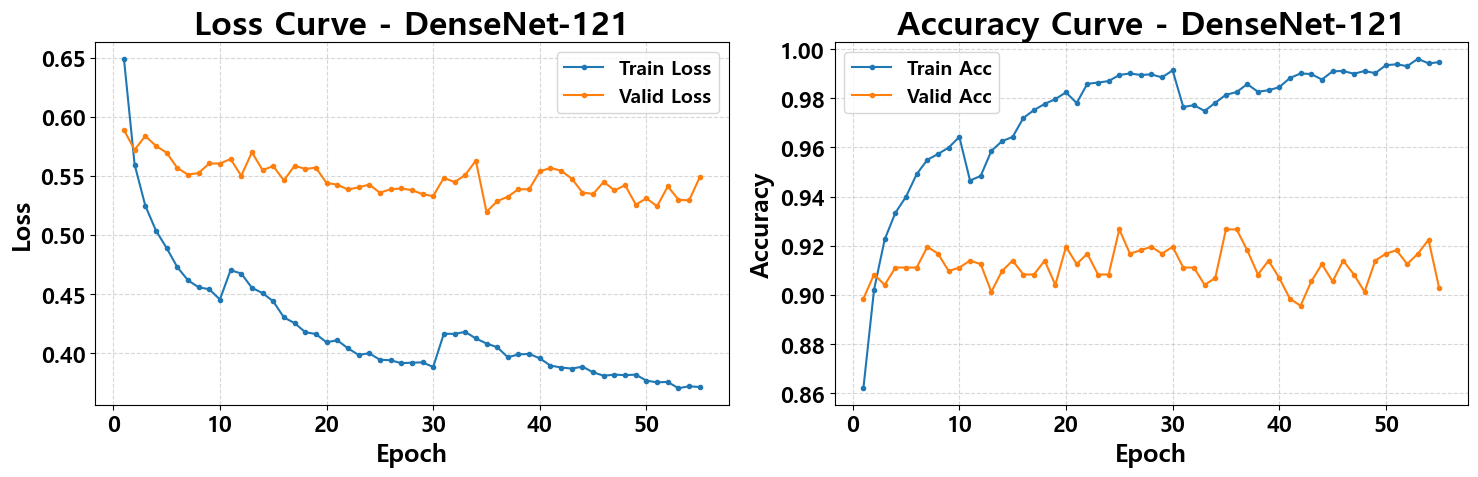


>> Training Model: MobileNetV2
>> Initializing MobileNetV2...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_w\MobileNetV2_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...
>> Start Training for 150 Epochs with Warm Restarts (T_0=10)...
   Initial LR: 5e-05
   Weight Decay: 1e-1 (Strong Regularization)
   Dropout: 0.5 (Applied)
----------------------------------------------------------------------------------------------------


Epoch [01/150] LR: 4.88e-05 | Tr_Loss: 0.7773 | Val_Loss: 0.6807 | Val_Acc: 84.91% | Time: 41.2s
   -> Validation loss decreased (inf --> 0.680736). Saving model...


Epoch [02/150] LR: 4.52e-05 | Tr_Loss: 0.6776 | Val_Loss: 0.6381 | Val_Acc: 86.18% | Time: 47.4s
   -> Validation loss decreased (0.680736 --> 0.638136). Saving model...


Epoch [03/150] LR: 3.97e-05 | Tr_Loss: 0.6396 | Val_Loss: 0.6222 | Val_Acc: 87.31% | Time: 48.5s
   -> Validation loss decreased (0.638136 --> 0.622246). Saving model...


Epoch [04/150] LR: 3.28e-05 | Tr_Loss: 0.6206 | Val_Loss: 0.6110 | Val_Acc: 88.58% | Time: 39.5s
   -> Validation loss decreased (0.622246 --> 0.611005). Saving model...


Epoch [05/150] LR: 2.50e-05 | Tr_Loss: 0.6015 | Val_Loss: 0.6098 | Val_Acc: 88.43% | Time: 38.0s
   -> Validation loss decreased (0.611005 --> 0.609781). Saving model...


Epoch [06/150] LR: 1.73e-05 | Tr_Loss: 0.5902 | Val_Loss: 0.5844 | Val_Acc: 89.70% | Time: 40.4s
   -> Validation loss decreased (0.609781 --> 0.584373). Saving model...


Epoch [07/150] LR: 1.04e-05 | Tr_Loss: 0.5755 | Val_Loss: 0.5889 | Val_Acc: 89.84% | Time: 47.8s
   -> EarlyStopping counter: 1 out of 20


Epoch [08/150] LR: 4.87e-06 | Tr_Loss: 0.5704 | Val_Loss: 0.5870 | Val_Acc: 89.56% | Time: 48.0s
   -> EarlyStopping counter: 2 out of 20


Epoch [09/150] LR: 1.32e-06 | Tr_Loss: 0.5617 | Val_Loss: 0.5859 | Val_Acc: 89.42% | Time: 39.2s
   -> EarlyStopping counter: 3 out of 20


Epoch [10/150] LR: 5.00e-05 | Tr_Loss: 0.5728 | Val_Loss: 0.5813 | Val_Acc: 89.84% | Time: 37.7s
   -> Validation loss decreased (0.584373 --> 0.581296). Saving model...


Epoch [11/150] LR: 4.97e-05 | Tr_Loss: 0.5642 | Val_Loss: 0.6002 | Val_Acc: 89.00% | Time: 38.1s
   -> EarlyStopping counter: 1 out of 20


Epoch [12/150] LR: 4.88e-05 | Tr_Loss: 0.5574 | Val_Loss: 0.5914 | Val_Acc: 90.13% | Time: 45.7s
   -> EarlyStopping counter: 2 out of 20


Epoch [13/150] LR: 4.73e-05 | Tr_Loss: 0.5480 | Val_Loss: 0.5718 | Val_Acc: 90.27% | Time: 48.4s
   -> Validation loss decreased (0.581296 --> 0.571827). Saving model...


Epoch [14/150] LR: 4.52e-05 | Tr_Loss: 0.5325 | Val_Loss: 0.5751 | Val_Acc: 89.56% | Time: 48.2s
   -> EarlyStopping counter: 1 out of 20


Epoch [15/150] LR: 4.27e-05 | Tr_Loss: 0.5332 | Val_Loss: 0.5555 | Val_Acc: 91.26% | Time: 38.9s
   -> Validation loss decreased (0.571827 --> 0.555520). Saving model...


Epoch [16/150] LR: 3.97e-05 | Tr_Loss: 0.5266 | Val_Loss: 0.5634 | Val_Acc: 90.27% | Time: 38.1s
   -> EarlyStopping counter: 1 out of 20


Epoch [17/150] LR: 3.64e-05 | Tr_Loss: 0.5145 | Val_Loss: 0.5539 | Val_Acc: 89.56% | Time: 41.2s
   -> Validation loss decreased (0.555520 --> 0.553949). Saving model...


Epoch [18/150] LR: 3.28e-05 | Tr_Loss: 0.5030 | Val_Loss: 0.5554 | Val_Acc: 90.83% | Time: 47.6s
   -> EarlyStopping counter: 1 out of 20


Epoch [19/150] LR: 2.90e-05 | Tr_Loss: 0.5017 | Val_Loss: 0.5682 | Val_Acc: 89.42% | Time: 47.8s
   -> EarlyStopping counter: 2 out of 20


Epoch [20/150] LR: 2.50e-05 | Tr_Loss: 0.4977 | Val_Loss: 0.5592 | Val_Acc: 90.69% | Time: 40.2s
   -> EarlyStopping counter: 3 out of 20


Epoch [21/150] LR: 2.11e-05 | Tr_Loss: 0.4940 | Val_Loss: 0.5590 | Val_Acc: 91.26% | Time: 38.0s
   -> EarlyStopping counter: 4 out of 20


Epoch [22/150] LR: 1.73e-05 | Tr_Loss: 0.4919 | Val_Loss: 0.5636 | Val_Acc: 89.84% | Time: 40.9s
   -> EarlyStopping counter: 5 out of 20


Epoch [23/150] LR: 1.37e-05 | Tr_Loss: 0.4868 | Val_Loss: 0.5687 | Val_Acc: 89.42% | Time: 48.0s
   -> EarlyStopping counter: 6 out of 20


Epoch [24/150] LR: 1.04e-05 | Tr_Loss: 0.4859 | Val_Loss: 0.5684 | Val_Acc: 89.42% | Time: 48.4s
   -> EarlyStopping counter: 7 out of 20


Epoch [25/150] LR: 7.41e-06 | Tr_Loss: 0.4830 | Val_Loss: 0.5627 | Val_Acc: 90.55% | Time: 40.4s
   -> EarlyStopping counter: 8 out of 20


Epoch [26/150] LR: 4.87e-06 | Tr_Loss: 0.4851 | Val_Loss: 0.5631 | Val_Acc: 89.70% | Time: 38.1s
   -> EarlyStopping counter: 9 out of 20


Epoch [27/150] LR: 2.82e-06 | Tr_Loss: 0.4750 | Val_Loss: 0.5613 | Val_Acc: 90.13% | Time: 41.1s
   -> EarlyStopping counter: 10 out of 20


Epoch [28/150] LR: 1.32e-06 | Tr_Loss: 0.4801 | Val_Loss: 0.5600 | Val_Acc: 90.41% | Time: 48.8s
   -> EarlyStopping counter: 11 out of 20


Epoch [29/150] LR: 4.07e-07 | Tr_Loss: 0.4765 | Val_Loss: 0.5609 | Val_Acc: 90.27% | Time: 49.0s
   -> EarlyStopping counter: 12 out of 20


Epoch [30/150] LR: 5.00e-05 | Tr_Loss: 0.4751 | Val_Loss: 0.5571 | Val_Acc: 90.13% | Time: 40.0s
   -> EarlyStopping counter: 13 out of 20


Epoch [31/150] LR: 4.99e-05 | Tr_Loss: 0.4848 | Val_Loss: 0.5647 | Val_Acc: 89.70% | Time: 38.4s
   -> EarlyStopping counter: 14 out of 20


Epoch [32/150] LR: 4.97e-05 | Tr_Loss: 0.4850 | Val_Loss: 0.5630 | Val_Acc: 90.27% | Time: 42.4s
   -> EarlyStopping counter: 15 out of 20


Epoch [33/150] LR: 4.93e-05 | Tr_Loss: 0.4763 | Val_Loss: 0.5702 | Val_Acc: 89.99% | Time: 48.9s
   -> EarlyStopping counter: 16 out of 20


Epoch [34/150] LR: 4.88e-05 | Tr_Loss: 0.4693 | Val_Loss: 0.5665 | Val_Acc: 89.70% | Time: 48.2s
   -> EarlyStopping counter: 17 out of 20


Epoch [35/150] LR: 4.81e-05 | Tr_Loss: 0.4660 | Val_Loss: 0.5662 | Val_Acc: 89.56% | Time: 38.7s
   -> EarlyStopping counter: 18 out of 20


Epoch [36/150] LR: 4.73e-05 | Tr_Loss: 0.4617 | Val_Loss: 0.5634 | Val_Acc: 89.28% | Time: 37.7s
   -> EarlyStopping counter: 19 out of 20


Epoch [37/150] LR: 4.63e-05 | Tr_Loss: 0.4603 | Val_Loss: 0.5772 | Val_Acc: 89.14% | Time: 40.6s
   -> EarlyStopping counter: 20 out of 20
!! Early stopping triggered at Epoch 37
----------------------------------------------------------------------------------------------------
>> Final Best Model Saved: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV2_final_best.pth


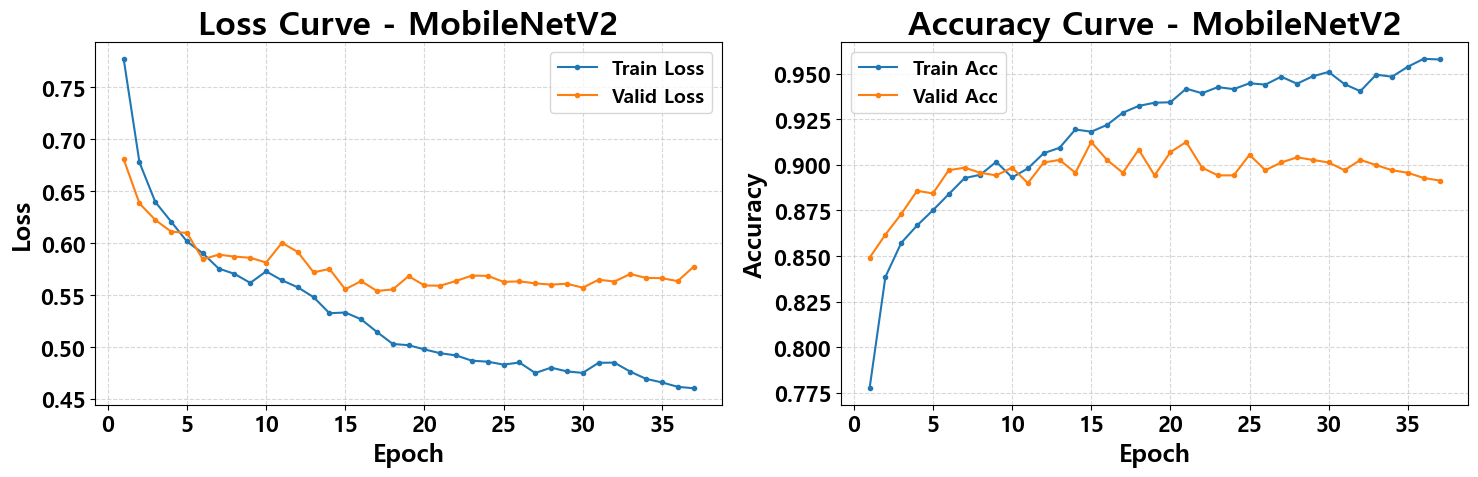


>> Training Model: MobileNetV3-Small
>> Initializing MobileNetV3-Small...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_w\MobileNetV3-Small_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...
>> Start Training for 150 Epochs with Warm Restarts (T_0=10)...
   Initial LR: 5e-05
   Weight Decay: 1e-1 (Strong Regularization)
   Dropout: 0.5 (Applied)
----------------------------------------------------------------------------------------------------


Epoch [01/150] LR: 4.88e-05 | Tr_Loss: 0.8105 | Val_Loss: 0.7155 | Val_Acc: 85.33% | Time: 46.9s
   -> Validation loss decreased (inf --> 0.715523). Saving model...


Epoch [02/150] LR: 4.52e-05 | Tr_Loss: 0.6612 | Val_Loss: 0.6411 | Val_Acc: 88.58% | Time: 37.2s
   -> Validation loss decreased (0.715523 --> 0.641096). Saving model...


Epoch [03/150] LR: 3.97e-05 | Tr_Loss: 0.6276 | Val_Loss: 0.6196 | Val_Acc: 89.14% | Time: 37.3s
   -> Validation loss decreased (0.641096 --> 0.619629). Saving model...


Epoch [04/150] LR: 3.28e-05 | Tr_Loss: 0.6137 | Val_Loss: 0.6015 | Val_Acc: 90.41% | Time: 37.4s
   -> Validation loss decreased (0.619629 --> 0.601539). Saving model...


Epoch [05/150] LR: 2.50e-05 | Tr_Loss: 0.5912 | Val_Loss: 0.5901 | Val_Acc: 90.41% | Time: 37.6s
   -> Validation loss decreased (0.601539 --> 0.590118). Saving model...


Epoch [06/150] LR: 1.73e-05 | Tr_Loss: 0.5777 | Val_Loss: 0.5870 | Val_Acc: 90.97% | Time: 37.6s
   -> Validation loss decreased (0.590118 --> 0.586968). Saving model...


Epoch [07/150] LR: 1.04e-05 | Tr_Loss: 0.5752 | Val_Loss: 0.5804 | Val_Acc: 91.11% | Time: 37.4s
   -> Validation loss decreased (0.586968 --> 0.580447). Saving model...


Epoch [08/150] LR: 4.87e-06 | Tr_Loss: 0.5698 | Val_Loss: 0.5758 | Val_Acc: 90.55% | Time: 37.2s
   -> Validation loss decreased (0.580447 --> 0.575781). Saving model...


Epoch [09/150] LR: 1.32e-06 | Tr_Loss: 0.5595 | Val_Loss: 0.5776 | Val_Acc: 90.41% | Time: 37.8s
   -> EarlyStopping counter: 1 out of 20


Epoch [10/150] LR: 5.00e-05 | Tr_Loss: 0.5589 | Val_Loss: 0.5784 | Val_Acc: 90.55% | Time: 37.9s
   -> EarlyStopping counter: 2 out of 20


Epoch [11/150] LR: 4.97e-05 | Tr_Loss: 0.5578 | Val_Loss: 0.5795 | Val_Acc: 91.11% | Time: 37.2s
   -> EarlyStopping counter: 3 out of 20


Epoch [12/150] LR: 4.88e-05 | Tr_Loss: 0.5578 | Val_Loss: 0.5733 | Val_Acc: 90.55% | Time: 37.8s
   -> Validation loss decreased (0.575781 --> 0.573268). Saving model...


Epoch [13/150] LR: 4.73e-05 | Tr_Loss: 0.5399 | Val_Loss: 0.5746 | Val_Acc: 90.13% | Time: 37.3s
   -> EarlyStopping counter: 1 out of 20


Epoch [14/150] LR: 4.52e-05 | Tr_Loss: 0.5257 | Val_Loss: 0.5665 | Val_Acc: 89.70% | Time: 37.7s
   -> Validation loss decreased (0.573268 --> 0.566474). Saving model...


Epoch [15/150] LR: 4.27e-05 | Tr_Loss: 0.5200 | Val_Loss: 0.5600 | Val_Acc: 90.41% | Time: 39.9s
   -> Validation loss decreased (0.566474 --> 0.560003). Saving model...


Epoch [16/150] LR: 3.97e-05 | Tr_Loss: 0.5146 | Val_Loss: 0.5636 | Val_Acc: 89.56% | Time: 40.0s
   -> EarlyStopping counter: 1 out of 20


Epoch [17/150] LR: 3.64e-05 | Tr_Loss: 0.5110 | Val_Loss: 0.5684 | Val_Acc: 89.99% | Time: 37.5s
   -> EarlyStopping counter: 2 out of 20


Epoch [18/150] LR: 3.28e-05 | Tr_Loss: 0.5065 | Val_Loss: 0.5599 | Val_Acc: 89.84% | Time: 38.1s
   -> Validation loss decreased (0.560003 --> 0.559887). Saving model...


Epoch [19/150] LR: 2.90e-05 | Tr_Loss: 0.4943 | Val_Loss: 0.5678 | Val_Acc: 89.99% | Time: 37.6s
   -> EarlyStopping counter: 1 out of 20


Epoch [20/150] LR: 2.50e-05 | Tr_Loss: 0.4914 | Val_Loss: 0.5556 | Val_Acc: 90.27% | Time: 37.7s
   -> Validation loss decreased (0.559887 --> 0.555571). Saving model...


Epoch [21/150] LR: 2.11e-05 | Tr_Loss: 0.4909 | Val_Loss: 0.5507 | Val_Acc: 90.27% | Time: 37.7s
   -> Validation loss decreased (0.555571 --> 0.550733). Saving model...


Epoch [22/150] LR: 1.73e-05 | Tr_Loss: 0.4889 | Val_Loss: 0.5572 | Val_Acc: 89.56% | Time: 37.5s
   -> EarlyStopping counter: 1 out of 20


Epoch [23/150] LR: 1.37e-05 | Tr_Loss: 0.4813 | Val_Loss: 0.5542 | Val_Acc: 90.27% | Time: 37.6s
   -> EarlyStopping counter: 2 out of 20


Epoch [24/150] LR: 1.04e-05 | Tr_Loss: 0.4801 | Val_Loss: 0.5552 | Val_Acc: 89.84% | Time: 38.6s
   -> EarlyStopping counter: 3 out of 20


Epoch [25/150] LR: 7.41e-06 | Tr_Loss: 0.4787 | Val_Loss: 0.5548 | Val_Acc: 89.99% | Time: 38.4s
   -> EarlyStopping counter: 4 out of 20


Epoch [26/150] LR: 4.87e-06 | Tr_Loss: 0.4769 | Val_Loss: 0.5525 | Val_Acc: 90.27% | Time: 37.6s
   -> EarlyStopping counter: 5 out of 20


Epoch [27/150] LR: 2.82e-06 | Tr_Loss: 0.4751 | Val_Loss: 0.5524 | Val_Acc: 90.27% | Time: 37.1s
   -> EarlyStopping counter: 6 out of 20


Epoch [28/150] LR: 1.32e-06 | Tr_Loss: 0.4730 | Val_Loss: 0.5534 | Val_Acc: 90.13% | Time: 37.6s
   -> EarlyStopping counter: 7 out of 20


Epoch [29/150] LR: 4.07e-07 | Tr_Loss: 0.4710 | Val_Loss: 0.5529 | Val_Acc: 90.27% | Time: 37.1s
   -> EarlyStopping counter: 8 out of 20


Epoch [30/150] LR: 5.00e-05 | Tr_Loss: 0.4679 | Val_Loss: 0.5531 | Val_Acc: 90.41% | Time: 37.8s
   -> EarlyStopping counter: 9 out of 20


Epoch [31/150] LR: 4.99e-05 | Tr_Loss: 0.4787 | Val_Loss: 0.5666 | Val_Acc: 90.69% | Time: 37.6s
   -> EarlyStopping counter: 10 out of 20


Epoch [32/150] LR: 4.97e-05 | Tr_Loss: 0.4739 | Val_Loss: 0.5633 | Val_Acc: 89.84% | Time: 37.7s
   -> EarlyStopping counter: 11 out of 20


Epoch [33/150] LR: 4.93e-05 | Tr_Loss: 0.4719 | Val_Loss: 0.5642 | Val_Acc: 90.55% | Time: 37.6s
   -> EarlyStopping counter: 12 out of 20


Epoch [34/150] LR: 4.88e-05 | Tr_Loss: 0.4686 | Val_Loss: 0.5544 | Val_Acc: 90.27% | Time: 38.3s
   -> EarlyStopping counter: 13 out of 20


Epoch [35/150] LR: 4.81e-05 | Tr_Loss: 0.4618 | Val_Loss: 0.5754 | Val_Acc: 89.56% | Time: 37.8s
   -> EarlyStopping counter: 14 out of 20


Epoch [36/150] LR: 4.73e-05 | Tr_Loss: 0.4647 | Val_Loss: 0.5645 | Val_Acc: 89.99% | Time: 37.6s
   -> EarlyStopping counter: 15 out of 20


Epoch [37/150] LR: 4.63e-05 | Tr_Loss: 0.4598 | Val_Loss: 0.5670 | Val_Acc: 90.13% | Time: 37.6s
   -> EarlyStopping counter: 16 out of 20


Epoch [38/150] LR: 4.52e-05 | Tr_Loss: 0.4543 | Val_Loss: 0.5516 | Val_Acc: 90.83% | Time: 37.5s
   -> EarlyStopping counter: 17 out of 20


Epoch [39/150] LR: 4.40e-05 | Tr_Loss: 0.4448 | Val_Loss: 0.5652 | Val_Acc: 90.55% | Time: 37.6s
   -> EarlyStopping counter: 18 out of 20


Epoch [40/150] LR: 4.27e-05 | Tr_Loss: 0.4425 | Val_Loss: 0.5529 | Val_Acc: 91.26% | Time: 37.5s
   -> EarlyStopping counter: 19 out of 20


Epoch [41/150] LR: 4.13e-05 | Tr_Loss: 0.4409 | Val_Loss: 0.5632 | Val_Acc: 90.27% | Time: 37.6s
   -> EarlyStopping counter: 20 out of 20
!! Early stopping triggered at Epoch 41
----------------------------------------------------------------------------------------------------
>> Final Best Model Saved: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV3-Small_final_best.pth


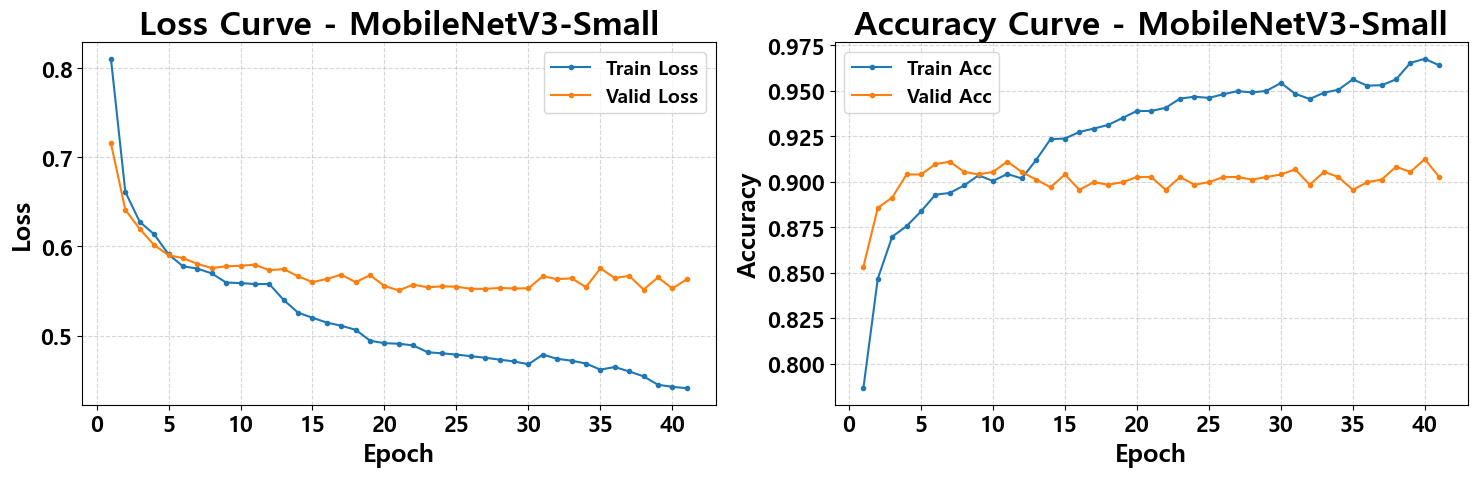


>> All training runs completed.


In [19]:
# -----------------------------------------------------------------------------
# 6. 실행 및 결과 시각화
# -----------------------------------------------------------------------------
# VRAM 정리
torch.cuda.empty_cache()

def plot_training_curves(history_df, model_name):
    plt.figure(figsize=(15, 5))
    
    # (1) Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history_df['Epoch'], history_df['Train Loss'], label='Train Loss', marker='.')
    plt.plot(history_df['Epoch'], history_df['Valid Loss'], label='Valid Loss', marker='.')
    plt.title(f'Loss Curve - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    # (2) Accuracy Curve
    plt.subplot(1, 2, 2)
    plt.plot(history_df['Epoch'], history_df['Train Acc'], label='Train Acc', marker='.')
    plt.plot(history_df['Epoch'], history_df['Valid Acc'], label='Valid Acc', marker='.')
    plt.title(f'Accuracy Curve - {model_name}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.5)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['RESULT_DIR'], f"Training_Curve_{model_name}.png"))
    plt.show()

history_by_model = {}

for model_name, is_active in MODEL_SELECTION.items():
    if is_active == 0:
        continue
    
    print("\n" + "=" * 80)
    print(f">> Training Model: {model_name}")
    print("=" * 80)
    
    CONFIG['MODEL_NAME'] = model_name
    pretrained_path = PRETRAINED_WEIGHTS.get(model_name)
    model = get_model(model_name, len(class_names), pretrained_path)
    
    trainer = Trainer(model, device)
    history_df = trainer.run(train_loader, valid_loader, CONFIG['EPOCHS'])
    history_by_model[model_name] = history_df
    
    plot_training_curves(history_df, model_name)
    
    del model
    torch.cuda.empty_cache()

print("\n>> All training runs completed.")

>> Initializing EfficientNet-B0...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\EfficientNet-B0_final_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...


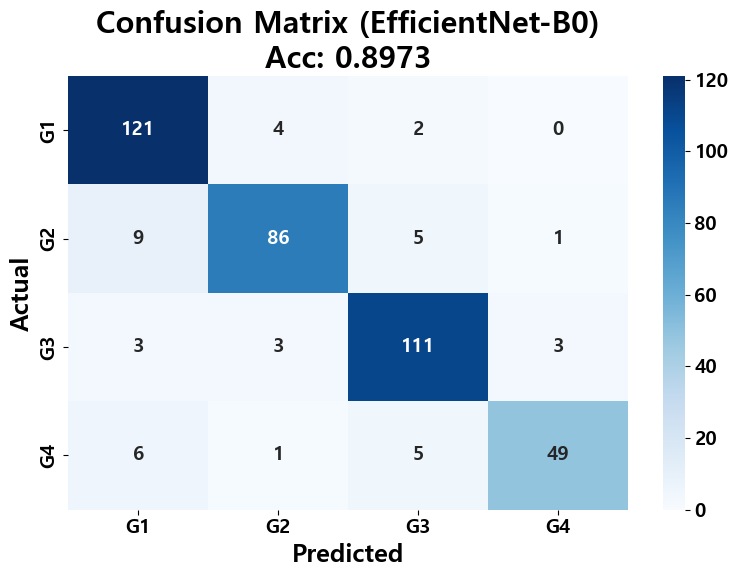

>> Generating High-Res Phase Diagram: EfficientNet-B0


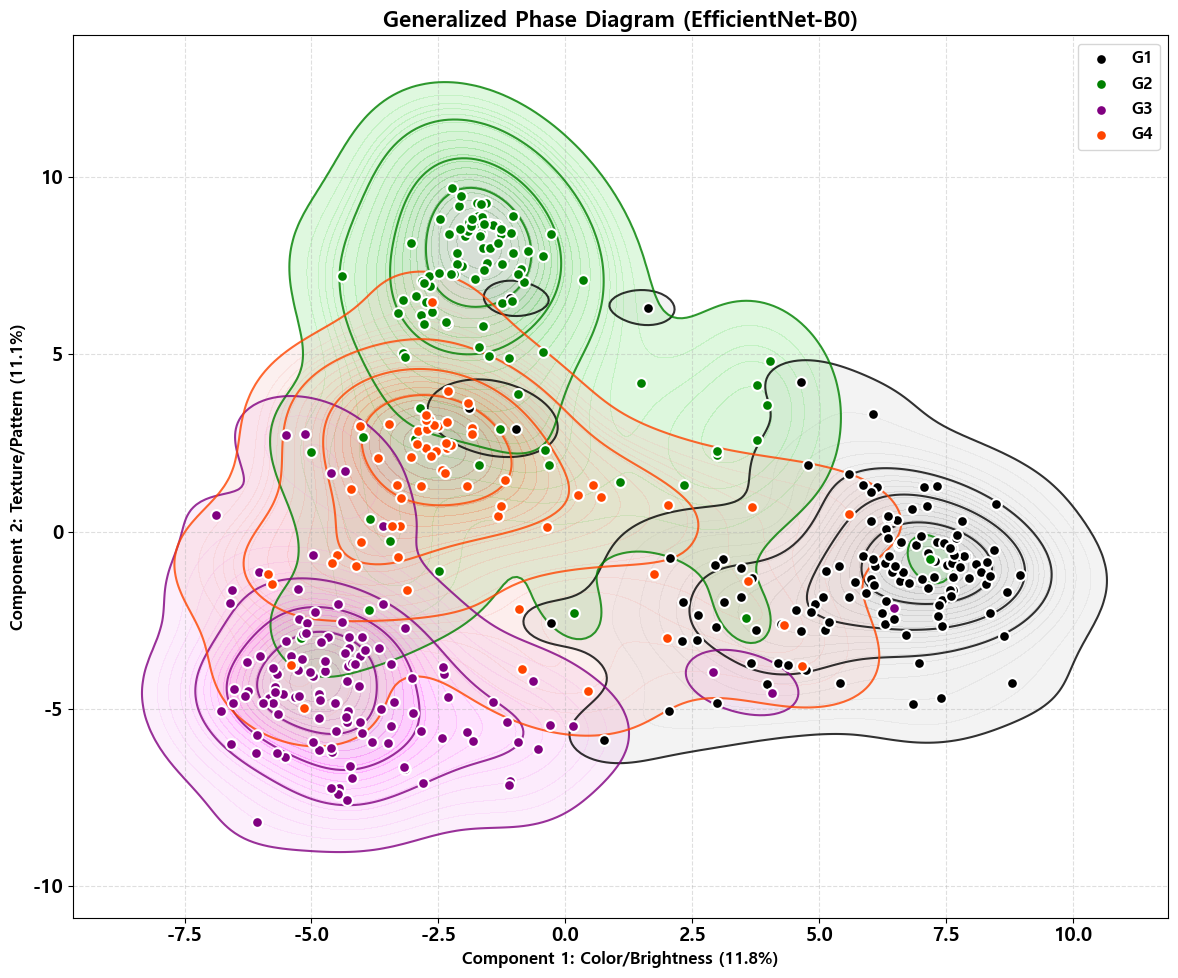

>> Initializing DenseNet-121...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\DenseNet-121_final_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...


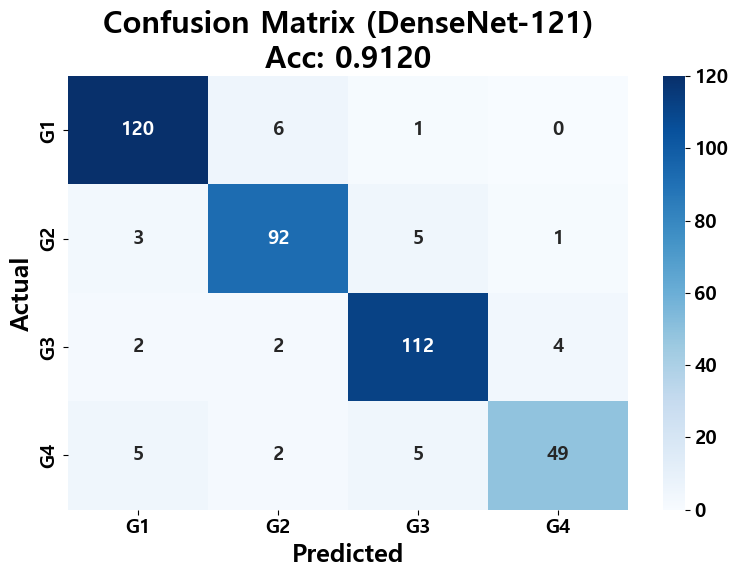

>> Generating High-Res Phase Diagram: DenseNet-121


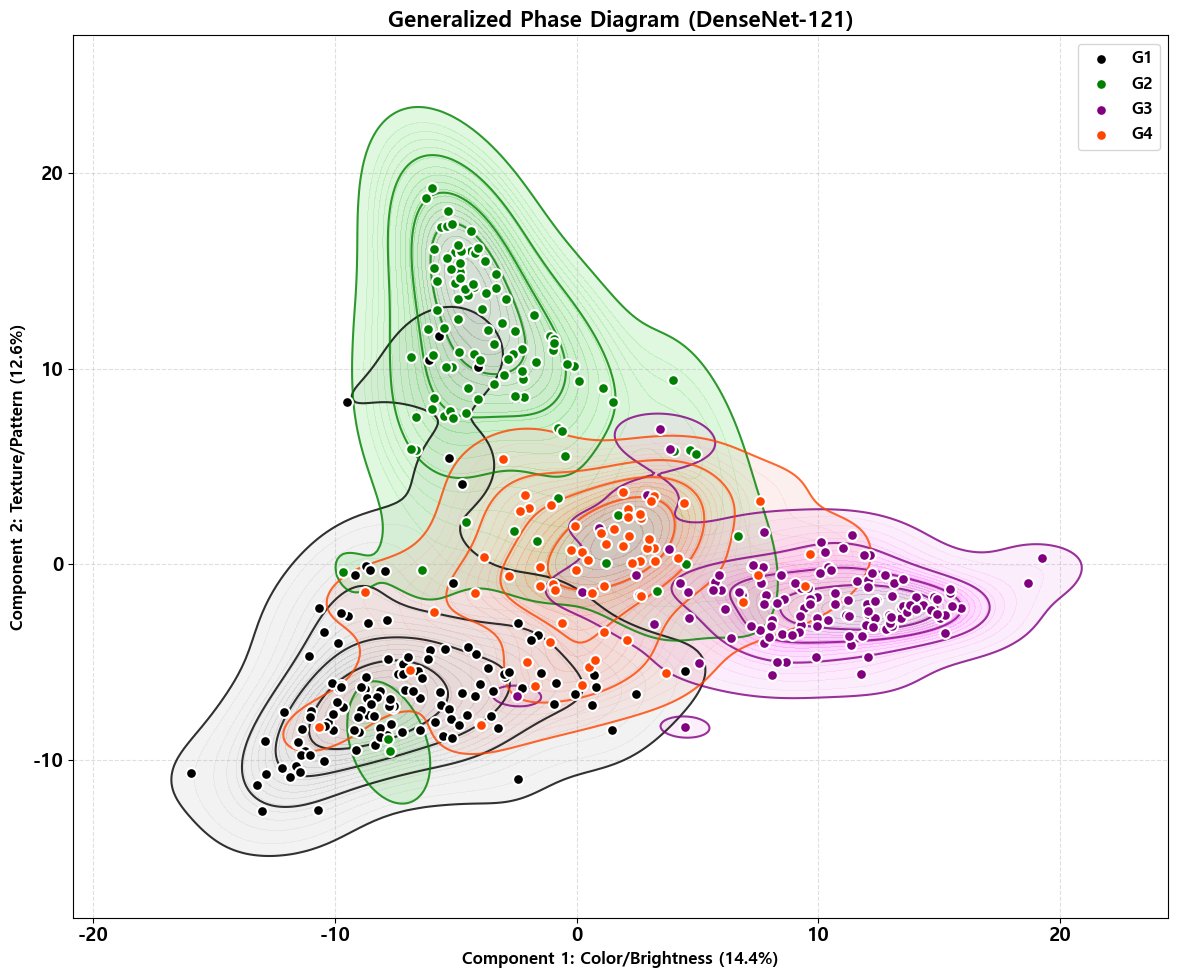

>> Initializing MobileNetV2...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV2_final_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...


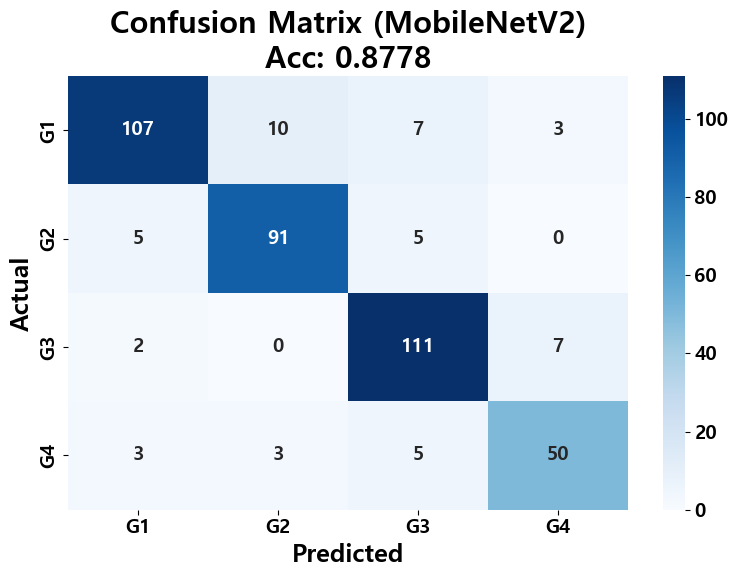

>> Generating High-Res Phase Diagram: MobileNetV2


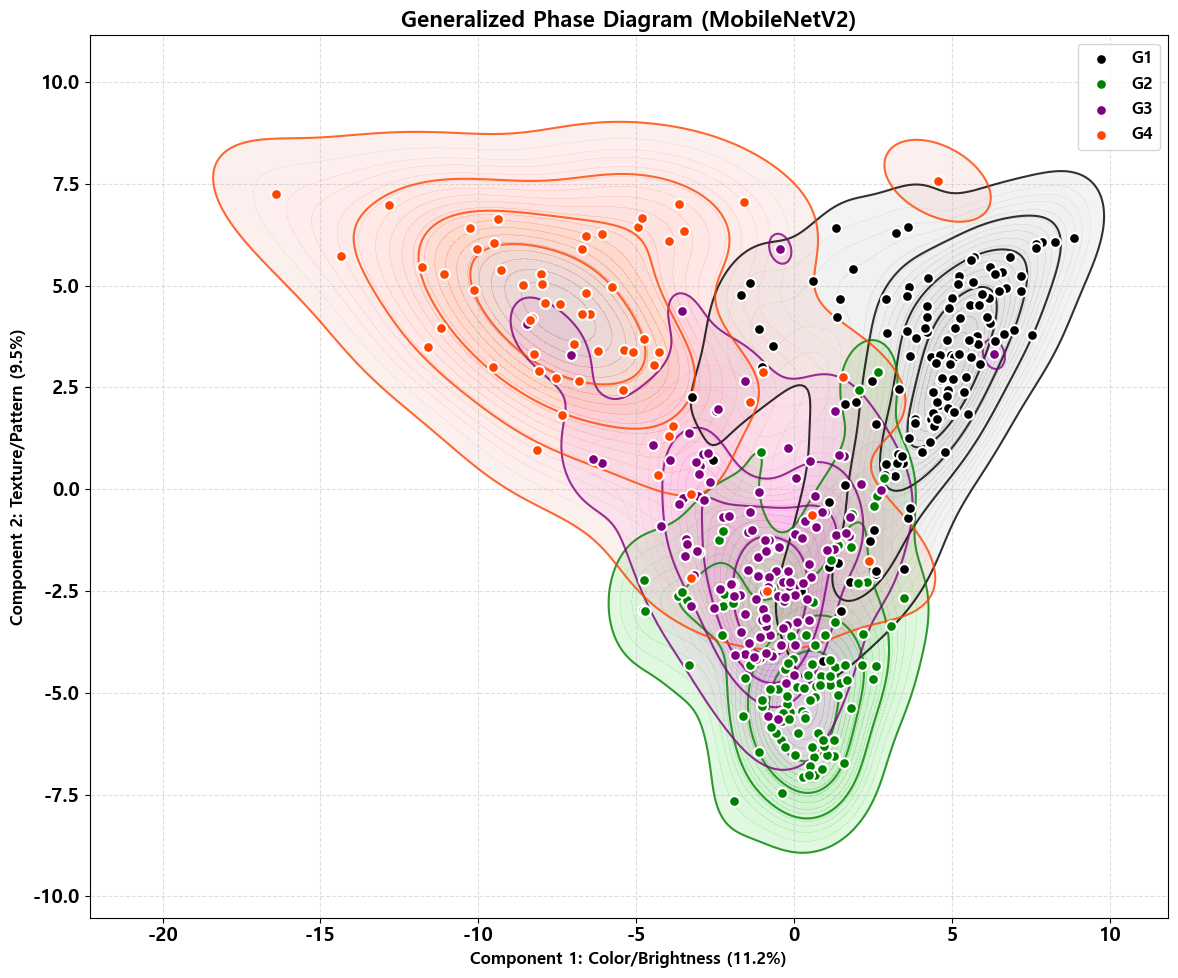

>> Initializing MobileNetV3-Small...
>> Loading weights from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV3-Small_final_best.pth
>> Weights Loaded Successfully (strict=False). Starting Generalization Training...


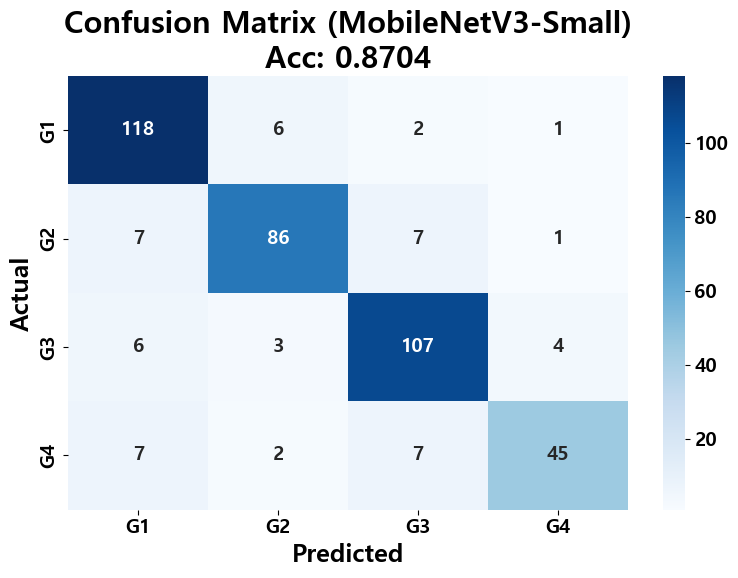

>> Generating High-Res Phase Diagram: MobileNetV3-Small


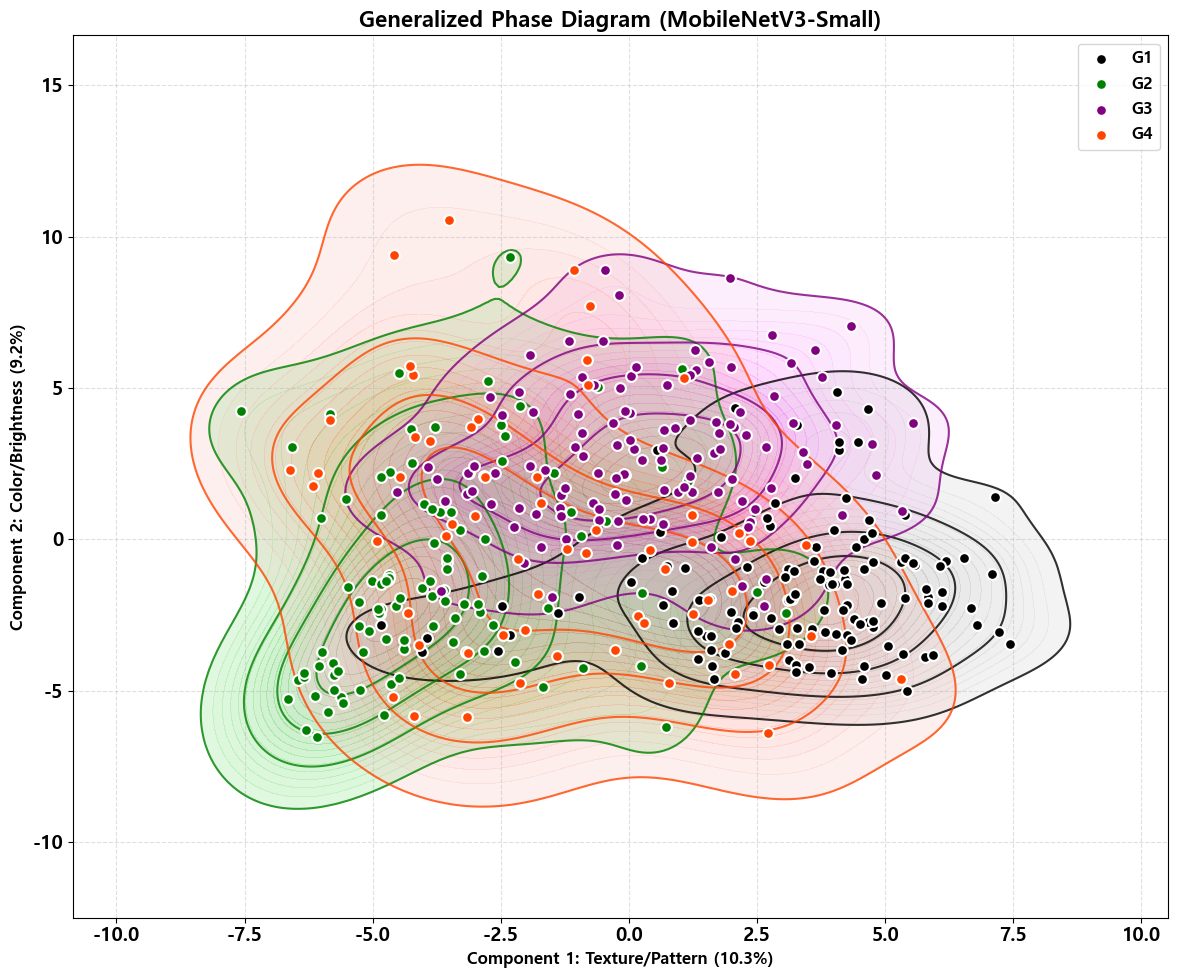

>> All Generalization Tasks Completed Successfully.


In [103]:
# -----------------------------------------------------------------------------
# 7. 최종 분석 (Confusion Matrix & High-Res Phase Diagram)
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, accuracy_score
import torch.nn.functional as F

# -----------------------------------------------------------------------------
# (1) Confusion Matrix
# -----------------------------------------------------------------------------
def plot_cm(model, loader, model_name):
    model.eval()
    all_preds, all_targets = [], []
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs = imgs.to(device)
            _, preds = torch.max(model(imgs), 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(lbls.numpy())
    
    cm = confusion_matrix(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Confusion Matrix ({model_name})\nAcc: {acc:.4f}")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['RESULT_DIR'], f"Confusion_Matrix_{model_name}.png"))
    plt.show()
    return np.array(all_preds), np.array(all_targets)

# -----------------------------------------------------------------------------
# (2) Phase Diagram (High-Resolution & Auto-Labeling)
# -----------------------------------------------------------------------------
def extract_features(model, model_name, loader):
    # 모델별 특징 추출기(Extractor) 구성
    # (각 모델마다 레이어 이름이 다르므로 분기 처리)
    name = model_name.lower()
    model.eval()
    feats_list = []
    with torch.no_grad():
        for imgs, _ in loader:
            imgs = imgs.to(device)
            # EfficientNet
            if 'efficientnet' in name:
                x = model.features(imgs)
                x = model.avgpool(x)
                x = x.flatten(1)
            # DenseNet
            elif 'densenet' in name:
                x = model.features(imgs)
                x = F.relu(x, inplace=False)
                x = F.adaptive_avg_pool2d(x, (1, 1))
                x = x.flatten(1)
            # MobileNetV3
            elif 'mobilenetv3' in name:
                x = model.features(imgs)
                x = model.avgpool(x)
                x = x.flatten(1)
            # MobileNetV2
            elif 'mobilenetv2' in name:
                x = model.features(imgs)
                x = F.adaptive_avg_pool2d(x, (1, 1))
                x = x.flatten(1)
            else:
                raise ValueError(f"Unsupported model for feature extraction: {model_name}")
            feats_list.append(x.cpu().numpy())
    return np.concatenate(feats_list)

def plot_phase(model, loader, preds, targets, model_name):
    print(f">> Generating High-Res Phase Diagram: {model_name}")
    features = extract_features(model, model_name, loader)
    
    # PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(features)
    var_ratio = pca.explained_variance_ratio_
    
    # [Smart Labeling] 축 의미 자동 해석
    g1_idx = [i for i, x in enumerate(class_names) if 'G1' in x][0]
    g3_idx = [i for i, x in enumerate(class_names) if 'G3' in x][0]
    
    g1_center = np.mean(projected[targets == g1_idx], axis=0)
    g3_center = np.mean(projected[targets == g3_idx], axis=0)
    
    diff_x = abs(g1_center[0] - g3_center[0])
    diff_y = abs(g1_center[1] - g3_center[1])
    
    if diff_x > diff_y:
        xlabel = f"Component 1: Color/Brightness ({var_ratio[0]*100:.1f}%)"
        ylabel = f"Component 2: Texture/Pattern ({var_ratio[1]*100:.1f}%)"
    else:
        xlabel = f"Component 1: Texture/Pattern ({var_ratio[0]*100:.1f}%)"
        ylabel = f"Component 2: Color/Brightness ({var_ratio[1]*100:.1f}%)"
    
    # Plotting
    plt.figure(figsize=(12, 10))
    colors = ['#000000', '#008000', '#800080', '#FF4500']
    
    for i, cls in enumerate(class_names):
        idx = (targets == i)
        subset = projected[idx]
        if len(subset) < 5: continue
        color = colors[i]
        # (A) Gradient Fill (부드러운 등고선)
        sns.kdeplot(x=subset[:, 0], y=subset[:, 1], levels=20, thresh=0.05,
                    color=color, fill=True, alpha=0.2, zorder=1)
        # (B) Core Lines (진한 테두리)
        sns.kdeplot(x=subset[:, 0], y=subset[:, 1], levels=5, thresh=0.05,
                    color=color, linewidths=1.5, alpha=0.8, zorder=2)
        # (C) Points (포인트 강조)
        plt.scatter(subset[:, 0], subset[:, 1], c=color, label=cls,
                    s=60, edgecolors='white', linewidth=1.5, zorder=10)
    
    plt.title(f"Generalized Phase Diagram ({model_name})", fontsize=16, fontweight='bold')
    plt.xlabel(xlabel, fontsize=12)
    plt.ylabel(ylabel, fontsize=12)
    plt.legend(loc='upper right', frameon=True, fancybox=True)
    plt.grid(True, linestyle='--', alpha=0.4, zorder=0)
    
    plt.tight_layout()
    plt.savefig(os.path.join(CONFIG['RESULT_DIR'], f"Generalized_Phase_Diagram_{model_name}.png"), dpi=300)
    plt.show()

# -----------------------------------------------------------------------------
# (3) 메인 실행: 4개 모델 반복
# -----------------------------------------------------------------------------
for model_name, is_active in MODEL_SELECTION.items():
    if is_active == 0:
        continue
    final_weight_path = os.path.join(CONFIG['RESULT_W_DIR'], f"{model_name}_final_best.pth")
    model = get_model(model_name, len(class_names), final_weight_path)
    preds, targets = plot_cm(model, test_loader, model_name)
    plot_phase(model, test_loader, preds, targets, model_name)
    del model
    torch.cuda.empty_cache()

print(">> All Generalization Tasks Completed Successfully.")


>> [8. Visualization] Confusion Matrix & Grad-CAM
>> Processing: DenseNet-121...
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\DenseNet-121_final_best.pth


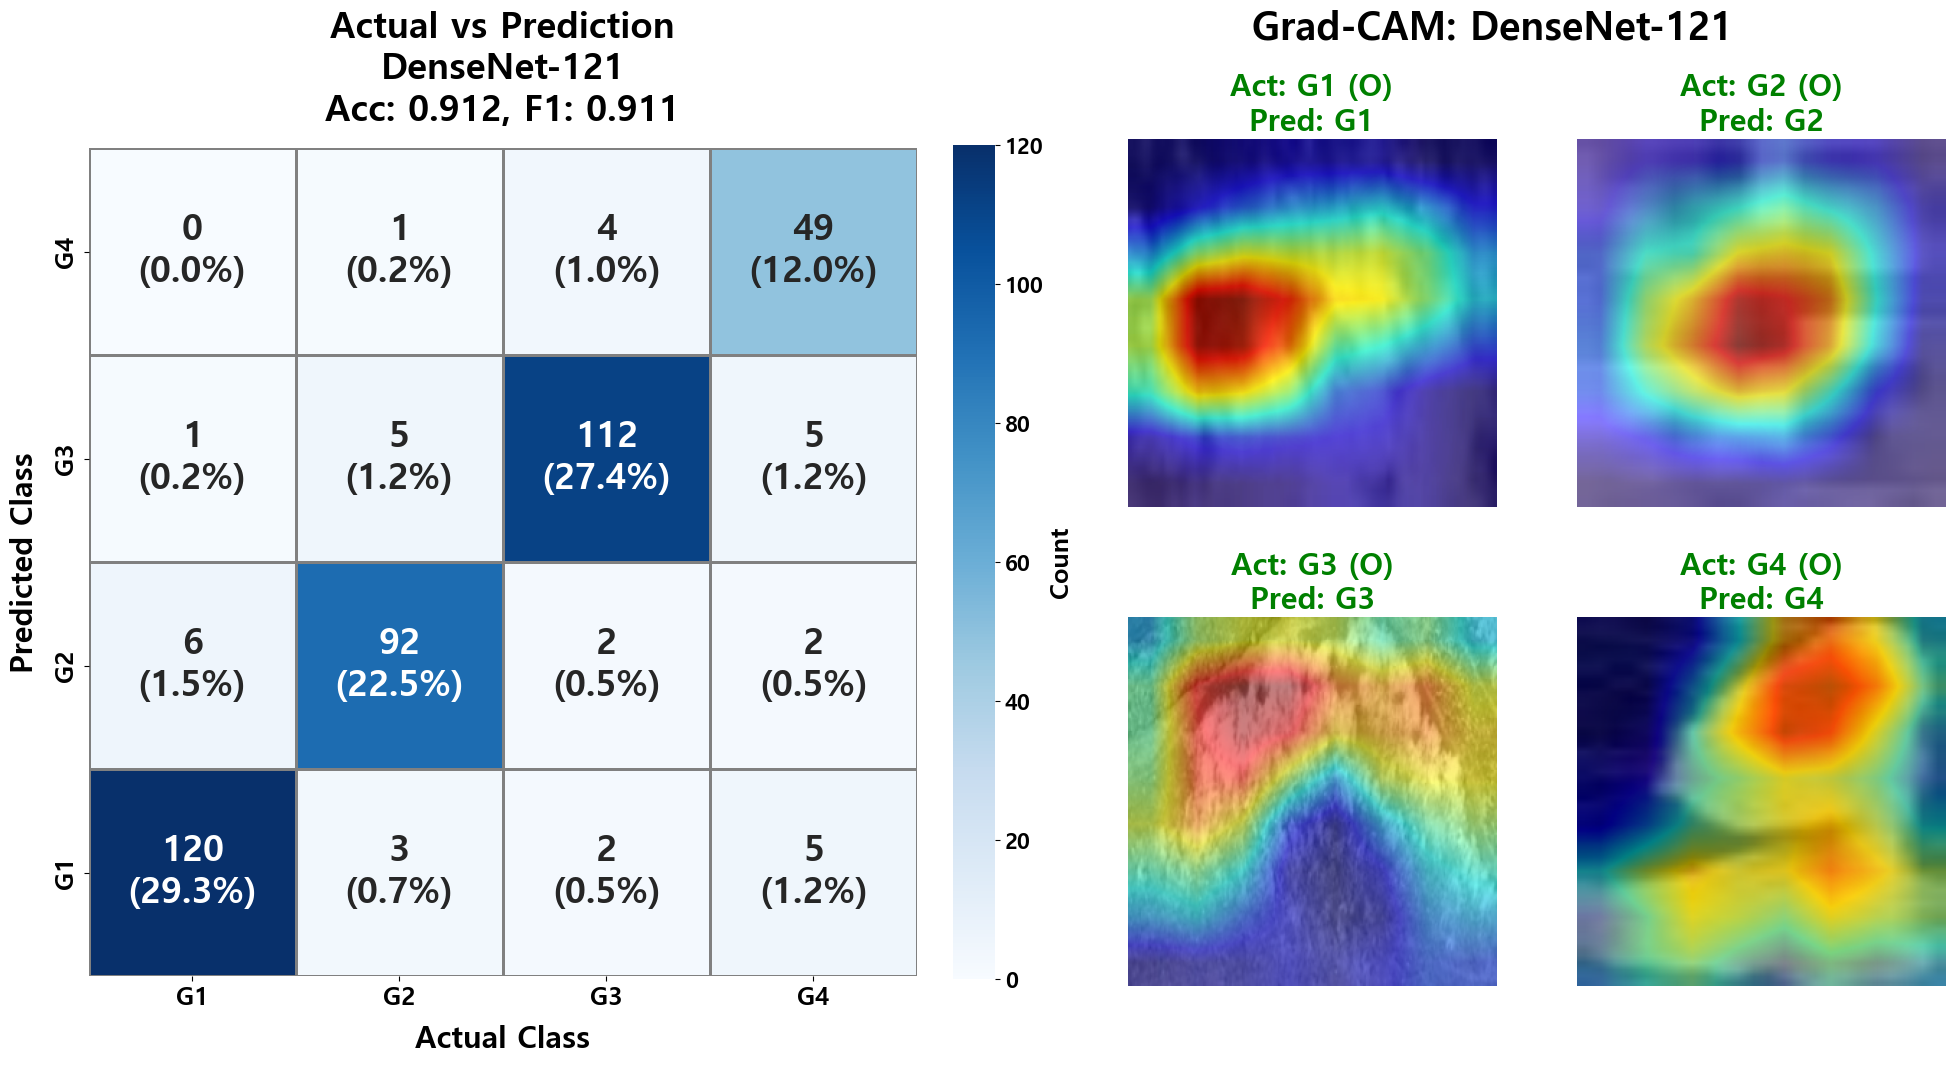

  >> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_final\DenseNet-121_CM_GradCAM.png
>> Processing: EfficientNet-B0...
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\EfficientNet-B0_final_best.pth


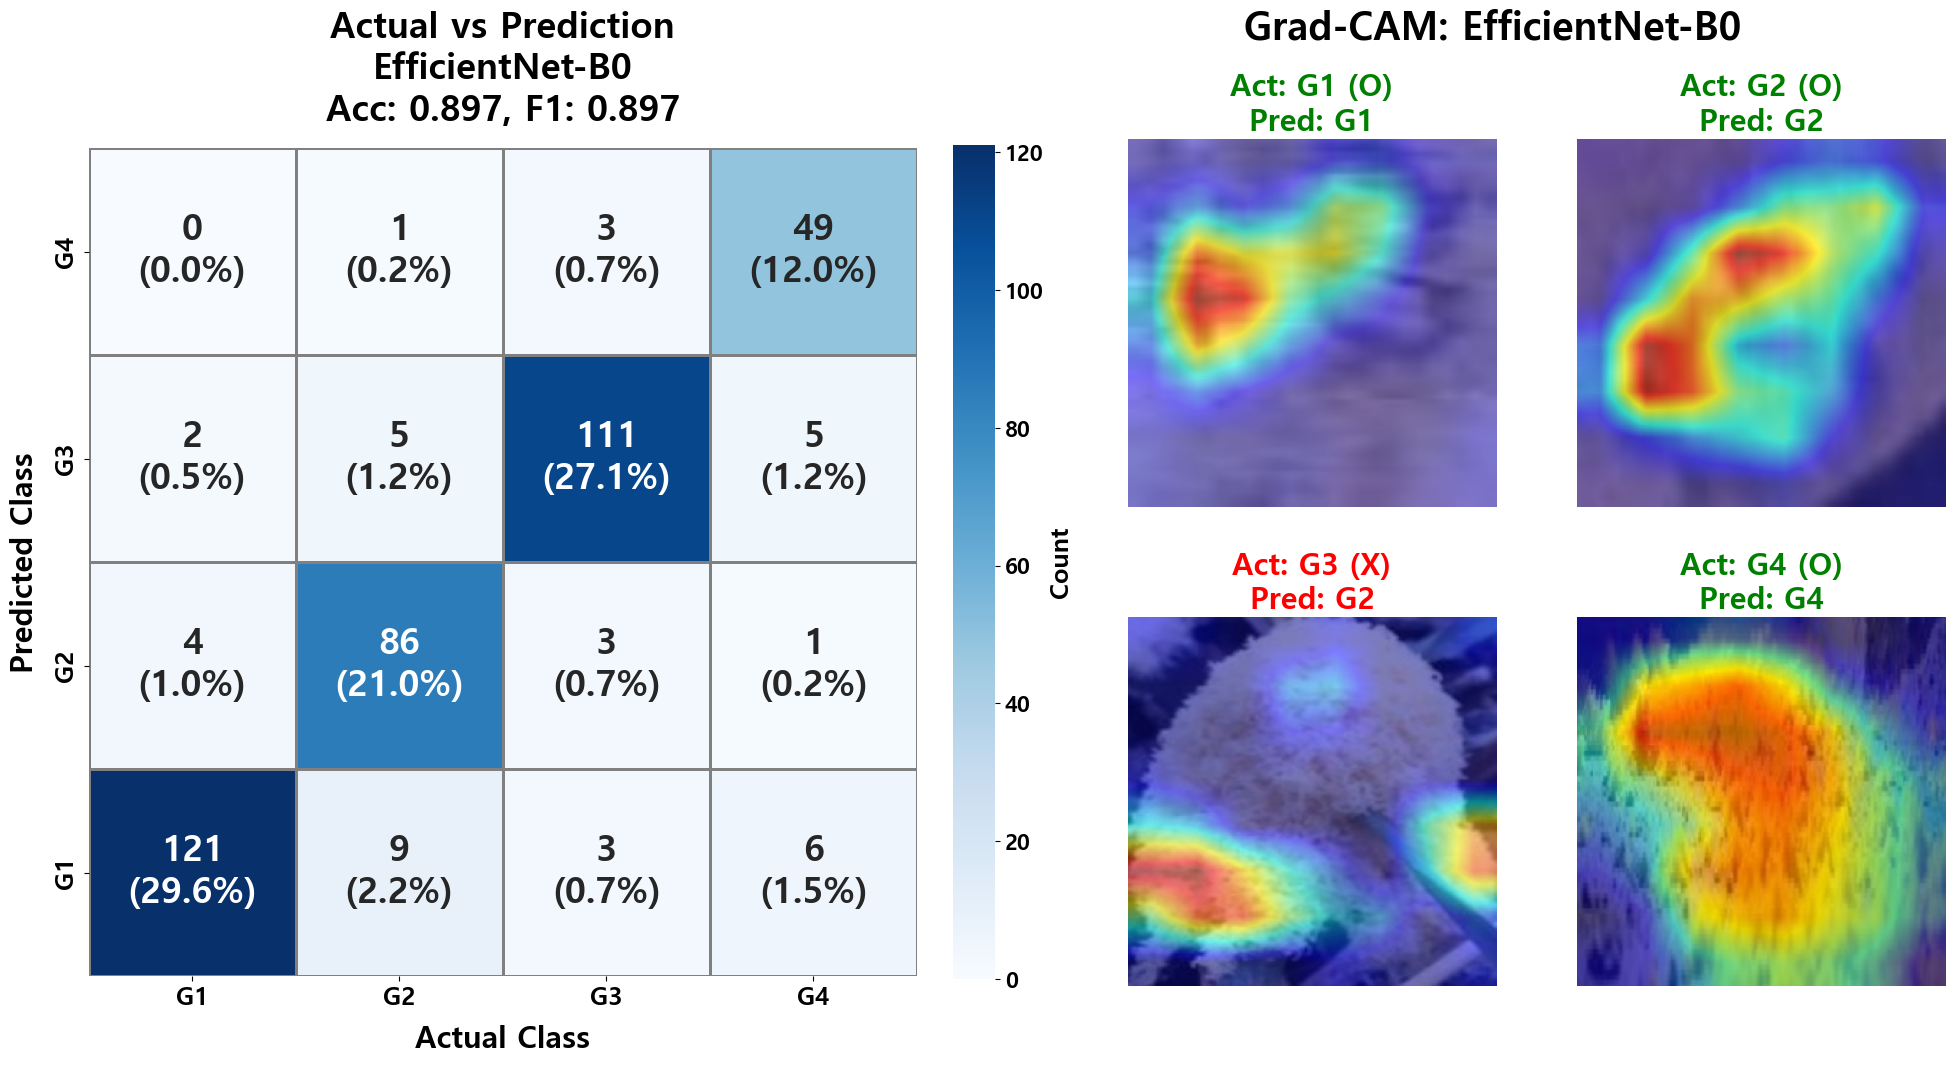

  >> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_final\EfficientNet-B0_CM_GradCAM.png
>> Processing: MobileNetV2...
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV2_final_best.pth


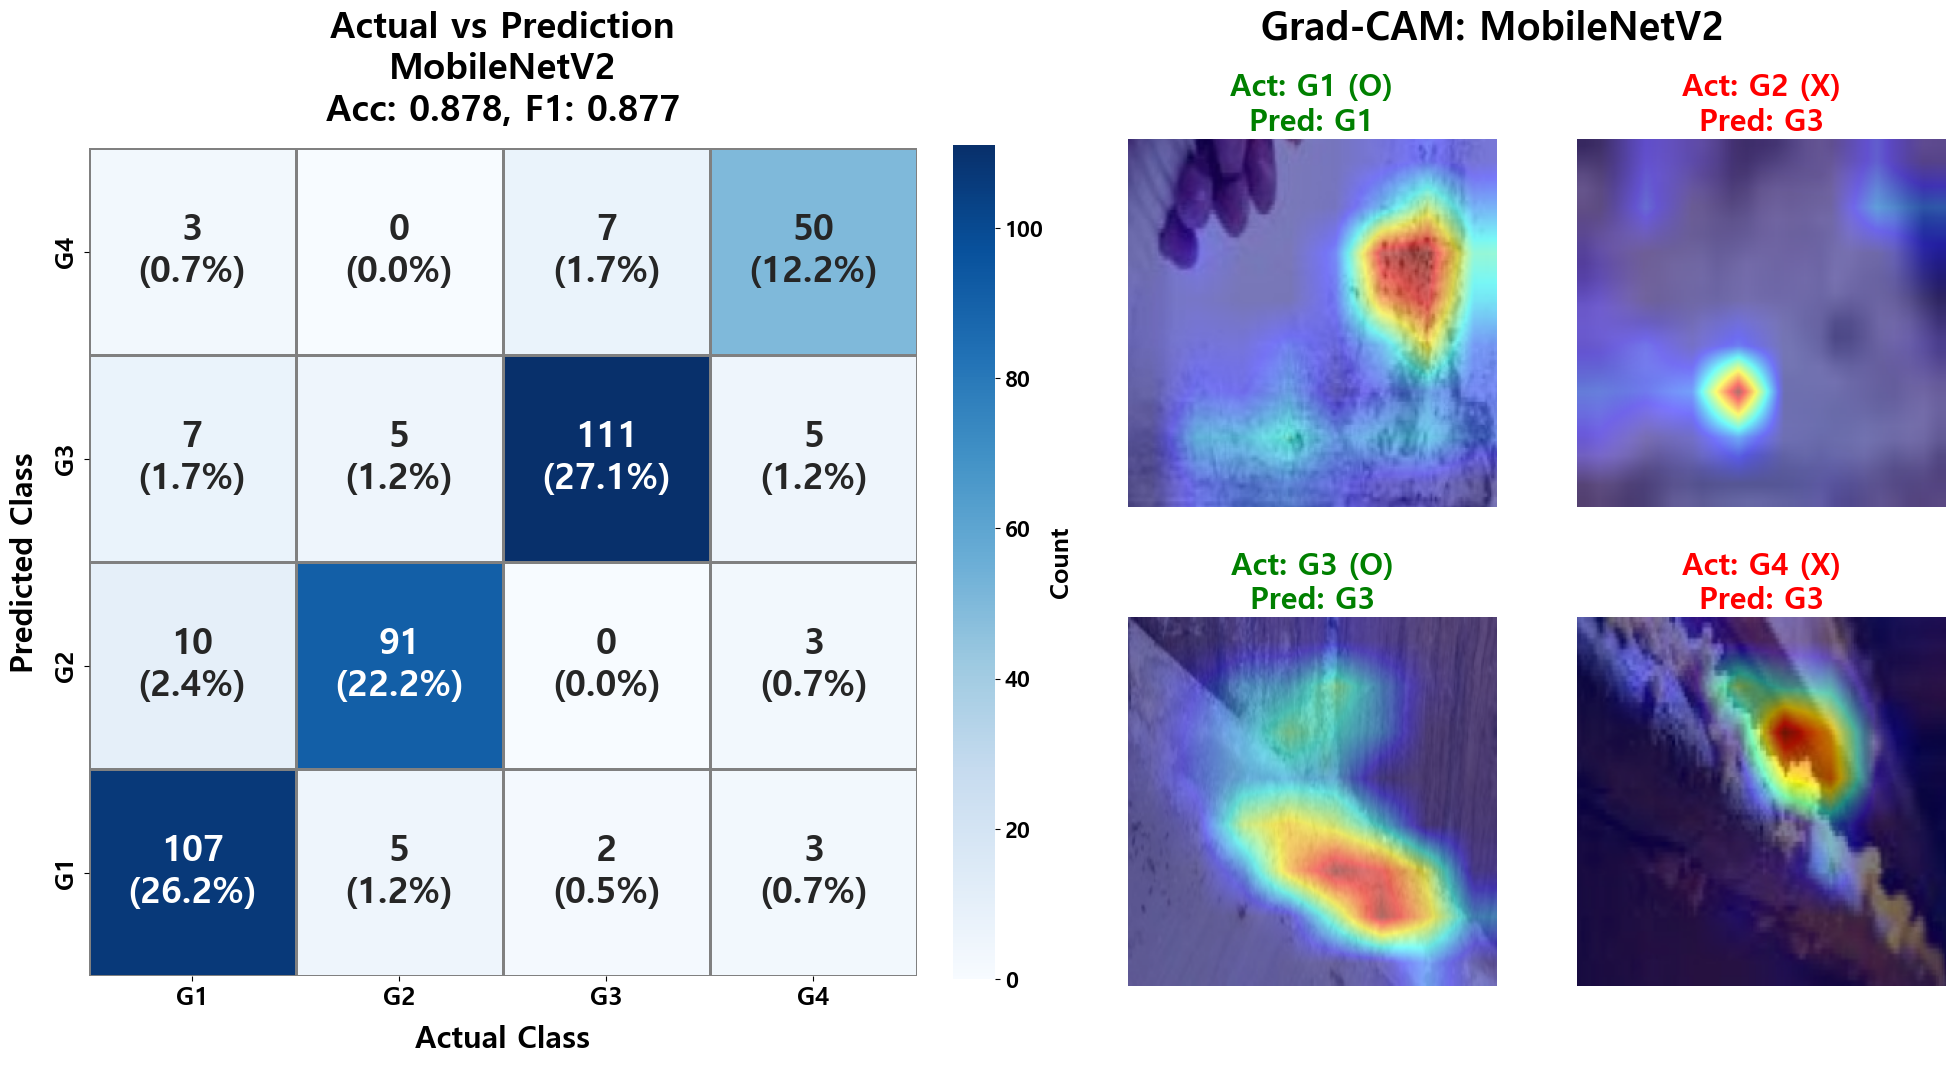

  >> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_final\MobileNetV2_CM_GradCAM.png
>> Processing: MobileNetV3-Small...
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV3-Small_final_best.pth


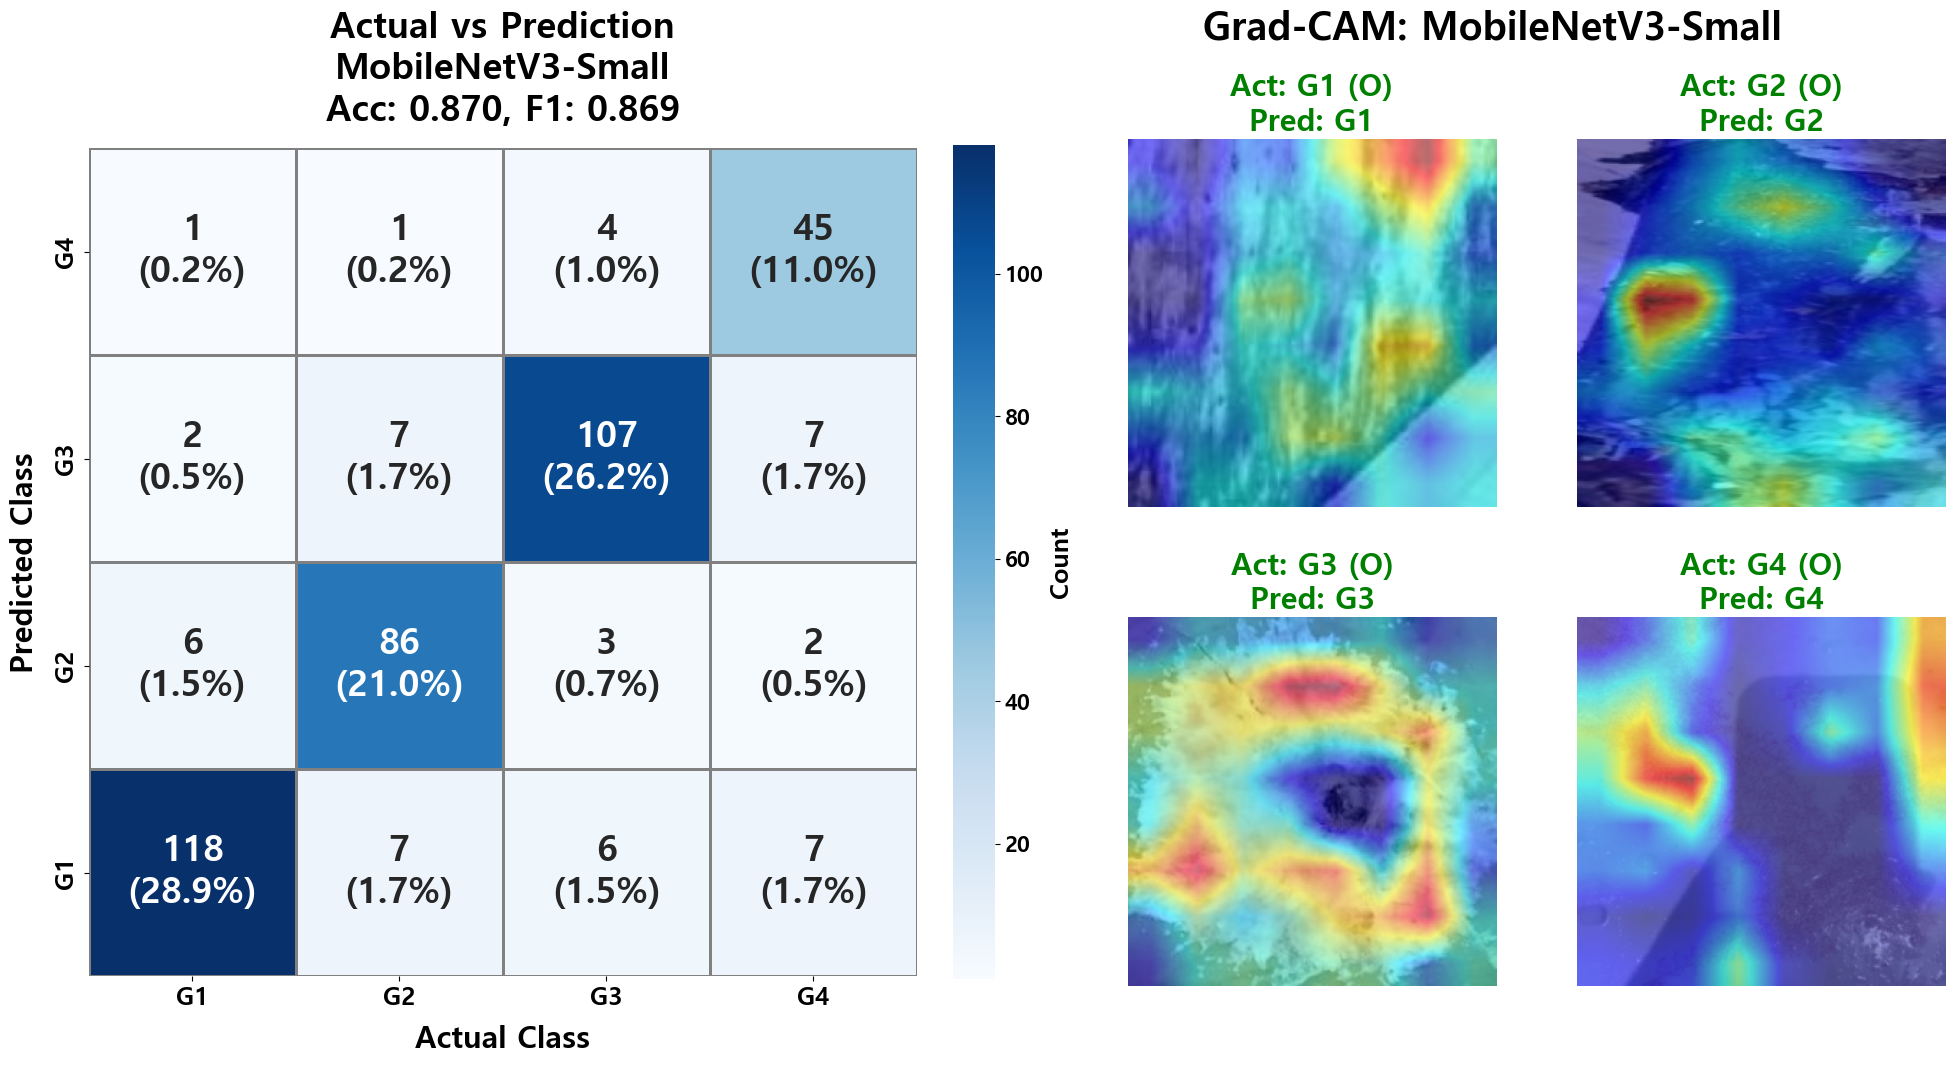

  >> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_final\MobileNetV3-Small_CM_GradCAM.png

>> 완료.


In [104]:
# -----------------------------------------------------------------------------
# 8. Confusion Matrix & Grad-CAM Visualization (스타일 완벽 복원)
# -----------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import torch.nn as nn
import os
import sys
import cv2
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from torchvision import models, transforms

# [Grad-CAM 라이브러리 체크]
try:
    from pytorch_grad_cam import GradCAM
    from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
    from pytorch_grad_cam.utils.image import show_cam_on_image
except ImportError:
    print("!! [경고] 'pytorch-grad-cam'이 없습니다. 시각화 일부가 생략될 수 있습니다.")
    GradCAM = None

# -----------------------------------------------------------------------------
# 0. 환경 설정 및 경로 정의
# -----------------------------------------------------------------------------
ROOT_DIR = os.getcwd()
RESULT_FINAL_DIR = os.path.join(ROOT_DIR, 'Result_final')
WEIGHTS_DIR = os.path.join(RESULT_FINAL_DIR, 'weights')

# 모델 목록 및 클래스
MODEL_NAMES = ['DenseNet-121', 'EfficientNet-B0', 'MobileNetV2', 'MobileNetV3-Small']
class_names = ['G1', 'G2', 'G3', 'G4'] # 클래스 이름 확인

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# -----------------------------------------------------------------------------
# 1. 모델 로드 및 구조 정의 함수
# -----------------------------------------------------------------------------
def get_model_structure(model_name, num_classes):
    if model_name == 'EfficientNet-B0':
        model = models.efficientnet_b0(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name == 'DenseNet-121':
        model = models.densenet121(weights=None)
        in_features = model.classifier.in_features
        model.classifier = nn.Linear(in_features, num_classes)
    elif model_name == 'MobileNetV2':
        model = models.mobilenet_v2(weights=None)
        in_features = model.classifier[1].in_features
        model.classifier[1] = nn.Linear(in_features, num_classes)
    elif model_name == 'MobileNetV3-Small':
        model = models.mobilenet_v3_small(weights=None)
        in_features = model.classifier[3].in_features
        model.classifier[3] = nn.Linear(in_features, num_classes)
    else:
        raise ValueError(f"Unknown model: {model_name}")
    return model

def load_model_for_eval(model_name):
    weight_path = os.path.join(WEIGHTS_DIR, f"{model_name}_final_best.pth")
    if not os.path.exists(weight_path):
        print(f"!! 가중치 없음: {weight_path}")
        return None
        
    print(f">> 로드 중: {weight_path}")
    model = get_model_structure(model_name, num_classes=len(class_names))
    try:
        model.load_state_dict(torch.load(weight_path, map_location=device))
    except Exception as e:
        print(f"!! 로드 실패 ({model_name}): {e}")
        return None
    model.to(device)
    model.eval()
    return model

# -----------------------------------------------------------------------------
# 2. 폰트 설정 (한글 깨짐 방지)
# -----------------------------------------------------------------------------
def ensure_korean_font():
    if sys.platform == 'win32':
        plt.rcParams['font.family'] = 'Malgun Gothic'
    elif sys.platform == 'darwin':
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        plt.rcParams['font.family'] = 'NanumGothic'
    plt.rcParams['axes.unicode_minus'] = False

# -----------------------------------------------------------------------------
# 3. 시각화 함수 (스타일 설정 완벽 반영)
# -----------------------------------------------------------------------------
def plot_confusion_matrix_and_gradcam(model, loader, model_name):
    ensure_korean_font()
    model.eval()
    
    # (1) 데이터 수집
    all_preds, all_targets = [], []
    all_images_list, all_labels_list = [], []
    
    with torch.no_grad():
        for imgs, lbls in loader:
            imgs_gpu = imgs.to(device)
            outputs = model(imgs_gpu)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(lbls.numpy())
            all_images_list.append(imgs)
            all_labels_list.append(lbls)
    
    cm = confusion_matrix(all_targets, all_preds)
    acc = accuracy_score(all_targets, all_preds)
    f1 = f1_score(all_targets, all_preds, average='weighted')
    
    # (2) Figure 생성 (24x11 inch)
    fig = plt.figure(figsize=(24, 11))
    gs = fig.add_gridspec(1, 2, width_ratios=[1.1, 1.0], hspace=0.3, wspace=0.15)
    
    # (3) [Left] Confusion Matrix
    ax_cm = fig.add_subplot(gs[0, 0])
    
    cm_T = cm.T # Transpose
    total = cm.sum()
    annot_arr = np.empty_like(cm_T, dtype=object)
    for i in range(cm_T.shape[0]):
        for j in range(cm_T.shape[1]):
            c = cm_T[i, j]
            p = 100.0 * c / total if total > 0 else 0
            annot_arr[i, j] = f"{c}\n({p:.1f}%)"
            
    # Flip for heatmap
    cm_flip = np.flipud(cm_T)
    annot_flip = np.flipud(annot_arr)
    
    # [스타일 핵심] 폰트 크기 및 컬러바 높이 조절
    sns.heatmap(cm_flip, annot=annot_flip, fmt='', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names[::-1],
                cbar_kws={'label': 'Count', "fraction": 0.046, "pad": 0.04}, # 높이 맞춤
                linewidths=1.0, linecolor='gray', square=True,
                annot_kws={'fontsize': 26, 'fontweight': 'bold'}, # 숫자 폰트 26pt
                ax=ax_cm)
    
    # 제목 및 축 라벨 (대형 폰트)
    ax_cm.set_title(f'Actual vs Prediction\n{model_name}\nAcc: {acc:.3f}, F1: {f1:.3f}', 
                    fontsize=26, fontweight='bold', pad=20)
    ax_cm.set_xlabel('Actual Class', fontsize=22, fontweight='bold', labelpad=10)
    ax_cm.set_ylabel('Predicted Class', fontsize=22, fontweight='bold', labelpad=10)
    ax_cm.tick_params(axis='both', labelsize=18) # 눈금 18pt
    
    # 컬러바 폰트 설정
    cbar = ax_cm.collections[0].colorbar
    cbar.ax.tick_params(labelsize=16)
    cbar.set_label('Count', fontsize=18, fontweight='bold')
    
    # (4) [Right] Grad-CAM
    gs_right = gs[0, 1].subgridspec(2, 2, hspace=0.3, wspace=0.2)
    
    if GradCAM:
        # 타겟 레이어 자동 감지
        target_layers = []
        if 'efficient' in model_name.lower(): target_layers = [model.features[-1]]
        elif 'dense' in model_name.lower(): target_layers = [model.features[-1]]
        elif 'mobile' in model_name.lower(): target_layers = [model.features[-1]]
        else:
            try: target_layers = [list(model.children())[-2][-1]] 
            except: pass

        if target_layers:
            try:
                cam = GradCAM(model=model, target_layers=target_layers)
                all_images = torch.cat(all_images_list, dim=0)
                all_labels = torch.cat(all_labels_list, dim=0)
                
                for idx, c_name in enumerate(class_names):
                    c_indices = (all_labels == idx).nonzero(as_tuple=True)[0]
                    if len(c_indices) == 0: continue
                    sel_idx = c_indices[np.random.randint(len(c_indices))]
                    
                    img_t = all_images[sel_idx].unsqueeze(0).to(device)
                    true_lbl = all_labels[sel_idx].item()
                    
                    with torch.no_grad():
                        out = model(img_t)
                        pred_lbl = torch.argmax(out, 1).item()
                        
                    gray_cam = cam(input_tensor=img_t, targets=[ClassifierOutputTarget(true_lbl)])[0, :]
                    
                    # 역정규화
                    img_np = all_images[sel_idx].cpu().numpy().transpose(1, 2, 0)
                    img_np = (img_np * [0.229, 0.224, 0.225]) + [0.485, 0.456, 0.406]
                    img_np = np.clip(img_np, 0, 1)
                    
                    viz = show_cam_on_image(img_np, gray_cam, use_rgb=True)
                    
                    r, c = divmod(idx, 2)
                    ax = fig.add_subplot(gs_right[r, c])
                    ax.imshow(viz)
                    
                    # [스타일] 제목 폰트 및 OX 표시
                    correct = (true_lbl == pred_lbl)
                    color = 'green' if correct else 'red'
                    mark = '(O)' if correct else '(X)'
                    
                    ax.set_title(f"Act: {class_names[true_lbl]} {mark}\nPred: {class_names[pred_lbl]}", 
                                 fontsize=22, fontweight='bold', color=color) # 22pt Bold
                    ax.axis('off')
                
                # 전체 Grad-CAM 제목 (28pt)
                fig.text(0.71, 0.97, f'Grad-CAM: {model_name}', ha='center', fontsize=28, fontweight='bold')
                
            except Exception as e:
                print(f"!! Grad-CAM Error: {e}")

    # 저장
    save_path = os.path.join(RESULT_FINAL_DIR, f"{model_name}_CM_GradCAM.png")
    plt.savefig(save_path, dpi=200, bbox_inches='tight')
    plt.show()
    print(f"  >> 저장 완료: {save_path}")

# --- 실행 ---
if 'test_loader' in locals():
    print("\n" + "="*80)
    print(">> [8. Visualization] Confusion Matrix & Grad-CAM")
    print("="*80)
    for m_name in MODEL_NAMES:
        print(f">> Processing: {m_name}...")
        mod = load_model_for_eval(m_name)
        if mod: plot_confusion_matrix_and_gradcam(mod, test_loader, m_name)
    print("\n>> 완료.")
else:
    print("!! test_loader가 정의되지 않았습니다.")


>> [9. Analysis] Phase Diagram & Validity Threshold (Cell10 Format Applied)

--------------------------------------------------------------------------------
>> Processing: DenseNet-121
--------------------------------------------------------------------------------
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\DenseNet-121_final_best.pth
   >> VT 재산출 중... (Peak - 3.0σ 방식)
   >> VT=62.40% (from Beta, Peak-3.0σ) | valid_rate=90.7% | target_cdf=0.093
   >> extract_features_for_phase: features=(409, 4), targets=(409,)
>> Phase Diagram + Valid Threshold 그래프 생성 중...


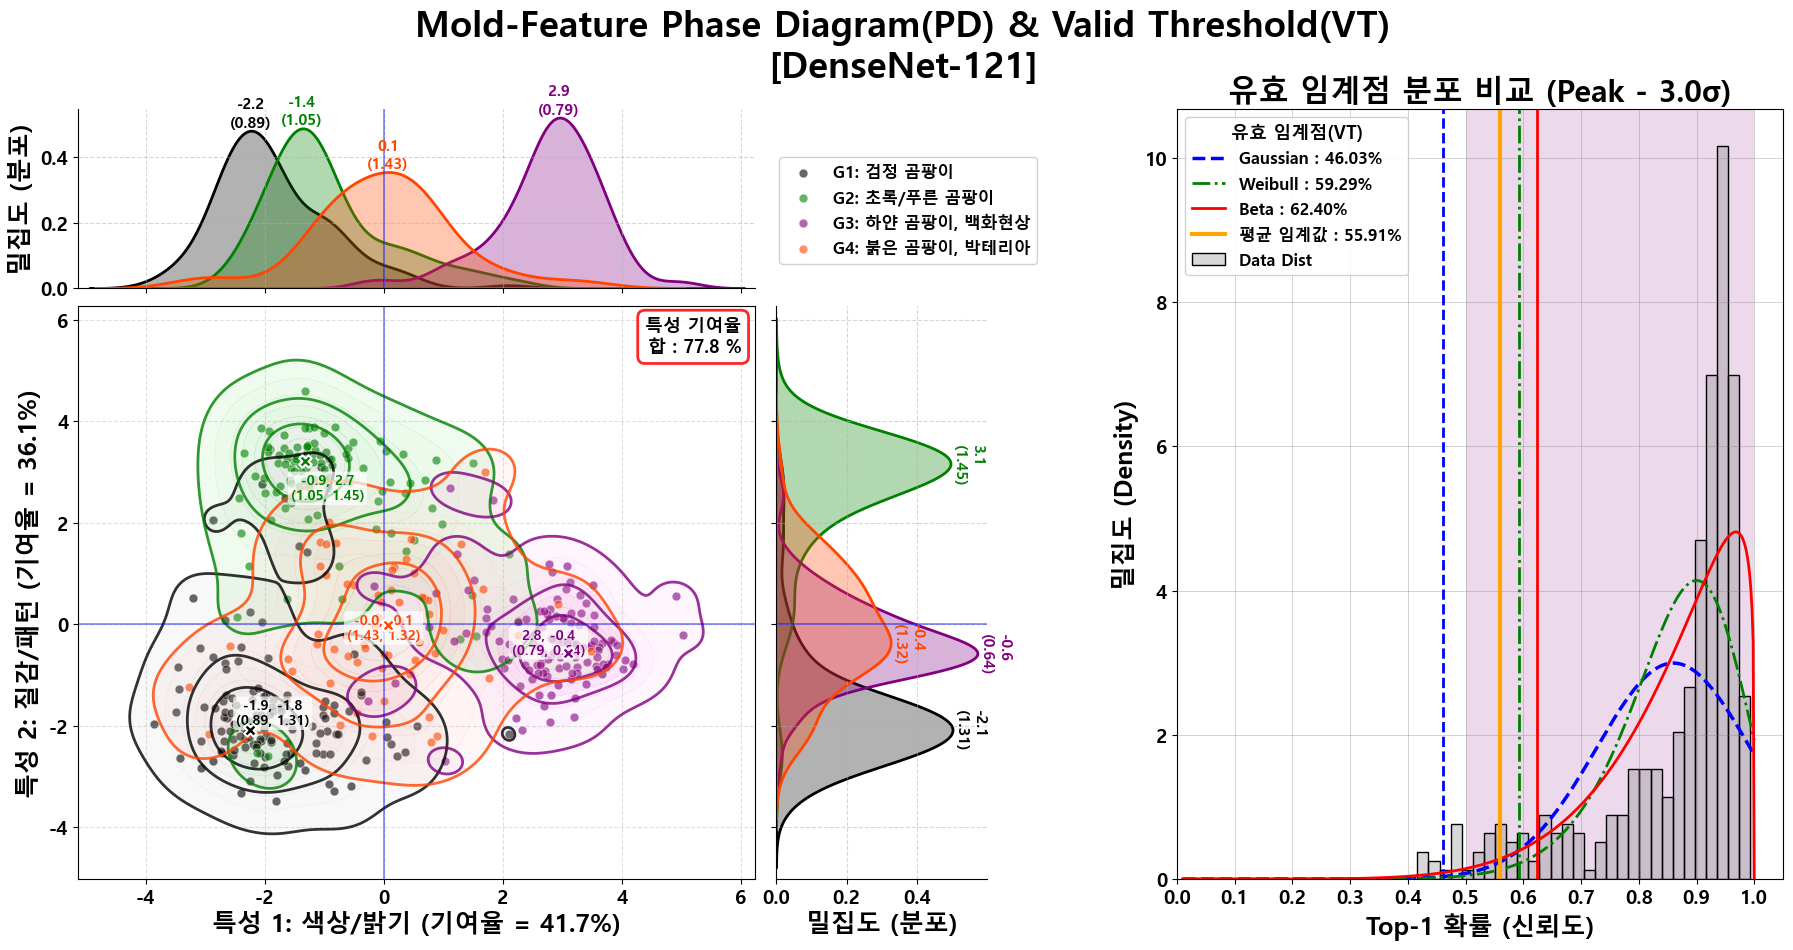

>> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\DenseNet-121\DenseNet-121_Phase_and_Threshold.png
>> [CSV] Threshold 값 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\DenseNet-121\DenseNet-121_Validity_Thresholds.csv
          Distribution  Threshold  Percentile_Used
0          Mean(G/W/B)   0.559063              NaN
1          VT_Selected   0.623992          0.09291
2  Gaussian(mode-3.0σ)   0.460319              NaN
3   Weibull(mode-3.0σ)   0.592879              NaN
4      Beta(mode-3.0σ)   0.623992              NaN
>> Mean(G/W/B) Threshold = 55.91%

--------------------------------------------------------------------------------
>> Processing: EfficientNet-B0
--------------------------------------------------------------------------------
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\EfficientNet-B0_final_best.pth
   >> VT 재산출 중... (Peak - 3.0σ 방식)
   >> VT=61.37% (from Beta, Peak-3.0σ) | valid_rate=91.0% | target_cdf=0.090
   >> extract

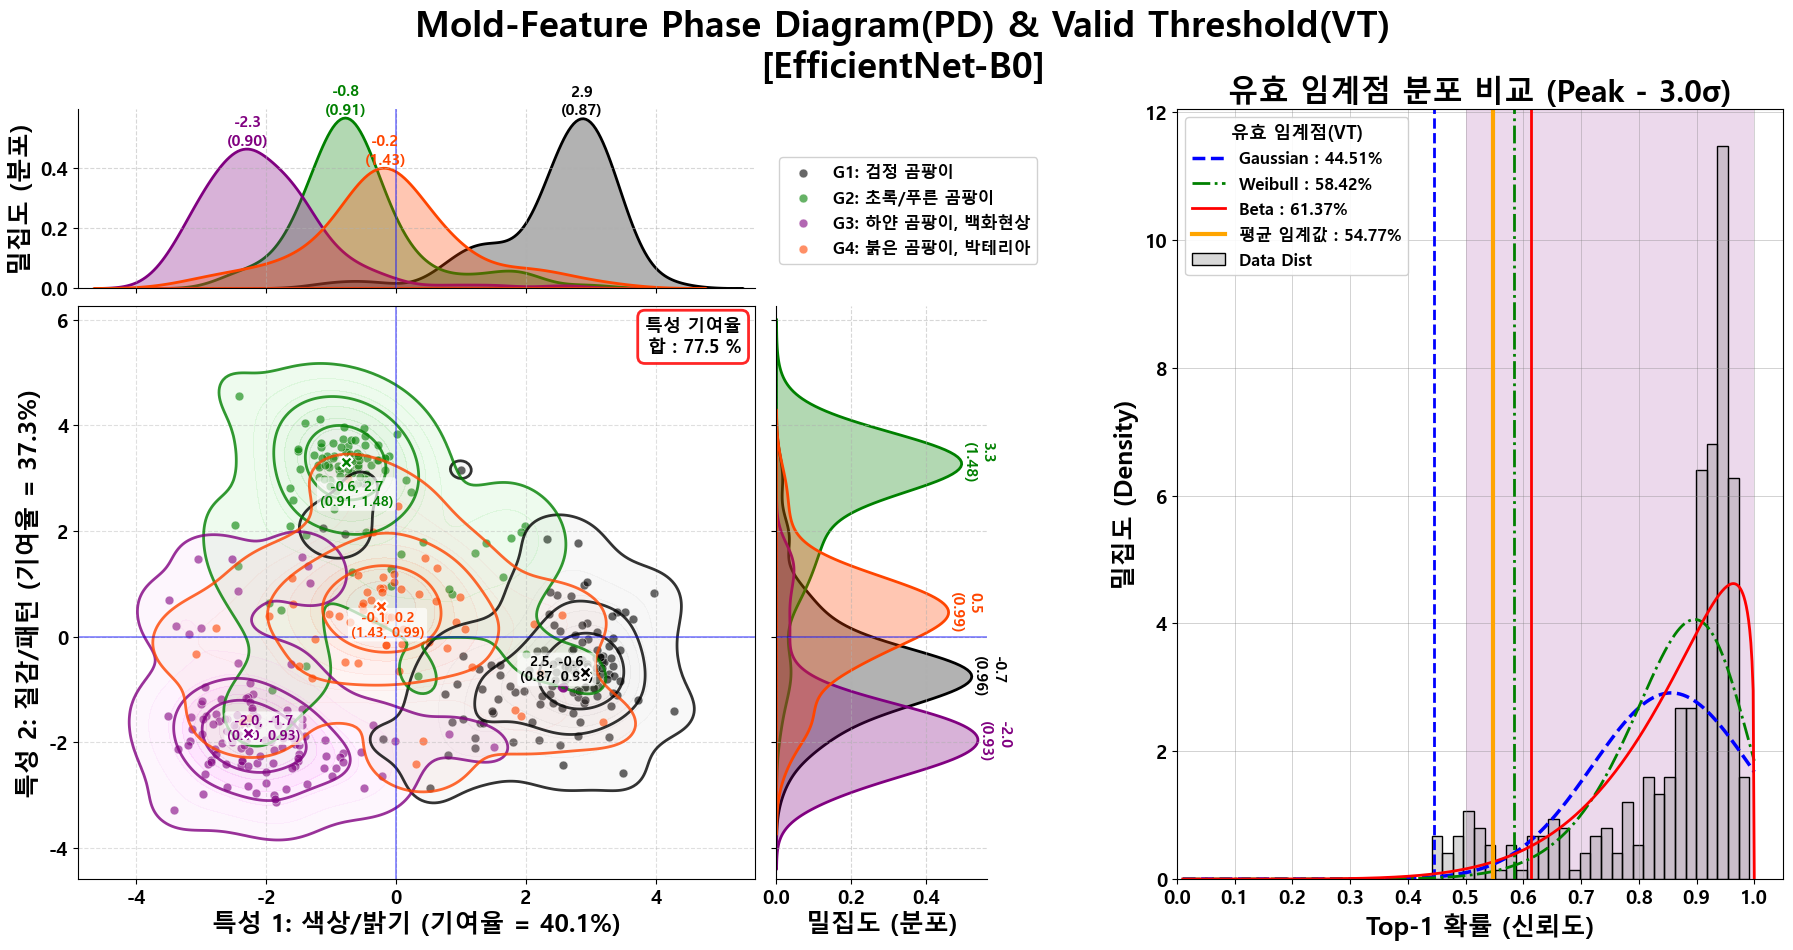

>> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\EfficientNet-B0\EfficientNet-B0_Phase_and_Threshold.png
>> [CSV] Threshold 값 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\EfficientNet-B0\EfficientNet-B0_Validity_Thresholds.csv
          Distribution  Threshold  Percentile_Used
0          Mean(G/W/B)   0.547681              NaN
1          VT_Selected   0.613706         0.090465
2  Gaussian(mode-3.0σ)   0.445121              NaN
3   Weibull(mode-3.0σ)   0.584216              NaN
4      Beta(mode-3.0σ)   0.613706              NaN
>> Mean(G/W/B) Threshold = 54.77%

--------------------------------------------------------------------------------
>> Processing: MobileNetV2
--------------------------------------------------------------------------------
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV2_final_best.pth
   >> VT 재산출 중... (Peak - 3.0σ 방식)
   >> VT=55.56% (from Beta, Peak-3.0σ) | valid_rate=90.5% | target_cdf=0.095
   >> ext

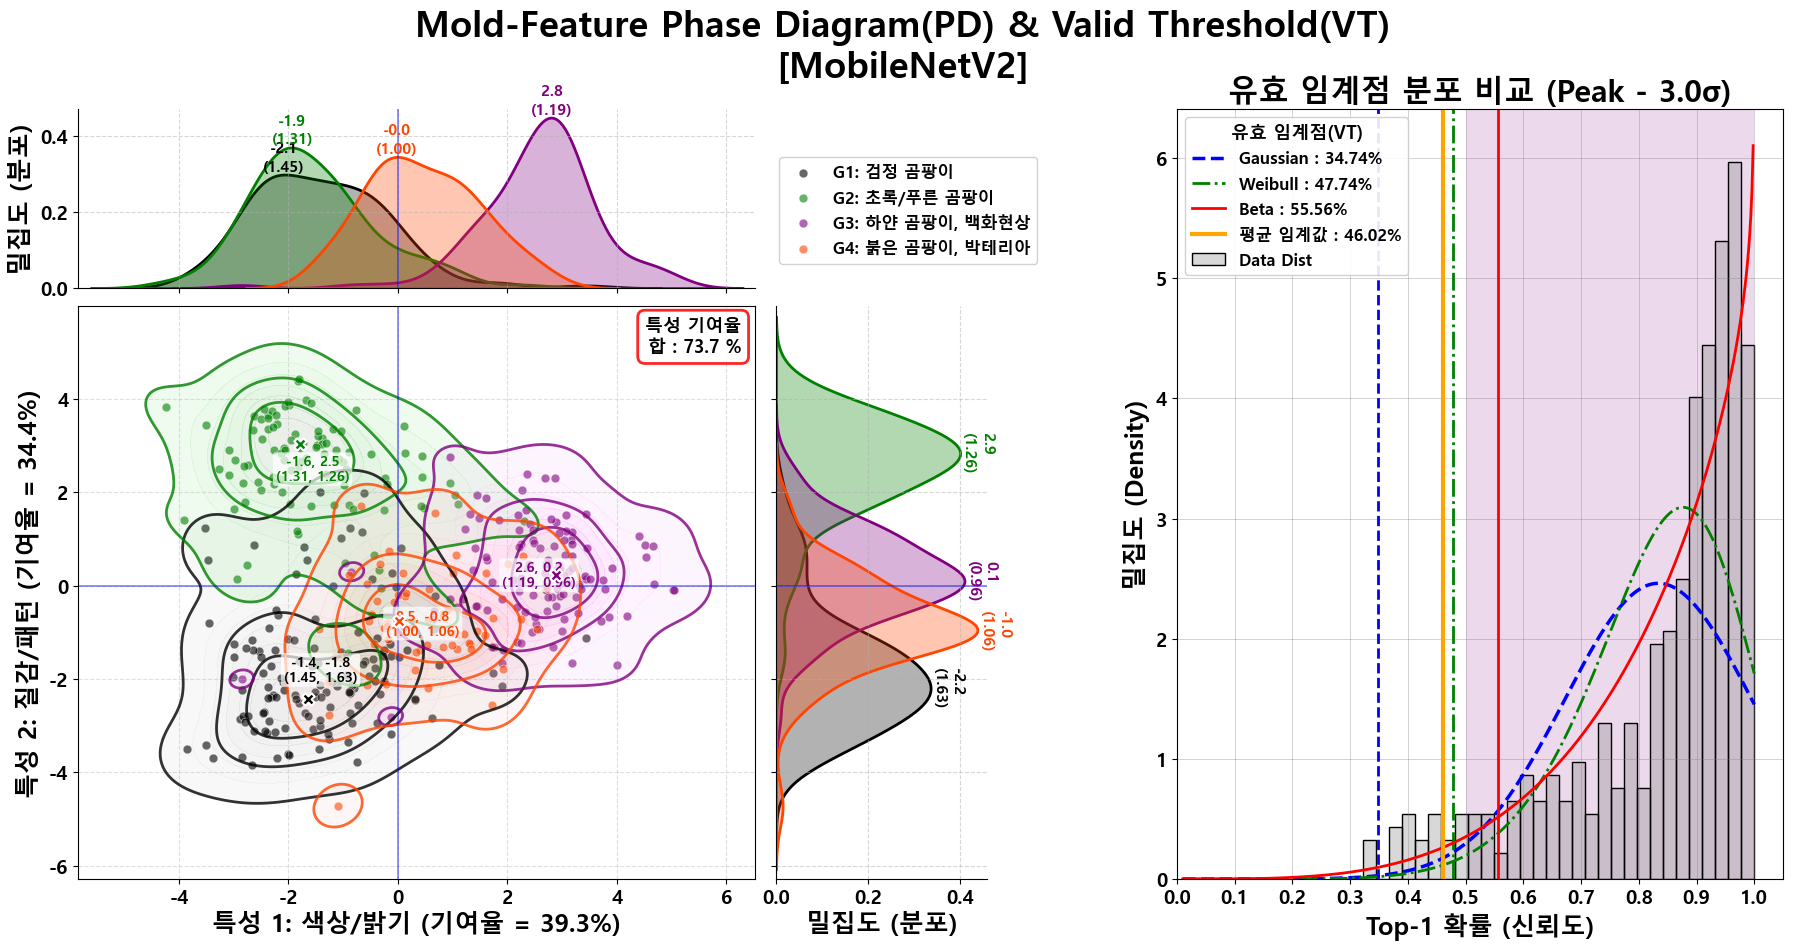

>> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\MobileNetV2\MobileNetV2_Phase_and_Threshold.png
>> [CSV] Threshold 값 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\MobileNetV2\MobileNetV2_Validity_Thresholds.csv
          Distribution  Threshold  Percentile_Used
0          Mean(G/W/B)   0.460172              NaN
1          VT_Selected   0.555645         0.095355
2  Gaussian(mode-3.0σ)   0.347427              NaN
3   Weibull(mode-3.0σ)   0.477443              NaN
4      Beta(mode-3.0σ)   0.555645              NaN
>> Mean(G/W/B) Threshold = 46.02%

--------------------------------------------------------------------------------
>> Processing: MobileNetV3-Small
--------------------------------------------------------------------------------
>> 로드 중: c:\yssong\Mid_project\Mold-Pang_final\Result_final\weights\MobileNetV3-Small_final_best.pth
   >> VT 재산출 중... (Peak - 3.0σ 방식)
   >> VT=52.97% (from Beta, Peak-3.0σ) | valid_rate=91.7% | target_cdf=0.083
   >> extract

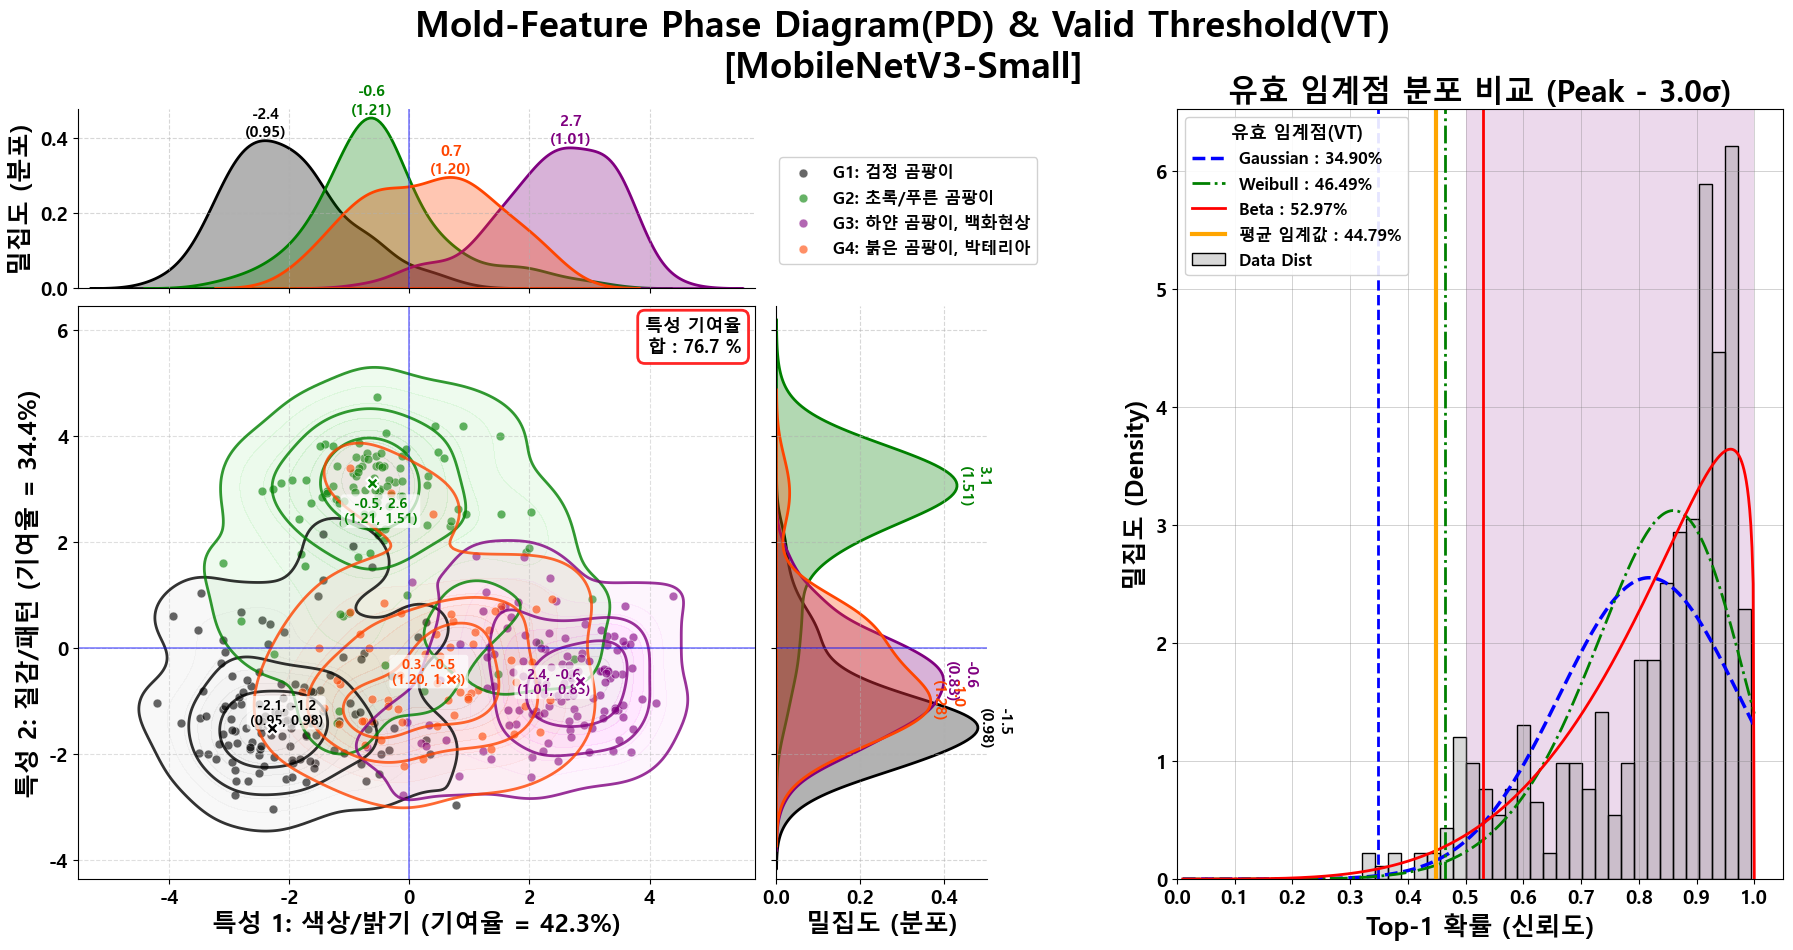

>> 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\MobileNetV3-Small\MobileNetV3-Small_Phase_and_Threshold.png
>> [CSV] Threshold 값 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result_toward\MobileNetV3-Small\MobileNetV3-Small_Validity_Thresholds.csv
          Distribution  Threshold  Percentile_Used
0          Mean(G/W/B)   0.447869              NaN
1          VT_Selected   0.529679          0.08313
2  Gaussian(mode-3.0σ)   0.349020              NaN
3   Weibull(mode-3.0σ)   0.464906              NaN
4      Beta(mode-3.0σ)   0.529679              NaN
>> Mean(G/W/B) Threshold = 44.79%

>> 완료.


In [105]:
# =========================================================
# [FULL PATCH] Peak - alpha_const*sigma 방식 VT + Plot + Run
# =========================================================

# -------------------------
# 0) Imports (누락 방지)
# -------------------------
import os
import numpy as np
import pandas as pd

import torch
import matplotlib.pyplot as plt
from matplotlib import gridspec

import seaborn as sns
from sklearn.decomposition import PCA
from scipy.stats import gaussian_kde
from scipy.stats import norm, beta as beta_dist, weibull_min



# -------------------------
# 1) Global Config (안전 기본값)
# -------------------------
# ✅ alpha_const 한 곳에서만 관리
ALPHA_CONST = 3.0   # peak - 1.5*sigma

# ✅ Result 저장 폴더 기본값 (이미 다른 셀에 정의돼있으면 그걸 유지)
if "BASE_RESULT_DIR" not in globals():
    BASE_RESULT_DIR = "./Result"
os.makedirs(BASE_RESULT_DIR, exist_ok=True)

# ✅ 색상/라벨 기본값 (이미 있으면 기존값 유지)
if "COLORS" not in globals():
    COLORS = [
        "tab:blue","tab:orange","tab:green","tab:red","tab:purple",
        "tab:brown","tab:pink","tab:gray","tab:olive","tab:cyan"
    ]
if "CUSTOM_LABELS" not in globals():
    CUSTOM_LABELS = {}  # 없으면 원래 class_names 사용


# -------------------------
# 2) Feature/Target 추출 함수 (없어서 에러났던 부분)
# -------------------------
def extract_features_for_phase(model, loader, device, feature_layer_name=None):
    """
    Phase Diagram용 feature + target 추출.

    반환:
      features_np: (N, D)  float32
      targets_np:  (N,)    int64

    기본: logits(출력)을 feature로 사용 (가장 안정적으로 동작)
    """
    model.eval()
    feats, targs = [], []

    hook_handle = None
    hooked = {"out": None}

    def _hook_fn(module, inp, out):
        if isinstance(out, (tuple, list)):
            out = out[0]
        hooked["out"] = out

    if feature_layer_name is not None:
        found = False
        for name, m in model.named_modules():
            if name == feature_layer_name:
                hook_handle = m.register_forward_hook(_hook_fn)
                found = True
                break
        if not found:
            print(f"!! feature_layer_name='{feature_layer_name}' 레이어를 못 찾음 -> logits로 대체")
            feature_layer_name = None

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            labels = labels.to(device)

            out = model(imgs)  # logits 기대

            if feature_layer_name is None:
                f = out
            else:
                f = hooked["out"]
                if f is None:
                    f = out

            if f.dim() > 2:
                f = torch.flatten(f, start_dim=1)

            feats.append(f.detach().cpu())
            targs.append(labels.detach().cpu())

    if hook_handle is not None:
        hook_handle.remove()

    features_np = torch.cat(feats, dim=0).numpy().astype(np.float32)
    targets_np  = torch.cat(targs, dim=0).numpy().astype(np.int64)

    print(f"   >> extract_features_for_phase: features={features_np.shape}, targets={targets_np.shape}")
    return features_np, targets_np


# -------------------------
# 3) VT 계산 함수 (Peak - alpha_const*sigma)
# -------------------------
def calculate_conservative_threshold_v2(model, loader, device, class_names, alpha_const=ALPHA_CONST):
    """
    VT = peak(mode) - alpha_const*sigma  (Peak - aσ)
    - 피팅 대상: all Top-1 probs
    - Gaussian/Weibull/Beta 각각 mode & sigma 계산 → threshold 산출
    - 최종 VT는 (가능하면) Weibull, 그 다음 Beta, 그 다음 Gaussian 순으로 선택

    반환:
      vt, all_probs, mu_all, sigma_all, target_cdf, extra(dict)
    """
    print(f"   >> VT 재산출 중... (Peak - {alpha_const}σ 방식)")
    model.eval()

    all_probs = []

    with torch.no_grad():
        for imgs, labels in loader:
            imgs = imgs.to(device)
            outputs = model(imgs)
            probs = torch.softmax(outputs, dim=1)
            max_vals, _ = torch.max(probs, dim=1)
            all_probs.extend(max_vals.detach().cpu().numpy().tolist())

    all_probs = np.array(all_probs, dtype=float)

    # 안전장치
    if len(all_probs) < 10:
        vt = 0.5
        mu_all = float(np.mean(all_probs)) if len(all_probs) else 0.5
        sigma_all = float(np.std(all_probs) + 1e-9) if len(all_probs) else 0.1
        target_cdf = float((all_probs <= vt).mean()) if len(all_probs) else 0.5
        extra = {"VT_Selected": {"vt": vt, "from": "Fallback", "target_cdf": target_cdf}}
        return vt, all_probs, mu_all, sigma_all, target_cdf, extra

    # 전체 분포(경험적) 평균/표준편차 (참고용)
    mu_all = float(np.mean(all_probs))
    sigma_all = float(np.std(all_probs) + 1e-9)

    # Beta 안정화
    x = np.clip(all_probs, 1e-6, 1 - 1e-6)

    extra = {}

    # -------------------------
    # 1) Gaussian: mode = mu
    # -------------------------
    g_mode = mu_all
    g_sigma = sigma_all
    g_th = float(np.clip(g_mode - alpha_const * g_sigma, 0.0, 1.0))
    extra["Gaussian"] = {"mode": g_mode, "sigma": g_sigma, "th": g_th}

    # -------------------------
    # 2) Weibull: mode 계산
    # -------------------------
    w_th = np.nan
    try:
        k, loc, scale = weibull_min.fit(all_probs, floc=0)
        w_mean, w_var = weibull_min.stats(k, loc=loc, scale=scale, moments='mv')
        w_sigma = float(np.sqrt(w_var))
        if k > 1:
            w_mode = float(loc + scale * ((k - 1.0) / k) ** (1.0 / k))
        else:
            w_mode = float(loc)
        w_th = float(np.clip(w_mode - alpha_const * w_sigma, 0.0, 1.0))
        extra["Weibull"] = {
            "k": float(k), "loc": float(loc), "scale": float(scale),
            "mode": w_mode, "sigma": w_sigma, "th": w_th
        }
    except Exception as e:
        extra["Weibull"] = {"error": str(e)}

    # -------------------------
    # 3) Beta: mode 계산
    # -------------------------
    b_th = np.nan
    try:
        a, b, loc_b, scale_b = beta_dist.fit(x, floc=0, fscale=1)
        b_mean, b_var = beta_dist.stats(a, b, loc=loc_b, scale=scale_b, moments='mv')
        b_sigma = float(np.sqrt(b_var))

        if a > 1 and b > 1:
            b_mode = float((a - 1.0) / (a + b - 2.0))
        elif a <= 1 and b > 1:
            b_mode = 0.0
        elif a > 1 and b <= 1:
            b_mode = 1.0
        else:
            b_mode = 0.0

        b_th = float(np.clip(b_mode - alpha_const * b_sigma, 0.0, 1.0))
        extra["Beta"] = {"a": float(a), "b": float(b), "mode": b_mode, "sigma": b_sigma, "th": b_th}
    except Exception as e:
        extra["Beta"] = {"error": str(e)}

    # -------------------------
    # ✅ 최종 VT 선택 (Beta 고정)
    # -------------------------
    if not np.isnan(b_th):
        vt = float(b_th)
        vt_from = "Beta"
    elif not np.isnan(w_th):
        vt = float(w_th)
        vt_from = "Weibull"
    else:
        vt = float(g_th)
        vt_from = "Gaussian"

    target_cdf = float((all_probs <= vt).mean())
    valid_rate = float((all_probs >= vt).mean())

    print(f"   >> VT={vt*100:.2f}% (from {vt_from}, Peak-{alpha_const}σ) | "
          f"valid_rate={valid_rate*100:.1f}% | target_cdf={target_cdf:.3f}")

    return vt, all_probs, mu_all, sigma_all, target_cdf, extra


# -------------------------
# 4) Plot 함수 (alpha_const 표시/CSV 표시 개선)
# -------------------------
def plot_phase_and_threshold(features, targets, top1_probs,
                             vt, mu, sigma, target_cdf, extra,
                             class_names, save_dir, model_name, alpha_const=ALPHA_CONST):
    print(">> Phase Diagram + Valid Threshold 그래프 생성 중...")

    fig = plt.figure(figsize=(22, 10))
    outer = gridspec.GridSpec(1, 2, width_ratios=[1.2, 0.8], wspace=0.25)

    # ===== Left: Phase Diagram =====
    left = outer[0].subgridspec(4, 4, wspace=0.1, hspace=0.1)
    ax_main = fig.add_subplot(left[1:4, 0:3])
    ax_top = fig.add_subplot(left[0, 0:3], sharex=ax_main)
    ax_right = fig.add_subplot(left[1:4, 3], sharey=ax_main)

    # PCA
    pca = PCA(n_components=2)
    projected = pca.fit_transform(features)
    var_ratio = pca.explained_variance_ratio_

    # 축 의미 자동 해석 (Cell10 방식)
    g1_idx = [i for i, x in enumerate(class_names) if 'G1' in x][0] if any('G1' in x for x in class_names) else 0
    g3_idx = [i for i, x in enumerate(class_names) if 'G3' in x][0] if any('G3' in x for x in class_names) else min(2, len(class_names)-1)

    g1_c = np.mean(projected[targets == g1_idx], axis=0) if np.any(targets == g1_idx) else np.array([0, 0])
    g3_c = np.mean(projected[targets == g3_idx], axis=0) if np.any(targets == g3_idx) else np.array([0, 0])

    var_txt_1 = f"{var_ratio[0]*100:.1f}%"
    var_txt_2 = f"{var_ratio[1]*100:.1f}%"

    # =========================
    # [NEW] 기여율 합 라벨 (우측상단)
    # =========================
    contrib_sum = (var_ratio[0] + var_ratio[1]) * 100.0
    sum_text = f"특성 기여율\n합 : {contrib_sum:.1f} %"

    ax_main.text(
        0.98, 0.98, sum_text,                 # (x,y) : 우측상단
        transform=ax_main.transAxes,          # ✅ axes 좌표(0~1) 기준
        ha="right", va="top",
        fontsize=13, fontweight="bold",
        bbox=dict(facecolor="white", alpha=0.85, edgecolor="red", linewidth=2,
                boxstyle="round,pad=0.4")
    )


    if abs(g1_c[0] - g3_c[0]) > abs(g1_c[1] - g3_c[1]):
        xlabel = f"특성 1: 색상/밝기 (기여율 = {var_txt_1})"
        ylabel = f"특성 2: 질감/패턴 (기여율 = {var_txt_2})"
    else:
        xlabel = f"특성 1: 질감/패턴 (기여율 = {var_txt_1})"
        ylabel = f"특성 2: 색상/밝기 (기여율 = {var_txt_2})"

    CUSTOM_LABELS.update({
        "G1": "G1: 검정/진갈색 곰팡이",
        "G2": "G2: 녹색/청색 곰팡이",
        "G3": "G3: 하얀 곰팡이, 백화현상",
        "G4": "G4: 황색/분홍(박테리아 포함)",
    })

    # 클래스별 그리기
    for i, cls in enumerate(class_names):
        idx = (targets == i)
        subset = projected[idx]
        if len(subset) < 5:
            continue

        color = COLORS[i % len(COLORS)]
        label_txt = CUSTOM_LABELS.get(cls, cls)

        # ✅ 포함 매칭으로 라벨 강제(클래스명이 G1_XXX 형태여도 적용됨)
        if "G1" in cls:
            label_txt = "G1: 검정 곰팡이"
        elif "G2" in cls:
            label_txt = "G2: 초록/푸른 곰팡이"
        elif "G3" in cls:
            label_txt = "G3: 하얀 곰팡이, 백화현상"
        elif "G4" in cls:
            label_txt = "G4: 붉은 곰팡이, 박테리아"


        sns.kdeplot(x=subset[:, 0], y=subset[:, 1], ax=ax_main,
                    levels=8, thresh=0.05, color=color, fill=True, alpha=0.1)
        sns.kdeplot(x=subset[:, 0], y=subset[:, 1], ax=ax_main,
                    levels=4, thresh=0.05, color=color, linewidths=2.0, alpha=0.8)

        ax_main.scatter(subset[:, 0], subset[:, 1],
                        c=color, s=40, alpha=0.6,
                        label=label_txt,
                        edgecolors='white', linewidth=0.5)

        mean_x = np.mean(subset[:, 0]); mean_y = np.mean(subset[:, 1])
        var_x = np.var(subset[:, 0]); var_y = np.var(subset[:, 1])
        anno_text_main = f"{mean_x:.1f}, {mean_y:.1f}\n({var_x:.2f}, {var_y:.2f})"
        ax_main.text(mean_x, mean_y, anno_text_main,
                     fontsize=10, color=color, fontweight='bold',
                     ha='center', va='center',
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none',
                               boxstyle='round,pad=0.2'))

        # 2D KDE Peak 위치 X 표시
        try:
            kde2 = gaussian_kde(subset.T)
            x_min, x_max = subset[:, 0].min(), subset[:, 0].max()
            y_min, y_max = subset[:, 1].min(), subset[:, 1].max()
            xg, yg = np.mgrid[x_min:x_max:100j, y_min:y_max:100j]
            zg = kde2(np.vstack([xg.flatten(), yg.flatten()]))
            pidx = np.argmax(zg)
            peak_x = xg.flatten()[pidx]
            peak_y = yg.flatten()[pidx]
            ax_main.scatter(peak_x, peak_y, c=color, s=80, marker='X',
                            edgecolors='white', linewidth=1.5, zorder=6)
        except:
            pass

        # Top KDE + peak 텍스트
        sns.kdeplot(x=subset[:, 0], ax=ax_top, color=color, fill=True, alpha=0.3, linewidth=2)
        kde_x = gaussian_kde(subset[:, 0])
        x_grid = np.linspace(subset[:, 0].min(), subset[:, 0].max(), 100)
        y_vals = kde_x(x_grid)
        peak_idx = np.argmax(y_vals)
        ax_top.text(x_grid[peak_idx], y_vals[peak_idx],
                    f"{x_grid[peak_idx]:.1f}\n({var_x:.2f})",
                    color=color, fontsize=11, fontweight='bold',
                    ha='center', va='bottom')

        # Right KDE + peak 텍스트
        sns.kdeplot(y=subset[:, 1], ax=ax_right, color=color, fill=True, alpha=0.3, linewidth=2)
        kde_y = gaussian_kde(subset[:, 1])
        y_grid = np.linspace(subset[:, 1].min(), subset[:, 1].max(), 100)
        x_vals = kde_y(y_grid)
        peak_idx_y = np.argmax(x_vals)
        ax_right.text(x_vals[peak_idx_y], y_grid[peak_idx_y],
                      f"{y_grid[peak_idx_y]:.1f}\n({var_y:.2f})",
                      color=color, fontsize=11, fontweight='bold',
                      ha='left', va='center', rotation=270)

    # 기준선(0)
    for ax in [ax_main, ax_top, ax_right]:
        line_kwargs = {'color': 'blue', 'alpha': 0.5, 'linestyle': '-', 'linewidth': 1.2}
        if ax == ax_right:
            ax.axhline(0, **line_kwargs)
        elif ax == ax_top:
            ax.axvline(0, **line_kwargs)
        else:
            ax.axhline(0, **line_kwargs)
            ax.axvline(0, **line_kwargs)

    ax_top.set_ylim(bottom=0)
    ax_top.set_ylabel("밀집도 (분포)", fontweight='bold')
    ax_top.grid(True, linestyle='--', alpha=0.5)
    plt.setp(ax_top.get_xticklabels(), visible=False)
    ax_top.spines['top'].set_visible(False)
    ax_top.spines['right'].set_visible(False)

    ax_right.set_xlim(left=0)
    ax_right.set_xlabel("밀집도 (분포)", fontweight='bold')
    ax_right.grid(True, linestyle='--', alpha=0.5)
    plt.setp(ax_right.get_yticklabels(), visible=False)
    ax_right.spines['top'].set_visible(False)
    ax_right.spines['right'].set_visible(False)

    ax_main.set_xlabel(xlabel, fontweight='bold')
    ax_main.set_ylabel(ylabel, fontweight='bold')
    ax_main.grid(True, linestyle='--', alpha=0.4)

    # Figure legend
    handles, labels = ax_main.get_legend_handles_labels()
    if ax_main.get_legend() is not None:
        ax_main.get_legend().remove()

    fig.legend(
        handles, labels,
        loc='upper left',
        bbox_to_anchor=(0.44, 0.84),
        frameon=True, fancybox=True, framealpha=0.9,
        prop={'weight': 'bold', 'size': 12}
    )

    # ===== Right: Valid Threshold =====
    ax_dist = fig.add_subplot(outer[1])

    # =========================
    # [NEW] 배경 강조 + 그리드(0.1 간격)
    # =========================
    # 0.5~1.0 영역 하늘색 배경
    ax_dist.axvspan(0.5, 1.0, facecolor='purple', alpha=0.15, zorder=0)

    # x축 0.1 간격 그리드용 tick 고정
    ax_dist.set_xticks(np.arange(0.0, 1.01, 0.1))

    # 회색 그리드(배경선)
    ax_dist.grid(True, which='major', axis='both',
                linestyle='-', linewidth=0.7, alpha=0.35, color='gray')

    sns.histplot(top1_probs, bins=30, kde=False, stat="density",
                 color="gray", alpha=0.3, ax=ax_dist, label="Data Dist")

    x_range = np.linspace(0.01, 1.0, 500)

    # Gaussian
    g = extra.get("Gaussian", {})
    g_th = g.get("th", np.nan)
    pdf_norm = norm.pdf(x_range, mu, sigma)
    ax_dist.plot(x_range, pdf_norm, color='blue', linestyle='--', linewidth=2.5,
                 label=f"Gaussian : {g_th*100:.2f}%")
    if not np.isnan(g_th):
        ax_dist.axvline(g_th, color='blue', linestyle='--', linewidth=2)

    # Weibull
    w = extra.get("Weibull", {})
    w_th = w.get("th", np.nan)
    if not np.isnan(w_th) and all(k in w for k in ["k", "loc", "scale"]):
        pdf_weibull = weibull_min.pdf(x_range, w["k"], w["loc"], w["scale"])
        ax_dist.plot(x_range, pdf_weibull, color='green', linestyle='-.', linewidth=2,
                     label=f"Weibull : {w_th*100:.2f}%")
        ax_dist.axvline(w_th, color='green', linestyle='-.', linewidth=2)

    # Beta
    b = extra.get("Beta", {})
    b_th = b.get("th", np.nan)
    if not np.isnan(b_th) and all(k in b for k in ["a", "b"]):
        pdf_beta = beta_dist.pdf(x_range, b["a"], b["b"], loc=0, scale=1)
        ax_dist.plot(x_range, pdf_beta, color='red', linestyle='-', linewidth=2,
                     label=f"Beta : {b_th*100:.2f}%")
        ax_dist.axvline(b_th, color='red', linestyle='-', linewidth=2)

    # =========================
    # [NEW] 3분포 VT 평균(주황색 세로선) + legend 항목
    # =========================
    th_list = []
    if not np.isnan(g_th): th_list.append(float(g_th))
    if not np.isnan(w_th): th_list.append(float(w_th))
    if not np.isnan(b_th): th_list.append(float(b_th))

    if len(th_list) > 0:
        vt_mean = float(np.mean(th_list))
        ax_dist.axvline(vt_mean, color='orange', linestyle='-', linewidth=3,
                        label=f"평균 임계값 : {vt_mean*100:.2f}%")

    
    ax_dist.legend(loc='upper left', fontsize=12, framealpha=0.9,
                   prop={'weight': 'bold'},
                   title="유효 임계점(VT)", title_fontsize=13)

    ax_dist.set_title(f"유효 임계점 분포 비교 (Peak - {alpha_const}σ)", fontweight='bold')
    ax_dist.set_xlabel("Top-1 확률 (신뢰도)", fontweight='bold')
    ax_dist.set_ylabel("밀집도 (Density)", fontweight='bold')
    ax_dist.set_ylim(bottom=0)
    ax_dist.set_xlim(0.0, 1.05)
    #ax_dist.grid(True, alpha=0.3)

    plt.suptitle(f"Mold-Feature Phase Diagram(PD) & Valid Threshold(VT)\n[{model_name}]",
                 fontweight='bold', y=0.98)

    # Save figure
    os.makedirs(save_dir, exist_ok=True)
    save_path = os.path.join(save_dir, f"{model_name}_Phase_and_Threshold.png")
    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    print(f">> 저장 완료: {save_path}")

    # Save CSV
    csv_path = os.path.join(save_dir, f"{model_name}_Validity_Thresholds.csv")

    # --- [NEW] 3분포(Gaussian/Weibull/Beta) 임계값 평균 계산 (NaN 제외) ---
    g_th = extra.get("Gaussian", {}).get("th", np.nan)
    w_th = extra.get("Weibull", {}).get("th", np.nan)
    b_th = extra.get("Beta", {}).get("th", np.nan)

    mean_th = float(np.nanmean([g_th, w_th, b_th]))

    # --- CSV 테이블 생성 ---
    df_thresh = pd.DataFrame([
        # ✅ 평균 임계값(추가)
        {"Distribution": "Mean(G/W/B)", "Threshold": mean_th, "Percentile_Used": np.nan},

        # 기존 항목
        {"Distribution": "VT_Selected",                     "Threshold": vt,     "Percentile_Used": target_cdf},
        {"Distribution": f"Gaussian(mode-{alpha_const}σ)",  "Threshold": g_th,   "Percentile_Used": np.nan},
        {"Distribution": f"Weibull(mode-{alpha_const}σ)",   "Threshold": w_th,   "Percentile_Used": np.nan},
        {"Distribution": f"Beta(mode-{alpha_const}σ)",      "Threshold": b_th,   "Percentile_Used": np.nan},
    ])

    df_thresh.to_csv(csv_path, index=False)
    print(f">> [CSV] Threshold 값 저장 완료: {csv_path}")
    print(df_thresh)
    print(f">> Mean(G/W/B) Threshold = {mean_th*100:.2f}%")


# -------------------------
# 5) 실행부 (feats/targs 누락 방지)
# -------------------------
if 'test_loader' in locals():
    print("\n" + "="*80)
    print(">> [9. Analysis] Phase Diagram & Validity Threshold (Cell10 Format Applied)")
    print("="*80)

    for m_name in MODEL_NAMES:
        print("\n" + "-"*80)
        print(f">> Processing: {m_name}")
        print("-"*80)

        mod = load_model_for_eval(m_name)
        if mod is None:
            continue

        s_dir = os.path.join(BASE_RESULT_DIR, m_name.replace(' ', '_'))
        os.makedirs(s_dir, exist_ok=True)

        try:
            # 1) VT 산출
            vt, probs, mu, sigma, t_cdf, extra = calculate_conservative_threshold_v2(
                mod, test_loader, device, class_names, alpha_const=ALPHA_CONST
            )

            # 2) feature/target 추출
            feats, targs = extract_features_for_phase(mod, test_loader, device)

            # 3) plot + csv 저장
            plot_phase_and_threshold(
                feats, targs, probs,
                vt, mu, sigma, t_cdf, extra,
                class_names, s_dir, m_name,
                alpha_const=ALPHA_CONST
            )

        except Exception as e:
            print(f"!! Error ({m_name}): {e}")
            import traceback
            traceback.print_exc()

    print("\n>> 완료.")
else:
    print("!! test_loader가 정의되지 않았습니다.")



>> 학습 로그 분석 및 데이터 추출 중... (Top-10 F1 평균/표준편차)

>> [추가] Result_final 폴더의 toward_log.csv 로드 중... (Top-10 mean/std로 에러바 추가)
   - toward overlay: DenseNet-121 | Params=7.0M | F1_mean=0.9217 | F1_std=0.0036
     from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\DenseNet-121_toward_log.csv
   - toward overlay: EfficientNet-B0 | Params=5.3M | F1_mean=0.9221 | F1_std=0.0019
     from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\EfficientNet-B0_toward_log.csv
   - toward overlay: MobileNetV2 | Params=3.4M | F1_mean=0.9061 | F1_std=0.0039
     from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\MobileNetV2_toward_log.csv
   - toward overlay: MobileNetV3-Small | Params=2.5M | F1_mean=0.9081 | F1_std=0.0028
     from: c:\yssong\Mid_project\Mold-Pang_final\Result_final\MobileNetV3-Small_toward_log.csv
>> 그래프 저장 완료: c:\yssong\Mid_project\Mold-Pang_final\Result\Model_Selection_Diagram_Final_Manual.png


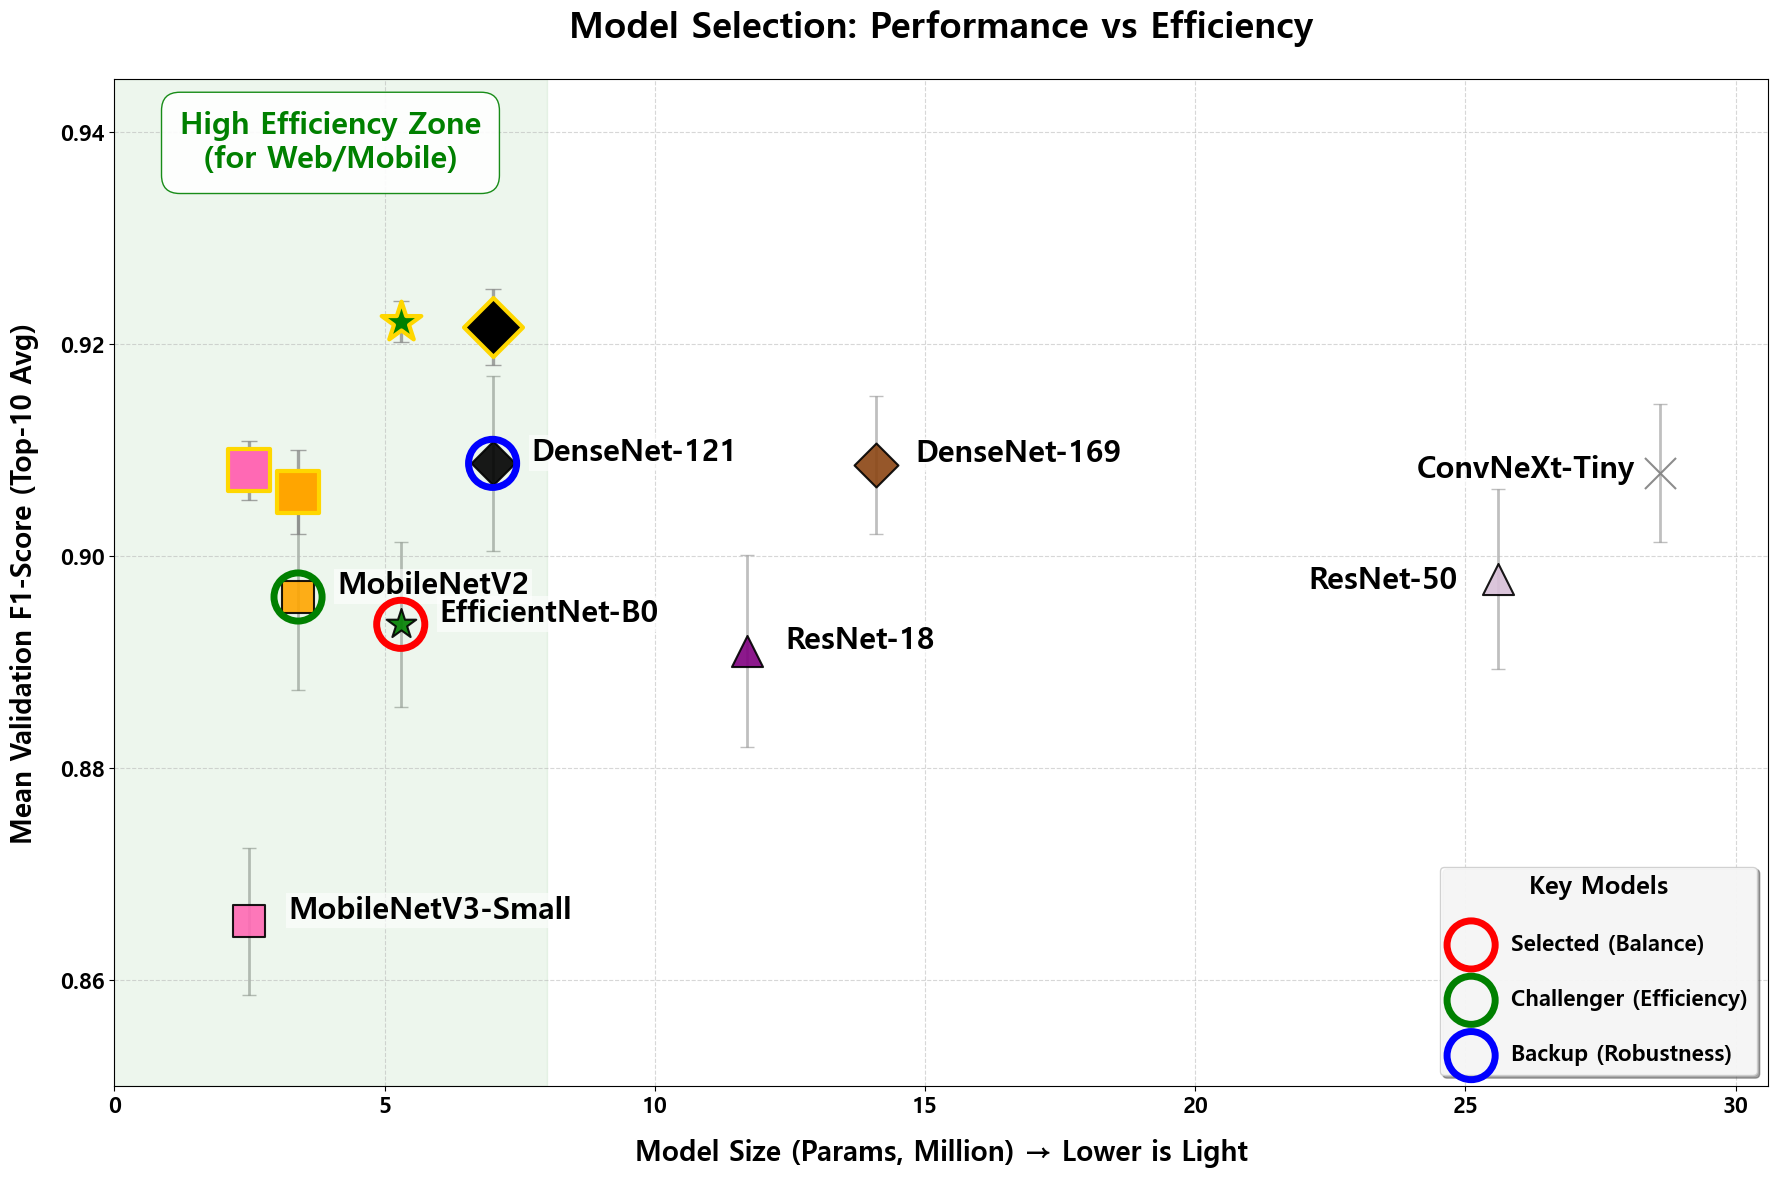

In [106]:
# [Cell Final] 모델 성능 vs 효율성 다이어그램 (수동 정렬 & 레이아웃 최적화)
#  - (모델별 심벌/색상 고정 버전)
#  - ✅ toward_log.csv는 Result_final 쪽에서 로드
#  - ✅ DenseNet 마커: 마름모(D) 유지
#  - ✅ toward 점에도 표준편차 에러바 추가
#  - ✅ 범례에 Toward(Best) 라벨 없음

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys

# -----------------------------------------------------------------------------
# 0. 환경 설정
# -----------------------------------------------------------------------------
if sys.platform == 'win32':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif sys.platform == 'darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

ROOT_DIR = os.getcwd()

RESULT_DIR = os.path.join(ROOT_DIR, 'Result')          # ✅ 기존 저장 경로 유지
RESULT_TOWARD_DIR = os.path.join(ROOT_DIR, 'Result_toward')
RESULT_FINAL_DIR = os.path.join(ROOT_DIR, 'Result_final')  # ✅ 새로 추가 정보가 있는 폴더

# ✅ toward_log.csv가 있을 수 있는 후보 경로들 (자동 탐색)
TOWARD_SEARCH_DIRS = [
    os.path.join(RESULT_FINAL_DIR, 'weights'),   # 1순위: Result_final/weights
    RESULT_FINAL_DIR,                            # 2순위: Result_final
    os.path.join(ROOT_DIR, 'weights'),           # 3순위: 혹시 프로젝트 루트/weights
]

# -----------------------------------------------------------------------------
# 1. 모델 스펙 정의
# -----------------------------------------------------------------------------
MODEL_SPECS = {
    'MobileNetV3-Small': 2.5, 'MobileNetV2': 3.4, 'EfficientNet-B0': 5.3,
    'DenseNet-121': 7.0, 'ResNet-18': 11.7, 'DenseNet-169': 14.1,
    'ResNet-50': 25.6, 'ConvNeXt-Tiny': 28.6
}

# -----------------------------------------------------------------------------
# 1-1. ✅ 모델별 심벌/색상 고정
# -----------------------------------------------------------------------------
MODEL_MARKERS = {
    'MobileNetV3-Small': 's',  # 사각형
    'MobileNetV2':       's',  # 사각형
    'DenseNet-121':      'D',  # 
    'DenseNet-169':      'D',  # 
    'ResNet-18':         '^',  # 
    'ResNet-50':         '^',  # 
    'EfficientNet-B0':   '*',  # 별표
    'ConvNeXt-Tiny':     'x',  # 
}

MODEL_COLORS_FIXED = {
    'MobileNetV3-Small': 'hotpink',     # 분홍색
    'MobileNetV2':       'orange',      # 주황색
    'DenseNet-121':      'black',       # 흑색
    'DenseNet-169':      'saddlebrown', # 갈색
    'ResNet-18':         'purple',      # 보라색
    'ResNet-50':         'thistle',     # 연보라색 (lavender/plum도 가능)
    'EfficientNet-B0':   'green',       # 녹색
    'ConvNeXt-Tiny':     'gray',        # 회색
}

# -----------------------------------------------------------------------------
# 2. 로그에서 F1 컬럼 찾는 함수
# -----------------------------------------------------------------------------
def find_f1_column(df: pd.DataFrame):
    normed = {c: c.lower().replace(' ', '').replace('_', '') for c in df.columns}
    candidates = ['validf1', 'valf1', 'f1score', 'f1']
    for c, nc in normed.items():
        if nc in candidates:
            return c
    return None

def find_existing_file(filename: str, search_dirs):
    """여러 후보 폴더에서 filename을 찾아서 첫 번째로 발견되는 전체 경로 반환."""
    for d in search_dirs:
        cand = os.path.join(d, filename)
        if os.path.exists(cand):
            return cand
    return None

# -----------------------------------------------------------------------------
# 3. 기본(기존) 데이터 추출: Top-10 F1 mean/std
# -----------------------------------------------------------------------------
TOP_K = 10
model_data = []

print(f"\n>> 학습 로그 분석 및 데이터 추출 중... (Top-{TOP_K} F1 평균/표준편차)")

for model_name, params in MODEL_SPECS.items():
    csv_path = os.path.join(RESULT_DIR, f"{model_name}_log.csv")
    if not os.path.exists(csv_path):
        alt_path = os.path.join(RESULT_TOWARD_DIR, f"{model_name}_log.csv")
        csv_path = alt_path if os.path.exists(alt_path) else None

    if not csv_path:
        continue

    try:
        df = pd.read_csv(csv_path)
        f1_col = find_f1_column(df)
        if not f1_col:
            continue

        top_f1 = df[f1_col].nlargest(TOP_K)
        std_val = top_f1.std(ddof=1) if len(top_f1) > 1 else 0.0

        model_data.append({
            'Model': model_name,
            'Params (M)': params,
            'F1_Mean': float(top_f1.mean()),
            'F1_Std': float(std_val)
        })
    except Exception as e:
        print(f"!! 로그 로드 실패: {model_name} ({csv_path}) -> {e}")

# -----------------------------------------------------------------------------
# 4. ✅ 추가 데이터: Result_final에서 4개 toward_log.csv 읽어서 오버레이 (mean/std 계산)
# -----------------------------------------------------------------------------
TOWARD_LOG_FILES = {
    'DenseNet-121':      'DenseNet-121_toward_log.csv',
    'EfficientNet-B0':   'EfficientNet-B0_toward_log.csv',
    'MobileNetV2':       'MobileNetV2_toward_log.csv',
    'MobileNetV3-Small': 'MobileNetV3-Small_toward_log.csv',
}

# ✅ toward에서도 "Top-K 기준 mean/std"로 에러바를 만들기 위해 TOP_K 그대로 사용
toward_points = []  # (Model, Params(M), F1_Mean, F1_Std, file_path)

print(f"\n>> [추가] Result_final 폴더의 toward_log.csv 로드 중... (Top-{TOP_K} mean/std로 에러바 추가)")

for model_name, fname in TOWARD_LOG_FILES.items():
    fpath = find_existing_file(fname, TOWARD_SEARCH_DIRS)

    if not fpath:
        print(f"!! toward_log 없음: {model_name} ({fname})")
        print(f"   - searched in:")
        for d in TOWARD_SEARCH_DIRS:
            print(f"     * {d}")
        continue

    try:
        df_t = pd.read_csv(fpath)
        f1_col = find_f1_column(df_t)
        if not f1_col:
            print(f"!! F1 컬럼을 찾지 못함: {model_name} ({fpath})")
            continue

        top_f1 = df_t[f1_col].nlargest(TOP_K)
        f1_mean = float(top_f1.mean())
        f1_std = float(top_f1.std(ddof=1)) if len(top_f1) > 1 else 0.0

        params = MODEL_SPECS.get(model_name, np.nan)
        toward_points.append((model_name, params, f1_mean, f1_std, fpath))

        print(f"   - toward overlay: {model_name} | Params={params}M | "
              f"F1_mean={f1_mean:.4f} | F1_std={f1_std:.4f}")
        print(f"     from: {fpath}")

    except Exception as e:
        print(f"!! toward_log 로드 실패: {model_name} ({fpath}) -> {e}")

# -----------------------------------------------------------------------------
# 5. 다이어그램 그리기
# -----------------------------------------------------------------------------
if model_data:
    df_results = pd.DataFrame(model_data)

    def plot_efficiency_scatter_manual(df):
        plt.figure(figsize=(18, 12))

        # -------------------------
        # (A) 기존 모델: 에러바
        # -------------------------
        plt.errorbar(
            df['Params (M)'], df['F1_Mean'], yerr=df['F1_Std'],
            fmt='none', ecolor='gray', elinewidth=2, capsize=5,
            alpha=0.5, zorder=1
        )

        # -------------------------
        # (B) ✅ toward 모델: 에러바 추가 (회색, 약간 진하게)
        # -------------------------
        if len(toward_points) > 0:
            x_t = [p[1] for p in toward_points]
            y_t = [p[2] for p in toward_points]
            e_t = [p[3] for p in toward_points]

            plt.errorbar(
                x_t, y_t, yerr=e_t,
                fmt='none', ecolor='gray', elinewidth=2.4, capsize=6,
                alpha=0.7, zorder=15
            )

        # -------------------------
        # (C) 기존 산점도 (Top-10 mean)
        # -------------------------
        BASE_POINT_SIZE = 500
        for _, row in df.iterrows():
            m = row['Model']
            x = row['Params (M)']
            y = row['F1_Mean']

            marker = MODEL_MARKERS.get(m, 'o')
            color = MODEL_COLORS_FIXED.get(m, 'black')

            plt.scatter(
                x, y,
                s=BASE_POINT_SIZE,
                marker=marker,
                c=color,
                alpha=0.9,
                edgecolors='black',
                linewidth=1.5,
                zorder=5
            )

        # -------------------------
        # (D) ✅ toward overlay 점 추가
        #     - 범례 라벨 없음 (label=None)
        #     - gold 테두리로 기존 점과 구분
        # -------------------------
        TOWARD_POINT_SIZE = 900
        TOWARD_EDGE_COLOR = 'gold'
        TOWARD_EDGE_LW = 3.0

        for (m, x, y, ystd, src) in toward_points:
            marker = MODEL_MARKERS.get(m, 'o')
            color = MODEL_COLORS_FIXED.get(m, 'black')

            plt.scatter(
                x, y,
                s=TOWARD_POINT_SIZE,
                marker=marker,
                c=color,
                alpha=1.0,
                edgecolors=TOWARD_EDGE_COLOR,
                linewidth=TOWARD_EDGE_LW,
                zorder=20
                # ✅ label 없음 → 범례에 Toward(Best) 항목 안 생김
            )

        # -------------------------
        # (E) 핵심 모델 강조 (Ring)
        # -------------------------
        RING_SIZE = 1200
        RING_LW = 5

        highlights = [
            ('EfficientNet-B0', 'red', 'Selected (Balance)'),
            ('MobileNetV2', 'green', 'Challenger (Efficiency)'),
            ('DenseNet-121', 'blue', 'Backup (Robustness)')
        ]

        for model, ring_color, label_txt in highlights:
            if model in df['Model'].values:
                row = df[df['Model'] == model].iloc[0]
                plt.scatter(
                    row['Params (M)'], row['F1_Mean'],
                    s=RING_SIZE, facecolors='none',
                    edgecolors=ring_color, linewidth=RING_LW,
                    zorder=10, label=label_txt
                )

        # -------------------------
        # (F) 텍스트 라벨링 (수동)
        # -------------------------
        LABEL_FS = 22
        X_OFFSET = 0.72
        Y_OFFSET = 0.001
        BBOX_ALPHA = 0.6

        for i in range(df.shape[0]):
            x_pos = df['Params (M)'][i]
            y_pos = df['F1_Mean'][i]
            model_name = df['Model'][i]

            x_off, y_off = X_OFFSET, Y_OFFSET
            if model_name == 'ResNet-50':
                x_off = -3.5
                y_off = -0.0002
            if model_name == 'ConvNeXt-Tiny':
                x_off = -4.5
                y_off = 0.0003

            plt.text(
                x_pos + x_off, y_pos + y_off, model_name,
                fontsize=LABEL_FS, fontweight='bold',
                ha='left', va='center',
                bbox=dict(facecolor='white', alpha=BBOX_ALPHA, edgecolor='none', pad=2)
            )

        # -------------------------
        # (G) High Efficiency Zone
        # -------------------------
        y_min = (df['F1_Mean'] - df['F1_Std']).min()
        y_max = (df['F1_Mean'] + df['F1_Std']).max()
        y_bottom = y_min - 0.01
        y_top = y_max + 0.01

        plt.axvspan(-2, 8, color='green', alpha=0.07)
        plt.text(
            4, y_top + 0.015,
            "High Efficiency Zone\n(for Web/Mobile)",
            color='green', fontsize=22, fontweight='bold',
            va='top', ha='center',
            bbox=dict(facecolor='white', alpha=0.9, edgecolor='green',
                      boxstyle='round,pad=0.6')
        )

        # -------------------------
        # (H) 타이틀/축
        # -------------------------
        plt.title("Model Selection: Performance vs Efficiency", fontsize=26, fontweight='bold', pad=30)
        plt.xlabel("Model Size (Params, Million) → Lower is Light", fontsize=20, fontweight='bold', labelpad=15)
        plt.ylabel("Mean Validation F1-Score (Top-10 Avg)", fontsize=20, fontweight='bold', labelpad=15)

        max_params = df['Params (M)'].max()
        plt.xlim(0, max_params + 2)
        Y_MIN, Y_MAX = 0.85, 0.945
        plt.ylim(Y_MIN, Y_MAX)

        plt.grid(True, linestyle='--', alpha=0.5)
        plt.tick_params(axis='both', which='major', labelsize=16)

        # ✅ 범례: 링(핵심 모델)만 표시 (Toward 항목 없음)
        plt.legend(
            loc='lower right', fontsize=16, labelspacing=1.5,
            framealpha=0.9, shadow=True,
            title="Key Models", title_fontsize=18
        )

        plt.tight_layout()
        save_path = os.path.join(RESULT_DIR, "Model_Selection_Diagram_Final_Manual.png")
        plt.savefig(save_path, dpi=300)
        print(f">> 그래프 저장 완료: {save_path}")
        plt.show()

    plot_efficiency_scatter_manual(df_results)
else:
    print("!! 데이터가 없습니다.")



>> 모델별 학습 결과 요약 (toward_log 4개 모델)

DenseNet-121:
  - 총 에폭: 55개
  - 최고 정확도: 0.9267 (Epoch 25)
  - 최종 정확도: 0.9027
  - toward_log: c:\yssong\Mid_project\Mold-Pang_final\Result_final\DenseNet-121_toward_log.csv

EfficientNet-B0:
  - 총 에폭: 50개
  - 최고 정확도: 0.9252 (Epoch 27)
  - 최종 정확도: 0.9140
  - toward_log: c:\yssong\Mid_project\Mold-Pang_final\Result_final\EfficientNet-B0_toward_log.csv

MobileNetV3-Small:
  - 총 에폭: 41개
  - 최고 정확도: 0.9126 (Epoch 40)
  - 최종 정확도: 0.9027
  - toward_log: c:\yssong\Mid_project\Mold-Pang_final\Result_final\MobileNetV3-Small_toward_log.csv

MobileNetV2:
  - 총 에폭: 37개
  - 최고 정확도: 0.9126 (Epoch 15)
  - 최종 정확도: 0.8914
  - toward_log: c:\yssong\Mid_project\Mold-Pang_final\Result_final\MobileNetV2_toward_log.csv


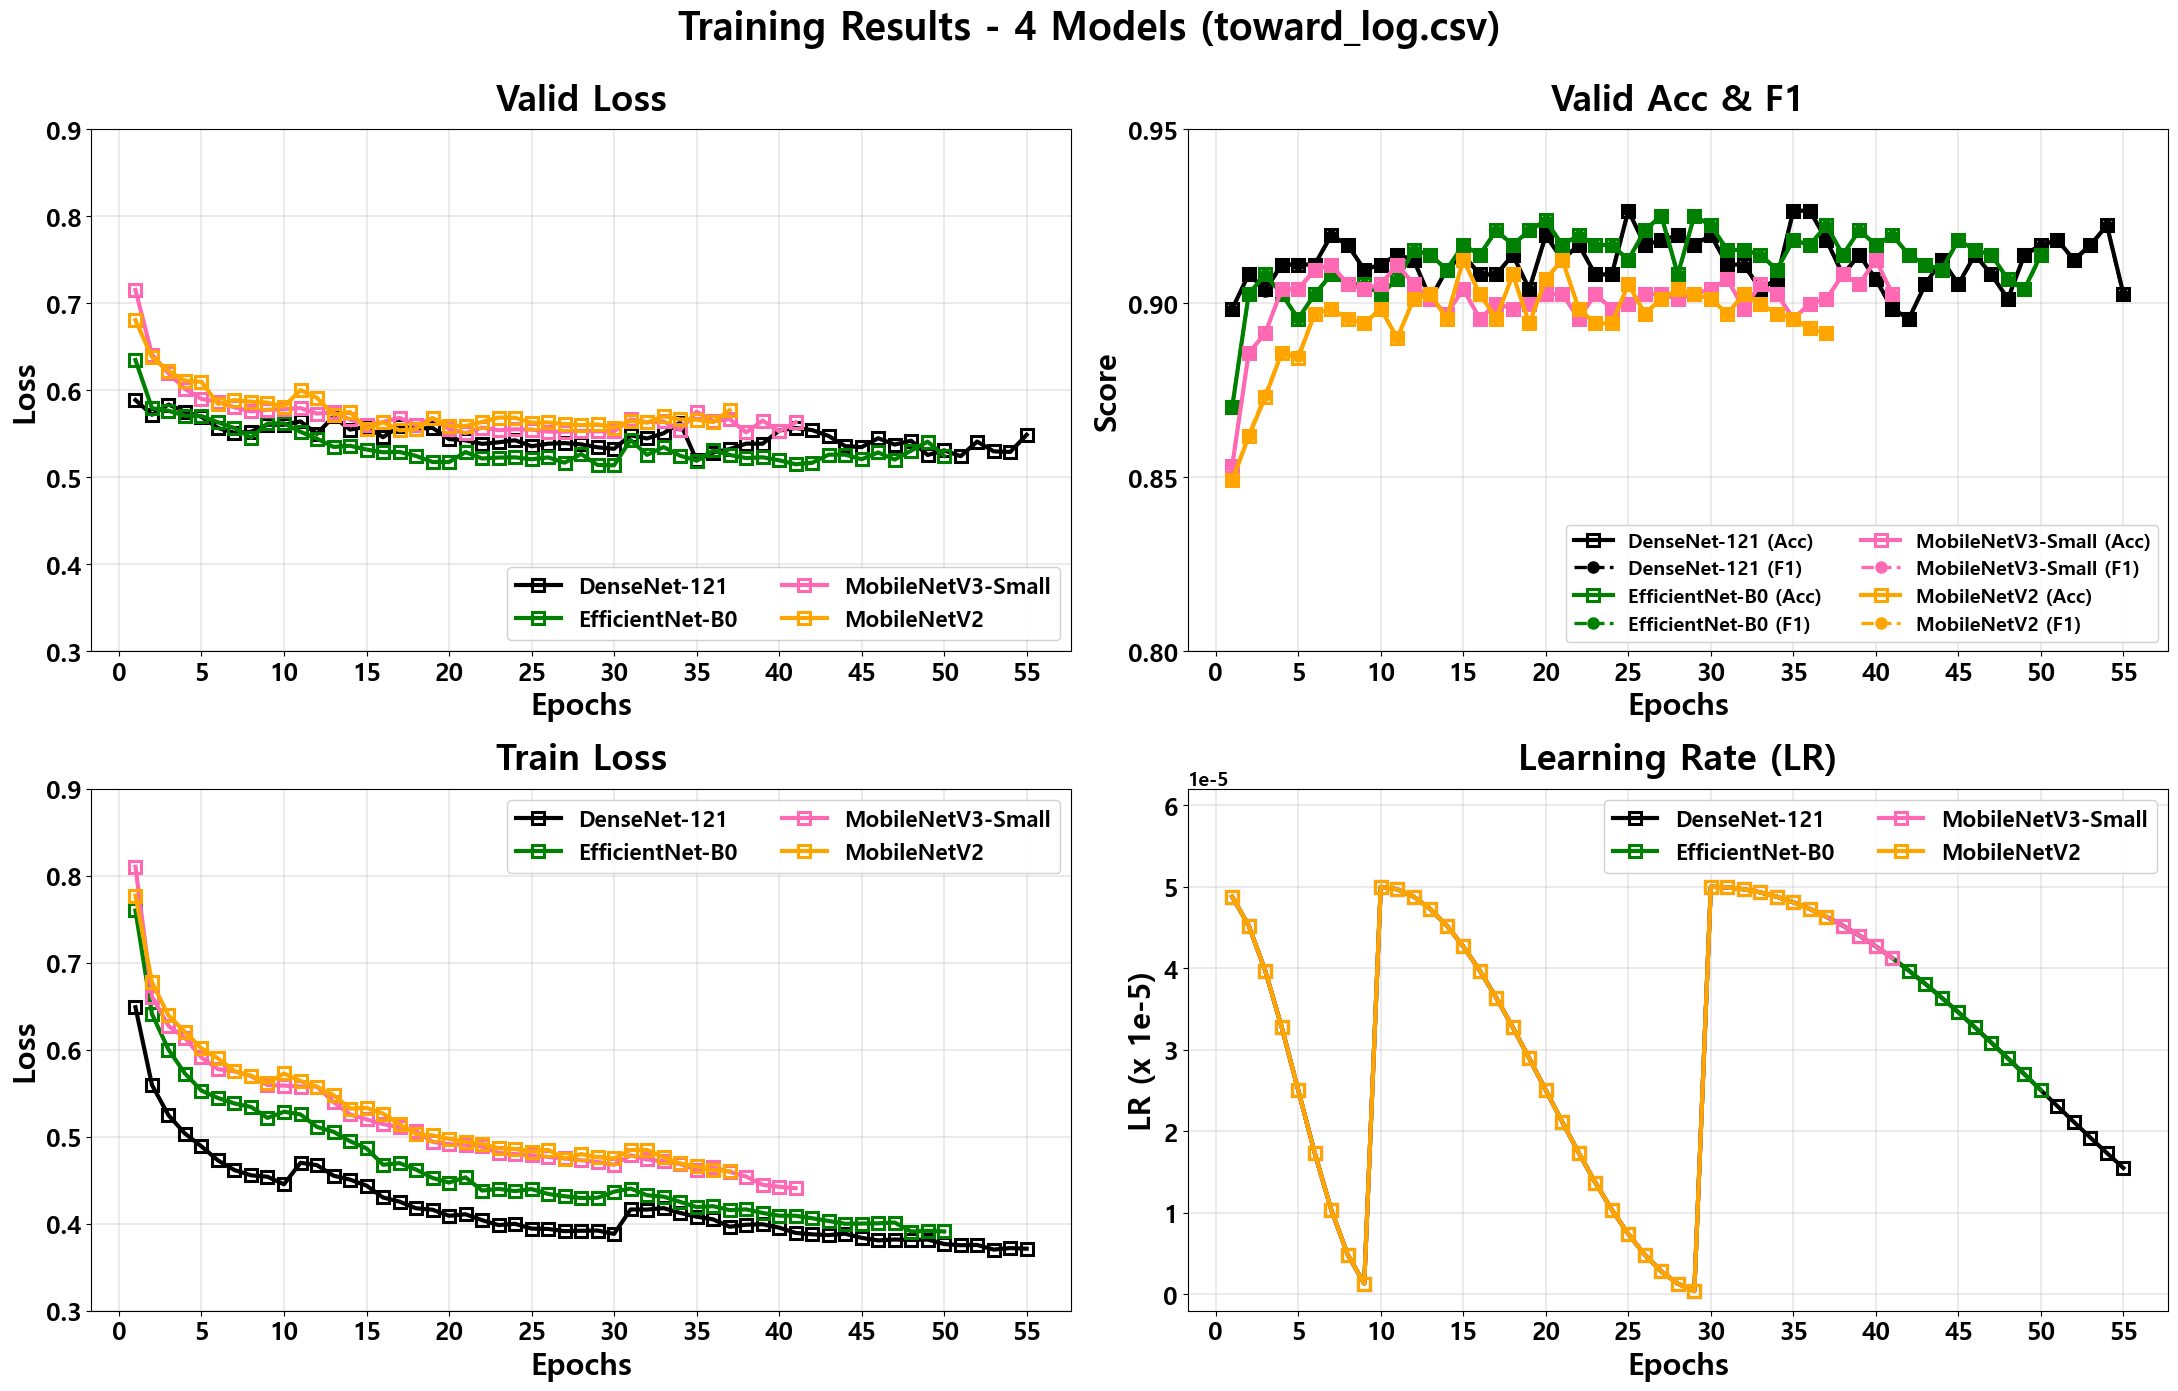


>> 그래프 저장: c:\yssong\Mid_project\Mold-Pang_final\Result\training_curves_all_final.png
>> 4개 모델 toward_log 학습 곡선 시각화 완료


In [108]:
# [Cell 20] 학습 결과 그래프 그리기 (Epoch vs Metrics) - 4가지 toward_log.csv 로드 버전
# ✅ CSV 위치: Result_final/<모델명>_toward_log.csv  (weight 폴더 아님)
# ✅ 1행1열: Valid Loss (y: 0~0.8, tick 0.1)  ※ 현재 코드는 0.3~0.9 유지
# ✅ 2행1열: Train Loss (y: 0~0.8, tick 0.1) ※ 현재 코드는 0.3~0.9 유지
# ✅ 1행2열: Valid Acc & Valid F1 (y: 0.7~1.0, tick 0.05) ※ 현재 코드는 0.8~0.95 유지
# ✅ 2행2열: Learning Rate (y: -0.02~6.02 적용)
# ✅ Epochs 축 tick 간격: 5
# ✅ 폰트(축 숫자/축제목/그래프제목/범례) 크기↑ + 굵게(BOLD)
# ✅ 저장: Result/training_curves_all.png  (원래 포맷 유지)

import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator, MaxNLocator

# ---------------------------------------------------------------------
# 0. 환경 설정
# ---------------------------------------------------------------------
if sys.platform == 'win32':
    plt.rcParams['font.family'] = 'Malgun Gothic'
elif sys.platform == 'darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

ROOT_DIR = os.getcwd()

# ✅ 결과 저장 폴더 (기존 코드 유지)
RESULT_DIR = os.path.join(ROOT_DIR, 'Result')
os.makedirs(RESULT_DIR, exist_ok=True)

# ✅ toward_log.csv가 있는 폴더 (요청사항 반영: Result_final 바로 아래)
TOWARD_DIR = os.path.join(ROOT_DIR, 'Result_final')

# ---------------------------------------------------------------------
# 1. 모델 목록 / 색상
# ---------------------------------------------------------------------
MODEL_NAMES = [
    'DenseNet-121',
    'EfficientNet-B0',
    'MobileNetV3-Small',
    'MobileNetV2',
    
]

MODEL_COLORS = {
    'DenseNet-121':      'black',
    'EfficientNet-B0':   'green',
    'MobileNetV3-Small': 'hotpink',
    'MobileNetV2':       'orange'
    
}

# ---------------------------------------------------------------------
# 2. toward_log.csv 로드
# ---------------------------------------------------------------------
def load_history_toward(model_name: str):
    """
    Result_final/<model_name>_toward_log.csv 를 읽는다.
    파일이 없으면 None 반환.
    """
    csv_path = os.path.join(TOWARD_DIR, f"{model_name}_toward_log.csv")
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    print(f"!! toward_log 없음: {model_name} ({csv_path})")
    return None

# ---------------------------------------------------------------------
# 3. 학습 결과 통계 출력 + 데이터 적재
# ---------------------------------------------------------------------
print("\n" + "=" * 80)
print(">> 모델별 학습 결과 요약 (toward_log 4개 모델)")
print("=" * 80)

histories = {}
for model_name in MODEL_NAMES:
    df = load_history_toward(model_name)
    if df is None or df.empty:
        continue

    # 필수 컬럼 체크 (없으면 에러 방지)
    required_cols = ['Epoch', 'Train Loss', 'Valid Loss', 'Valid Acc', 'Valid F1', 'LR']
    missing = [c for c in required_cols if c not in df.columns]
    if missing:
        print(f"!! 컬럼 누락: {model_name} -> {missing}")
        continue

    histories[model_name] = df

    best_epoch = df['Valid Acc'].idxmax() + 1
    best_acc = df['Valid Acc'].max()
    final_acc = df['Valid Acc'].iloc[-1]
    total_epochs = len(df)

    print(f"\n{model_name}:")
    print(f"  - 총 에폭: {total_epochs}개")
    print(f"  - 최고 정확도: {best_acc:.4f} (Epoch {best_epoch})")
    print(f"  - 최종 정확도: {final_acc:.4f}")
    print(f"  - toward_log: {os.path.join(TOWARD_DIR, f'{model_name}_toward_log.csv')}")

# ---------------------------------------------------------------------
# 4. 그래프 출력 (2x2)
# ---------------------------------------------------------------------
if not histories:
    print("!! 출력할 toward_log.csv가 없습니다. (Result_final 폴더를 확인하세요.)")
else:
    # ✅ 전체 타이틀도 조금 키움
    fig, axes = plt.subplots(2, 2, figsize=(22, 14))
    fig.suptitle("Training Results - 4 Models (toward_log.csv)",
                 fontsize=28, fontweight='bold', y=0.995)

    # ✅ 마커 스타일(기존 유지)
    open_square = dict(marker='s', markersize=8, markerfacecolor='none', markeredgewidth=2.2)
    filled_circle = dict(marker='o', markersize=8)

    # ✅ 공통 폰트/굵기 설정 값
    TITLE_FS = 26     # 각 subplot 제목(특히 더 크게)
    LABEL_FS = 22     # x/y 라벨
    TICK_FS  = 18     # 축 숫자
    LEG_FS   = 16     # 범례
    LW_MAIN  = 3.0    # 선 굵기 약간 증가(가독성↑)

    def apply_common_axis_style(ax):
        # Epochs tick 간격 5
        ax.xaxis.set_major_locator(MultipleLocator(5))
        # tick 폰트 크기/굵기
        ax.tick_params(axis='both', which='major', labelsize=TICK_FS)
        for t in ax.get_xticklabels():
            t.set_fontweight('bold')
        for t in ax.get_yticklabels():
            t.set_fontweight('bold')

    # ---------------------------------------------------------
    # 1행 1열: Valid Loss
    # ---------------------------------------------------------
    ax = axes[0, 0]
    for name, df in histories.items():
        ax.plot(df['Epoch'], df['Valid Loss'], label=name,
                color=MODEL_COLORS.get(name, '#000000'),
                linewidth=LW_MAIN, **open_square)

    ax.set_title("Valid Loss", fontsize=TITLE_FS, fontweight='bold', pad=14)
    ax.set_xlabel("Epochs", fontsize=LABEL_FS, fontweight='bold')
    ax.set_ylabel("Loss", fontsize=LABEL_FS, fontweight='bold')
    ax.grid(True, alpha=0.3, linewidth=1.2)

    # ✅ 기존 코드의 축 설정 유지(누락 없이)
    ax.set_ylim(0.3, 0.9)
    ax.set_yticks(np.arange(0.3, 0.91, 0.1))

    apply_common_axis_style(ax)

    leg = ax.legend(fontsize=LEG_FS, loc='lower right', framealpha=0.9, ncol=2)
    for txt in leg.get_texts():
        txt.set_fontweight('bold')

    # ---------------------------------------------------------
    # 2행 1열: Train Loss
    # ---------------------------------------------------------
    ax = axes[1, 0]
    for name, df in histories.items():
        ax.plot(df['Epoch'], df['Train Loss'], label=name,
                color=MODEL_COLORS.get(name, '#000000'),
                linewidth=LW_MAIN, **open_square)

    ax.set_title("Train Loss", fontsize=TITLE_FS, fontweight='bold', pad=14)
    ax.set_xlabel("Epochs", fontsize=LABEL_FS, fontweight='bold')
    ax.set_ylabel("Loss", fontsize=LABEL_FS, fontweight='bold')
    ax.grid(True, alpha=0.3, linewidth=1.2)

    # ✅ 기존 코드의 축 설정 유지(누락 없이)
    ax.set_ylim(0.3, 0.9)
    ax.set_yticks(np.arange(0.3, 0.91, 0.1))

    apply_common_axis_style(ax)

    leg = ax.legend(fontsize=LEG_FS, loc='upper right', framealpha=0.9, ncol=2)
    for txt in leg.get_texts():
        txt.set_fontweight('bold')

    # ---------------------------------------------------------
    # 1행 2열: Valid Acc + Valid F1
    # ---------------------------------------------------------
    ax = axes[0, 1]
    for name, df in histories.items():
        color = MODEL_COLORS.get(name, '#000000')
        ax.plot(df['Epoch'], df['Valid Acc'], label=f"{name} (Acc)",
                color=color, linewidth=LW_MAIN, **open_square)
        ax.plot(df['Epoch'], df['Valid F1'], label=f"{name} (F1)",
                color=color, linewidth=LW_MAIN-0.6, linestyle='--', **filled_circle)

    ax.set_title("Valid Acc & F1", fontsize=TITLE_FS, fontweight='bold', pad=14)
    ax.set_xlabel("Epochs", fontsize=LABEL_FS, fontweight='bold')
    ax.set_ylabel("Score", fontsize=LABEL_FS, fontweight='bold')
    ax.grid(True, alpha=0.3, linewidth=1.2)

    # ✅ 기존 코드의 축 설정 유지(누락 없이)
    ymin, ymax = 0.8, 0.95
    ax.set_ylim(ymin, ymax)
    ax.set_yticks(np.arange(ymin, ymax + 0.001, 0.05))
    ax.set_yticklabels([f"{v:.2f}" for v in np.arange(ymin, ymax + 0.01, 0.05)])

    apply_common_axis_style(ax)

    leg = ax.legend(fontsize=14, loc='lower right', framealpha=0.9, ncol=2)
    for txt in leg.get_texts():
        txt.set_fontweight('bold')

    # ---------------------------------------------------------
    # 2행 2열: Learning Rate
    # ---------------------------------------------------------
    ax = axes[1, 1]
    for name, df in histories.items():
        ax.plot(df['Epoch'], df['LR'], label=name,
                color=MODEL_COLORS.get(name, '#000000'),
                linewidth=LW_MAIN, **open_square)

    ax.set_title("Learning Rate (LR)", fontsize=TITLE_FS, fontweight='bold', pad=14)
    ax.set_xlabel("Epochs", fontsize=LABEL_FS, fontweight='bold')
    ax.set_ylabel("LR (x 1e-5)", fontsize=LABEL_FS, fontweight='bold')
    ax.grid(True, alpha=0.3, linewidth=1.2)

    # ✅ 요청사항: 2행2열 y축 범위 -0.02 ~ 6.02
    ax.set_ylim(-0.2e-5, 6.2e-5)

    apply_common_axis_style(ax)

    leg = ax.legend(fontsize=LEG_FS, loc='upper right', framealpha=0.9, ncol=2)
    for txt in leg.get_texts():
        txt.set_fontweight('bold')

    plt.tight_layout()
    save_path = os.path.join(RESULT_DIR, 'training_curves_all_final.png')
    plt.savefig(save_path, dpi=220, bbox_inches='tight')
    plt.show()

    print(f"\n>> 그래프 저장: {save_path}")
    print(">> 4개 모델 toward_log 학습 곡선 시각화 완료")
